# Settings

In [2]:
# Load packages
pacman::p_load(dplyr, stringr, data.table, tidyr, data.table, Matrix, tidyverse, biomaRt, SNPlocs.Hsapiens.dbSNP155.GRCh38, SNPlocs.Hsapiens.dbSNP144.GRCh37,
               hdf5r, Seurat, Signac,harmony, knitr, SoupX, igraph,
               EnsDb.Hsapiens.v86, fgsea,AnnotationHub, GenomicRanges,AnnotationDbi,viridis,
               logr, parallel, DESeq2,
               pheatmap, ggplot2, ggpubr, ggrepel, ggbreak, gridExtra, patchwork, grid, ggh4x, ggnewscale, RColorBrewer, ggalluvial, ggpattern)

# Set options
options(stringsAsFactors = FALSE)
warnLevel <- getOption('warn')
options(warn = -1)
opts_chunk$set(tidy=TRUE)
options(scipen = 12)

In [3]:
# Setup directories
FineMap.dir = "/nfs/lab/relgamal/HERMES2_GWAS_DCM_EUR/fine_mapping/"

results.dir = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/"

In [4]:
# Grep all files
files = dir(FineMap.dir, pattern = "95_cs.tsv", full.names = TRUE)
filenames = str_split_fixed(basename(files), "_95_cs.tsv", n = 2)[,1]
message("Files found: ", length(files))

Files found: 80



In [4]:
data.all = NULL
# Cat them all together
for (i in seq_along(files)){
    message("Processing: ", filenames[i])
    data = read.table(files[i], header = TRUE) %>%
           dplyr::select(rsID, pp, cs_nvar, A1, A2) %>%
           dplyr::mutate(Locus = filenames[i])

    data.all = rbind(data.all, data)
}

Processing: locus_1

Processing: locus_10

Processing: locus_11

Processing: locus_12

Processing: locus_13

Processing: locus_14

Processing: locus_15

Processing: locus_16

Processing: locus_17

Processing: locus_18

Processing: locus_19

Processing: locus_2

Processing: locus_20

Processing: locus_21

Processing: locus_22

Processing: locus_23

Processing: locus_24

Processing: locus_25

Processing: locus_26

Processing: locus_27

Processing: locus_28

Processing: locus_29

Processing: locus_3

Processing: locus_30

Processing: locus_31

Processing: locus_32

Processing: locus_33

Processing: locus_34

Processing: locus_35

Processing: locus_36

Processing: locus_37

Processing: locus_38

Processing: locus_39

Processing: locus_4

Processing: locus_40

Processing: locus_41

Processing: locus_42

Processing: locus_43

Processing: locus_44

Processing: locus_45

Processing: locus_46

Processing: locus_47

Processing: locus_48

Processing: locus_49

Processing: locus_5

Processing: loc

In [5]:
message("Total Variants: ",nrow(data.all))
head(data.all, n = 2)

Total Variants: 27261



rsID       pp        cs_nvar A1 A2 Locus  
1 rs2503715  0.3703056 166     A  G  locus_1
2 rs56260599 0.2803233 166     A  G  locus_1

In [6]:
# Are my snps named correctly - 224 aren't
sum(str_detect(data.all$rsID, 'rs'))
 
nrow(data.all[!str_detect(data.all$rsID, 'rs'),])

[1] 27037

[1] 224

In [7]:
test = data.all[!str_detect(data.all$rsID, 'rs'),]

In [8]:
test %>%
  dplyr::mutate(
    PP_range = dplyr::case_when(
      pp > 0.5 ~ "> 0.5",
      pp > 0.3 & pp <= 0.5 ~ "0.3 - 0.5",
      pp > 0.2 & pp <= 0.3 ~ "0.2 - 0.3",
      pp > 0.1 & pp <= 0.2 ~ "0.1 - 0.2",
      pp <= 0.1 ~ "0 - 0.1",
      TRUE ~ "Other"
    )
  ) %>%
  dplyr::group_by(PP_range) %>%
  dplyr::summarize(rsID_count = n(), .groups = "drop") %>%
  dplyr::mutate(Proportion = rsID_count / sum(rsID_count) * 100) %>%
  dplyr::mutate(PP_range = factor(PP_range, levels = rev(c("> 0.5", "0.3 - 0.5", "0.2 - 0.3",
                                                       "0.1 - 0.2", "0 - 0.1"))))

PP_range  rsID_count Proportion
1 0 - 0.1   223        99.5535714
2 0.3 - 0.5   1         0.4464286

In [9]:
# Let's just drop it for now and let's also drop all variants that have less than 1% ppa

In [10]:
data.all = data.all[str_detect(data.all$rsID, 'rs'),]
length(unique(data.all$Locus))
nrow(data.all)

[1] 80

[1] 27037

# Convert to hg38 loci

In [11]:
snps <- SNPlocs.Hsapiens.dbSNP155.GRCh38
snpcount(snps)
seqinfo(snps)

1        2        3        4        5        6        7        8 
75018827 79800406 65297222 62943150 58975130 54890615 52513853 49808065 
       9       10       11       12       13       14       15       16 
41429208 43919217 45144118 43436160 32601707 29144464 27215990 29493439 
      17       18       19       20       21       22        X        Y 
26217755 25582976 19590577 20830213 12400011 12798923 37808263  2153980 
      MT 
    7179

Seqinfo object with 25 sequences (1 circular) from GRCh38.p13 genome:
  seqnames seqlengths isCircular     genome
  1         248956422      FALSE GRCh38.p13
  2         242193529      FALSE GRCh38.p13
  3         198295559      FALSE GRCh38.p13
  4         190214555      FALSE GRCh38.p13
  5         181538259      FALSE GRCh38.p13
  ...             ...        ...        ...
  21         46709983      FALSE GRCh38.p13
  22         50818468      FALSE GRCh38.p13
  X         156040895      FALSE GRCh38.p13
  Y          57227415      FALSE GRCh38.p13
  MT            16569       TRUE GRCh38.p13

In [12]:
# Look up SNP positions
my_snps <- snpsById(snps, data.all$rsID[str_detect(data.all$rsID, 'rs')], ifnotfound='warning')
my_snps

UnstitchedGPos object with 25240 positions and 2 metadata columns:
          seqnames       pos strand |   RefSNP_id alleles_as_ambig
             <Rle> <integer>  <Rle> | <character>      <character>
      [1]        1   2212668      * |   rs2503715                D
      [2]        1   2124676      * |  rs56260599                V
      [3]        1   2207868      * |   rs2503713                B
      [4]        1   2213543      * |   rs2480714                K
      [5]        1   2187100      * |   rs2503699                H
      ...      ...       ...    ... .         ...              ...
  [25236]       22  23806086      * |   rs2267032                R
  [25237]       22  23836092      * |   rs5760061                D
  [25238]       22  23821479      * |   rs9612464                S
  [25239]       22  23820176      * |  rs80135378                H
  [25240]        1 179423728      * |  rs61822778                R
  -------
  seqinfo: 25 sequences (1 circular) from GRCh38.p13

In [13]:
# Convert to dataframe
my_snps.df <- dplyr::select(data.frame(my_snps), 
                            rsID=RefSNP_id, chr.hg38=seqnames, end.hg38=pos) %>%
              dplyr::mutate(start.hg38 = end.hg38-1, 
                            chr.hg38 = paste0("chr", chr.hg38))

dim(my_snps.df)
head(my_snps.df)

[1] 25240     4

rsID       chr.hg38 end.hg38 start.hg38
1 rs2503715  chr1     2212668  2212667   
2 rs56260599 chr1     2124676  2124675   
3 rs2503713  chr1     2207868  2207867   
4 rs2480714  chr1     2213543  2213542   
5 rs2503699  chr1     2187100  2187099   
6 rs2460002  chr1     2188394  2188393

In [14]:
# Region to credible set data
data.all.hg38 <- inner_join(data.all, my_snps.df)
dim(data.all.hg38)
head(data.all.hg38)

Joining with `by = join_by(rsID)`


[1] 25252     9

rsID       pp         cs_nvar A1 A2 Locus   chr.hg38 end.hg38 start.hg38
1 rs2503715  0.37030556 166     A  G  locus_1 chr1     2212668  2212667   
2 rs56260599 0.28032327 166     A  G  locus_1 chr1     2124676  2124675   
3 rs2503713  0.03391747 166     C  T  locus_1 chr1     2207868  2207867   
4 rs2480714  0.02943236 166     G  T  locus_1 chr1     2213543  2213542   
5 rs2503699  0.02383911 166     C  T  locus_1 chr1     2187100  2187099   
6 rs2460002  0.02335504 166     A  G  locus_1 chr1     2188394  2188393

In [15]:
# Save table
write.table(data.all.hg38,
            file = paste("/nfs/lab/tscc/luca/MEGA_Heart/Finrich/Inputs/chromBP_input/Hermes_80LociHF_Hg38.txt", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

In [2953]:
# Add cytoband information:
## File downloaded from: http://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/cytoBand.txt
cytoband <- read.table("/nfs/lab/tscc/luca/Assets/Genetics/Hg38_cytoBand.txt",
                       header = FALSE, stringsAsFactors = FALSE, fill = NA) %>%
                       dplyr::filter_all(all_vars(!is.na(.)))

colnames(cytoband) <- c("chrom", "chromStart", "chromEnd", "cytoband", "gieStain")

# remove cytoband with NA (that's all alternate chromosomes)

In [2955]:
# Create a GRanges object for cytobands
cytoband_gr <- GRanges(
  seqnames = cytoband$chrom,
  ranges = IRanges(start = cytoband$chromStart, end = cytoband$chromEnd),
  cytoband = cytoband$cytoband
)

# Create a GRanges object for your variants.
# Here, we use 'start.hg38' and 'end.hg38' to define the variant range.
variants_gr <- GRanges(
  seqnames = data.all.hg38$chr.hg38,
  ranges = IRanges(start = data.all.hg38$start.hg38, end = data.all.hg38$end.hg38)
)

# Find overlaps between variants and cytoband regions
overlap_idx <- findOverlaps(variants_gr, cytoband_gr)

# Initialize a new column for cytoband annotation in your variants data frame.
data.all.hg38$cytoband <- NA

# If a variant overlaps more than one cytoband (rare for SNPs), this code will assign the first match.
data.all.hg38$cytoband[queryHits(overlap_idx)] <- cytoband_gr$cytoband[subjectHits(overlap_idx)]

In [2957]:
head(data.all.hg38, n=2)

rsID       pp        cs_nvar A1 A2 Locus   chr.hg38 end.hg38 start.hg38
1 rs2503715  0.3703056 166     A  G  locus_1 chr1     2212668  2212667   
2 rs56260599 0.2803233 166     A  G  locus_1 chr1     2124676  2124675   
  cytoband
1 p36.33  
2 p36.33

In [3044]:
dplyr::filter(data.all.hg38, rsID == "rs17099139")

rsID       pp       cs_nvar A1 A2 Locus    chr.hg38 end.hg38  start.hg38
1 rs17099139 0.543521 2       C  G  locus_47 chr10    119659975 119659974 
  cytoband
1 q26.11

In [3110]:
# Make a locus by cytoband table to use later on
unique_locus_table <- data.all.hg38 %>%
  group_by(Locus) %>%
  slice_max(pp, n = 1, with_ties = FALSE) %>%  # Select lead variant by highest PPA per locus
  ungroup() %>%
  dplyr::select(Locus, chr.hg38, cytoband) %>%
  mutate(chr_cytoband = paste0(gsub("^chr", "", chr.hg38), cytoband))

dplyr::filter(unique_locus_table, Locus == "locus_47")

Locus    chr.hg38 cytoband chr_cytoband
1 locus_47 chr10    q26.11   10q26.11

In [3113]:
write.table(unique_locus_table,
            file = paste("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_LocusID", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

## Save SNP file for chromBP

In [16]:
data.print = dplyr::select(data.all.hg38,
                          chr.hg38, start.hg38,
                          A1, A2, rsID)
    # Save table
    write.table(data.print,
                file = paste("/nfs/lab/tscc/luca/MEGA_Heart/Finrich/Inputs/chromBP_input/Hermes_80LociHF_Hg38.bed", sep = ""),
                col.names = F, row.names = F, sep = "\t", quote = F)

In [2927]:
dplyr::filter(data.all.hg38, rsID == "rs11785912")

rsID       pp            cs_nvar A1 A2 Locus    chr.hg38 end.hg38 start.hg38
1 rs11785912 0.00005851218 1162    C  G  locus_36 chr8     11742724 11742723

# Make some stats for the GWAS paper

In [17]:
variants_loci = data.all.hg38 %>%
  dplyr::group_by(Locus) %>%
  dplyr::summarize(
    variants_locus = length(unique(rsID)),
    .groups = "drop"
  ) %>%
  dplyr::mutate(
    Variants_range = dplyr::case_when(
      variants_locus > 100 ~ "101+",
      variants_locus > 50 & variants_locus <= 100 ~ "51-100",
      variants_locus > 20 & variants_locus <= 50 ~ "21-50",
      variants_locus > 5 & variants_locus <= 20 ~ "6-20",
      variants_locus > 2 & variants_locus <= 5 ~ "3-5",
      variants_locus > 0 & variants_locus <= 2 ~ "1-2", 
      TRUE ~ "Other"
    )
  ) %>%
  dplyr::group_by(Variants_range) %>%
  dplyr::summarize(
    Variants_counts = n(),
    .groups = "drop"
  ) %>%
  dplyr::mutate(Variants_range = factor(Variants_range, levels = c("101+", "51-100", "21-50", "6-20", "3-5", "1-2")))

In [18]:
variants_loci
sum(variants_loci$Variants_counts)

Variants_range Variants_counts
1 1-2             6             
2 101+           25             
3 21-50          12             
4 3-5             5             
5 51-100         12             
6 6-20           20

[1] 80

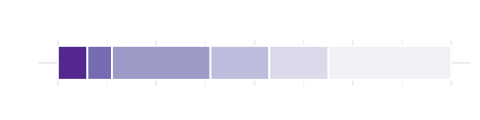

In [19]:
options(repr.plot.width=4, repr.plot.height=1)

# Assuming summary_pp contains the summarized data
gg = ggplot(variants_loci, aes(x = "", y = Variants_counts, fill = Variants_range)) +
geom_bar(stat = "identity", color = "white", size = 0.5, position = "fill") +
  scale_fill_brewer(palette = "Purples") +  # Use a color palette
  labs(
    x = "",
    y = "",
    fill = "",
    title = ""
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_text(size = 10, face = "bold"),
    legend.position = "none"
  ) + 
coord_flip()
gg

In [20]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                          "80LociGWAS_Variants_counts.pdf"),
                            width = 4, height = 1, 
                            plot = gg, device = "pdf")

In [21]:
PPA_breakdown = data.all.hg38 %>%
  dplyr::mutate(
    PP_range = dplyr::case_when(
      pp > 0.5 ~ "> 0.5",
      pp > 0.3 & pp <= 0.5 ~ "0.3 - 0.5",
      pp > 0.2 & pp <= 0.3 ~ "0.2 - 0.3",
      pp > 0.1 & pp <= 0.2 ~ "0.1 - 0.2",
      pp > 0.01 & pp <= 0.1 ~ "0.01 - 0.1",
      pp <= 0.01 ~ "0 - 0.01",
      TRUE ~ "Other"
    )
  ) %>%
  dplyr::group_by(PP_range) %>%
  dplyr::summarize(rsID_count = n(), .groups = "drop") %>%
  dplyr::mutate(Proportion = rsID_count / sum(rsID_count) * 100) %>%
  dplyr::mutate(PP_range = factor(PP_range, levels = rev(c("> 0.5", "0.3 - 0.5", "0.2 - 0.3",
                                                       "0.1 - 0.2", "0.01 - 0.1", "0 - 0.01"))))

In [22]:
PPA_breakdown

PP_range   rsID_count Proportion 
1 0 - 0.01   24181      95.75875178
2 0.01 - 0.1   942       3.73039759
3 0.1 - 0.2     76       0.30096626
4 0.2 - 0.3     19       0.07524157
5 0.3 - 0.5     20       0.07920165
6 > 0.5         14       0.05544115

In [23]:
#PPA_breakdown = dplyr::filter(PPA_breakdown, PP_range != "0 - 0.01")
PPA_breakdown

PP_range   rsID_count Proportion 
1 0 - 0.01   24181      95.75875178
2 0.01 - 0.1   942       3.73039759
3 0.1 - 0.2     76       0.30096626
4 0.2 - 0.3     19       0.07524157
5 0.3 - 0.5     20       0.07920165
6 > 0.5         14       0.05544115

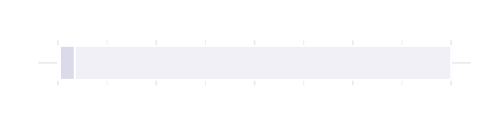

In [24]:
options(repr.plot.width=4, repr.plot.height=1)

# Assuming summary_pp contains the summarized data
gg = ggplot(PPA_breakdown, aes(x = "", y = rsID_count, fill = PP_range)) +
geom_bar(stat = "identity", color = "white", size = 0.5, position = "fill") +
  scale_fill_brewer(palette = "Purples") +  # Use a color palette
  labs(
    x = "",
    y = "",
    fill = "",
    title = ""
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_text(size = 10, face = "bold"),
    legend.position = "none"
  ) + 
coord_flip()
gg

In [25]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                          "80LociGWAS_Variants_PPA.pdf"),
                            width = 4, height = 1, 
                            plot = gg, device = "pdf")

# I will manually add the labels and the other break that shows 99% of the GWAS

In [26]:
trait.data = data.all.hg38

# Integrate with Celltype peaks

In [27]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/"

In [28]:
# Order
celltypes = c("vCM", "aCM", "Epicardial", "SM", "Pericyte", "Neuronal",
  "Fibroblast", "Adipocyte", "Endothelial", "Endocardial", "Myeloid", "Lymphoid")

In [29]:
overlap_data.all = NULL

    # Gather trait stats
    total.variants = length(unique(trait.data$rsID))
    total.signals = length(unique(trait.data$Locus))

    # Convert to granges
    trait.data_gr <- GRanges(
            seqnames = trait.data$chr.hg38,
            ranges = IRanges(start = trait.data$start.hg38, end = trait.data$end.hg38), 
            rsID = trait.data$rsID, 
            PPA = trait.datapp, 
            Locus = trait.data$Locus) 
    
        for (c.i in seq_along(celltypes)){
            celltype.use = celltypes[c.i]
            message(" - Intersecting with: ", celltype.use)

            # Load Peaks
            peaks.data = read.table(paste0(peaks.dir, celltype.use, "_UnifiedFiltVariable.bed")) %>%
                         dplyr::mutate(Peak_ID = paste0(V1, "-", V2, "-", V3))
            
            # Convert to granges
            peaks.data_gr = GRanges(
                        seqnames = peaks.data$V1,
                        ranges = IRanges(start = peaks.data$V2, end = peaks.data$V3), 
                        Peak_ID = peaks.data$Peak_ID)
            
            # bedtools intersect
            overlaps <- findOverlaps(trait.data_gr, peaks.data_gr)
            
            # Extract overlaps
            overlap_traits <- as.data.frame(trait.data_gr[queryHits(overlaps)])
            overlap_traits$Peak_ID <- mcols(peaks.data_gr[subjectHits(overlaps)])$Peak_ID

            # Grab statsfiles
            variant.overlap = length(unique(overlap_traits$mcols.v))
            signal.overlap = length(unique(overlap_traits$mcols.signal))
            peaks.on.variant = length(unique(overlap_traits$Peak_ID))

            # Finalize overlap file to write out
            overlap_data = overlap_traits %>%
                           dplyr::mutate(celltype = celltype.use,
                                         chromSTATE = "ATAC")
             overlap_data.all = rbind(overlap_data, overlap_data.all)       
        }

 - Intersecting with: vCM

 - Intersecting with: aCM

 - Intersecting with: Epicardial

 - Intersecting with: SM

 - Intersecting with: Pericyte

 - Intersecting with: Neuronal

 - Intersecting with: Fibroblast

 - Intersecting with: Adipocyte

 - Intersecting with: Endothelial

 - Intersecting with: Endocardial

 - Intersecting with: Myeloid

 - Intersecting with: Lymphoid



# Intersect with chrom states

In [30]:
peaks.dir = "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/1_preprocessing/PeakCalling/2_PeaksMap_Peakcalls/unified_peaks/byChromState/"

# Grep all traits
peaks.ls = dir(peaks.dir, pattern = "_annotated_peaks.bed")

length(peaks.ls)/5 # 5 ES -> 12 celltypes
peaks.ls

[1] 12

[1] "aCM--E1_annotated_peaks.bed"         "aCM--E2_annotated_peaks.bed"        
 [3] "aCM--E3_annotated_peaks.bed"         "aCM--E4_annotated_peaks.bed"        
 [5] "aCM--E5_annotated_peaks.bed"         "Adipocyte--E1_annotated_peaks.bed"  
 [7] "Adipocyte--E2_annotated_peaks.bed"   "Adipocyte--E3_annotated_peaks.bed"  
 [9] "Adipocyte--E4_annotated_peaks.bed"   "Adipocyte--E5_annotated_peaks.bed"  
[11] "Endocardial--E1_annotated_peaks.bed" "Endocardial--E2_annotated_peaks.bed"
[13] "Endocardial--E3_annotated_peaks.bed" "Endocardial--E4_annotated_peaks.bed"
[15] "Endocardial--E5_annotated_peaks.bed" "Endothelial--E1_annotated_peaks.bed"
[17] "Endothelial--E2_annotated_peaks.bed" "Endothelial--E3_annotated_peaks.bed"
[19] "Endothelial--E4_annotated_peaks.bed" "Endothelial--E5_annotated_peaks.bed"
[21] "Epicardial--E1_annotated_peaks.bed"  "Epicardial--E2_annotated_peaks.bed" 
[23] "Epicardial--E3_annotated_peaks.bed"  "Epicardial--E4_annotated_peaks.bed" 
[25] "Epicardial--E5_annotated_peaks.bed"  "Fibroblast--E1_annotated_peaks.bed" 
[27] "Fibroblast--E2_annotated_peaks.bed"  "Fibroblast--E3_annotated_peaks.bed" 
[29] "Fibroblast--E4_annotated_peaks.bed"  "Fibroblast--E5_annotated_peaks.bed" 
[31] "Lymphoid--E1_annotated_peaks.bed"    "Lymphoid--E2_annotated_peaks.bed"   
[33] "Lymphoid--E3_annotated_peaks.bed"    "Lymphoid--E4_annotated_peaks.bed"   
[35] "Lymphoid--E5_annotated_peaks.bed"    "Myeloid--E1_annotated_peaks.bed"    
[37] "Myeloid--E2_annotated_peaks.bed"     "Myeloid--E3_annotated_peaks.bed"    
[39] "Myeloid--E4_annotated_peaks.bed"     "Myeloid--E5_annotated_peaks.bed"    
[41] "Neuronal--E1_annotated_peaks.bed"    "Neuronal--E2_annotated_peaks.bed"   
[43] "Neuronal--E3_annotated_peaks.bed"    "Neuronal--E4_annotated_peaks.bed"   
[45] "Neuronal--E5_annotated_peaks.bed"    "Pericyte--E1_annotated_peaks.bed"   
[47] "Pericyte--E2_annotated_peaks.bed"    "Pericyte--E3_annotated_peaks.bed"   
[49] "Pericyte--E4_annotated_peaks.bed"    "Pericyte--E5_annotated_peaks.bed"   
[51] "SM--E1_annotated_peaks.bed"          "SM--E2_annotated_peaks.bed"         
[53] "SM--E3_annotated_peaks.bed"          "SM--E4_annotated_peaks.bed"         
[55] "SM--E5_annotated_peaks.bed"          "vCM--E1_annotated_peaks.bed"        
[57] "vCM--E2_annotated_peaks.bed"         "vCM--E3_annotated_peaks.bed"        
[59] "vCM--E4_annotated_peaks.bed"         "vCM--E5_annotated_peaks.bed"

In [31]:
        for (c.i in seq_along(peaks.ls)){ 
            peaks.use = peaks.ls[c.i]
            prefix = str_split_fixed(string = peaks.use,
                            pattern = "_",
                            n = 2)[,1]
            celltype.use = str_split_fixed(string = prefix,
                            pattern = "--",
                            n = 2)[,1]
            chromSTATE.use = str_split_fixed(string = prefix,
                            pattern = "--",
                            n = 2)[,2]

            message(" - Intersecting with: ", prefix)
            
            
            # Load Peaks
            peaks.data = read.table(paste0(peaks.dir, peaks.use)) %>%
                         dplyr::mutate(Peak_ID = paste0(V1, "-", V2, "-", V3))
            
            # Convert to granges
            peaks.data_gr = GRanges(
                        seqnames = peaks.data$V1,
                        ranges = IRanges(start = peaks.data$V2, end = peaks.data$V3), 
                        Peak_ID = peaks.data$Peak_ID)

            # bedtools intersect
            overlaps <- findOverlaps(trait.data_gr, peaks.data_gr)
            
            # Extract overlaps
            overlap_traits <- as.data.frame(trait.data_gr[queryHits(overlaps)])
            overlap_traits$Peak_ID <- mcols(peaks.data_gr[subjectHits(overlaps)])$Peak_ID

            # Grab stats
            variant.overlap = length(unique(overlap_traits$mcols.v))
            signal.overlap = length(unique(overlap_traits$mcols.signal))
            peaks.on.variant = length(unique(overlap_traits$Peak_ID))

            # Finalize overlap file to write out
            overlap_data = overlap_traits %>%
                           dplyr::mutate(celltype = celltype.use,
                                         chromSTATE = chromSTATE.use)

             overlap_data.all = rbind(overlap_data, overlap_data.all)       
        }

 - Intersecting with: aCM--E1

 - Intersecting with: aCM--E2

 - Intersecting with: aCM--E3

 - Intersecting with: aCM--E4

 - Intersecting with: aCM--E5

 - Intersecting with: Adipocyte--E1

 - Intersecting with: Adipocyte--E2

 - Intersecting with: Adipocyte--E3

 - Intersecting with: Adipocyte--E4

 - Intersecting with: Adipocyte--E5

 - Intersecting with: Endocardial--E1

 - Intersecting with: Endocardial--E2

 - Intersecting with: Endocardial--E3

 - Intersecting with: Endocardial--E4

 - Intersecting with: Endocardial--E5

 - Intersecting with: Endothelial--E1

 - Intersecting with: Endothelial--E2

 - Intersecting with: Endothelial--E3

 - Intersecting with: Endothelial--E4

 - Intersecting with: Endothelial--E5

 - Intersecting with: Epicardial--E1

 - Intersecting with: Epicardial--E2

 - Intersecting with: Epicardial--E3

 - Intersecting with: Epicardial--E4

 - Intersecting with: Epicardial--E5

 - Intersecting with: Fibroblast--E1

 - Intersecting with: Fibroblast--E2

 - I

In [32]:
# Create Unique ID for downstream intersections
overlap_data.all = dplyr::mutate(overlap_data.all, 
                                 Celltype_Peak_ID = paste0(celltype, "--", Peak_ID))

In [33]:
message("Number of Disease Variants : ", length(unique(trait.data$rsID)))
message("Number of variants overlapping peaks: ", length(unique(overlap_data.all$rsID)))
message("Number of peaks overlapping variants: ", length(unique(overlap_data.all$Peak_ID)))

Number of Disease Variants : 25234

Number of variants overlapping peaks: 1293

Number of peaks overlapping variants: 948



In [34]:
head(overlap_data.all, n = 2)

seqnames start   end     width strand rsID      PPA          Locus  
1 chr1     2273350 2273351 2     *      rs4648819 0.0050064528 locus_1
2 chr1     2189678 2189679 2     *      rs2503701 0.0008834679 locus_1
  Peak_ID              celltype chromSTATE Celltype_Peak_ID         
1 chr1-2273347-2273627 vCM      E5         vCM--chr1-2273347-2273627
2 chr1-2189541-2189841 vCM      E5         vCM--chr1-2189541-2189841

In [2940]:
dplyr::filter(overlap_data.all, Peak_ID == "chr1-6589165-6589465")

seqnames start   end     width strand rsID       PPA           Locus  
1 chr1     6589241 6589242 2     *      rs77070670 0.00013967345 locus_3
2 chr1     6589216 6589217 2     *      rs17029628 0.00011075873 locus_3
3 chr1     6589167 6589168 2     *      rs2229330  0.00006539386 locus_3
4 chr1     6589241 6589242 2     *      rs77070670 0.00013967345 locus_3
5 chr1     6589216 6589217 2     *      rs17029628 0.00011075873 locus_3
6 chr1     6589167 6589168 2     *      rs2229330  0.00006539386 locus_3
  Peak_ID              celltype chromSTATE Celltype_Peak_ID             
1 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
2 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
3 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
4 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
5 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
6 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
  celltype.collapse
1 Myeloid          
2 Myeloid          
3 Myeloid          
4 Myeloid          
5 Myeloid          
6 Myeloid

# Plot variants per celltype

In [1378]:
celltype.order = c("vCM", "aCM", "Epicardial", "SM", "Pericyte", "Neuronal",
"Fibroblast", "Adipocyte", "Endothelial", "Endocardial", "Myeloid", "Lymphoid")
# Colors
cols <- c("#036EB8", "#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("ATAC", "Repressive", "Unknown", "Open", "Weak", "Active")

celltype_colors <- c(
vCM = "#b94656",
aCM = "#b95c38",
Fibroblast = "#c0a13b",
SM = "#71893b",
Pericyte = "#6dbc5f",
Epicardial = "#45c097",
Endocardial = "#628ed6",
Endothelial = "#6a70d7",
Neuronal = "#5a3687",
Myeloid = "#c074cc",
Lymphoid = "#d16bad",
Adipocyte = "#aa3d71"
)

ES.order = c("ATAC", "Unknown", "Repressive", "Weak", "Open", "Active")

states.plot = c("ATAC")

In [1379]:
overlap_data.all = overlap_data.all %>%
    dplyr::mutate(celltype.collapse = case_when(
                            celltype %in% c("vCM", "aCM") ~ "CM", 
                            TRUE ~ celltype), 
                  celltype = factor(celltype, levels = celltype.order))%>%
                  dplyr::mutate(chromSTATE = case_when(
                      chromSTATE == "ATAC" ~ "ATAC",     
                      chromSTATE == "E1" ~ "Repressive",
                      chromSTATE == "E2" ~ "Unknown",
                      chromSTATE == "E3" ~ "Open",
                      chromSTATE == "E4" ~ "Weak",
                      chromSTATE == "E5" ~ "Active",
                      TRUE ~ as.character(chromSTATE)
                    ),
                    chromSTATE = factor(chromSTATE, levels = ES.order))

In [2935]:
dplyr::filter(overlap_data.all, 
              rsID %in% c("rs77070670", "rs17029628", "rs2229330") 
             )

seqnames start   end     width strand rsID       PPA           Locus  
1 chr1     6589241 6589242 2     *      rs77070670 0.00013967345 locus_3
2 chr1     6589216 6589217 2     *      rs17029628 0.00011075873 locus_3
3 chr1     6589167 6589168 2     *      rs2229330  0.00006539386 locus_3
4 chr1     6589241 6589242 2     *      rs77070670 0.00013967345 locus_3
5 chr1     6589216 6589217 2     *      rs17029628 0.00011075873 locus_3
6 chr1     6589167 6589168 2     *      rs2229330  0.00006539386 locus_3
  Peak_ID              celltype chromSTATE Celltype_Peak_ID             
1 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
2 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
3 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
4 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
5 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
6 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
  celltype.collapse
1 Myeloid          
2 Myeloid          
3 Myeloid          
4 Myeloid          
5 Myeloid          
6 Myeloid

In [2595]:
write.table(overlap_data.all, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_allOverlaps.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [1380]:
## Overview

In [1381]:
summary_data_CT = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC")

summary_data_CT %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(celltype.collapse, chromSTATE) %>%
  dplyr::summarize(
    variant_overlap    = length(unique(rsID)),
    signal.overlap            = length(unique(Locus)),
    peaks.on.variant          = length(unique(Peak_ID)),
    .groups = "drop") %>%
  dplyr::arrange(-variant_overlap)

celltype.collapse chromSTATE variant_overlap signal.overlap peaks.on.variant
1  CM                ATAC       928             58             666             
2  Fibroblast        ATAC       670             50             485             
3  Myeloid           ATAC       494             44             358             
4  Endothelial       ATAC       471             45             344             
5  Pericyte          ATAC       377             40             267             
6  Endocardial       ATAC       371             38             264             
7  SM                ATAC       306             39             208             
8  Epicardial        ATAC       256             35             181             
9  Lymphoid          ATAC       242             32             175             
10 Adipocyte         ATAC       240             33             165             
11 Neuronal          ATAC       179             29             122

## Variants coverage

In [1382]:
# Summarize for each CT
summary_data_CT = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::mutate(
        PP_range = dplyr::case_when(
          PPA > 0.5 ~ "> 0.5",
          PPA > 0.3 & PPA <= 0.5 ~ "0.3 - 0.5",
          PPA > 0.2 & PPA <= 0.3 ~ "0.2 - 0.3",
          PPA > 0.1 & PPA <= 0.2 ~ "0.1 - 0.2",
          PPA > 0.01 & PPA <= 0.1 ~ "0.01 - 0.1",
          PPA <= 0.01 ~ "0 - 0.01",
          TRUE ~ "Other"
        )) %>%
  dplyr::group_by(celltype.collapse, PP_range) %>%
  dplyr::summarize(
    variant_overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop") %>%
 dplyr::mutate(PP_range = factor(PP_range, levels = c("> 0.5", "0.3 - 0.5", "0.2 - 0.3",
                                                       "0.1 - 0.2", "0.01 - 0.1", "0 - 0.01")))
# Summarize for any ct
summary_data_any = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::mutate(
        PP_range = dplyr::case_when(
          PPA > 0.5 ~ "> 0.5",
          PPA > 0.3 & PPA <= 0.5 ~ "0.3 - 0.5",
          PPA > 0.2 & PPA <= 0.3 ~ "0.2 - 0.3",
          PPA > 0.1 & PPA <= 0.2 ~ "0.1 - 0.2",
          PPA > 0.01 & PPA <= 0.1 ~ "0.01 - 0.1",
          PPA <= 0.01 ~ "0 - 0.01",
          TRUE ~ "Other"
        )) %>%
  dplyr::group_by(PP_range) %>%
  dplyr::summarize(
    variant_overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop") %>%
 dplyr::mutate(PP_range = factor(PP_range, 
                                 levels = c("> 0.5", "0.3 - 0.5", "0.2 - 0.3",
                                                       "0.1 - 0.2", "0.01 - 0.1", "0 - 0.01"))) %>%
 dplyr::mutate(celltype.collapse = "Any")  %>%
 dplyr::select(celltype.collapse,
               PP_range, 
               variant_overlap,
               signal.overlap,
               peaks.on.variant
              )

# Create total overlap information
celltype_order <-  summary_data_CT %>%
  dplyr::group_by(celltype.collapse) %>%
  dplyr::summarize(total_variant_overlap = sum(variant_overlap), .groups = "drop") %>%
  dplyr::arrange(desc(total_variant_overlap)) %>%  # Sort by total overlap (highest first)
  dplyr::pull(celltype.collapse)  # Extract as a character vector
celltype_order = c("Any", celltype_order)

# put together
summary_data_CT = rbind(summary_data_any, summary_data_CT)

summary_data_CT = dplyr::mutate(summary_data_CT, 
                                 celltype.collapse = factor(celltype.collapse, 
                                                            levels = rev(celltype_order))) %>%
                  complete(celltype.collapse, PP_range, fill = list(variant_overlap = 0))
summary_data_CT <- summary_data_CT %>%
  mutate(variant_overlap = ifelse(variant_overlap == 0, 1, variant_overlap))

In [1383]:
dplyr::filter(summary_data_CT, celltype.collapse == "Any")

celltype.collapse PP_range   variant_overlap signal.overlap peaks.on.variant
1 Any               > 0.5         3             3               3             
2 Any               0.3 - 0.5     1             1               1             
3 Any               0.2 - 0.3     1             1               1             
4 Any               0.1 - 0.2     4             4               4             
5 Any               0.01 - 0.1   54            38              50             
6 Any               0 - 0.01   1230            43             897

In [1384]:
# Get plasma palette (for values 1-6)
colors <- viridis(n = 6, option = "turbo")
colors[1] <- "#AFC8E6"
colors[6] <- "#D73027"

# Assign Turbo colors to PP_range categories
custom_colors <- c(
  "> 0.5" = colors[6],  # Deep Red
  "0.3 - 0.5" = colors[5],
  "0.2 - 0.3" = colors[4],
  "0.1 - 0.2" = colors[3],
  "0.01 - 0.1" = colors[2],
  "0 - 0.01" = colors[1]
)

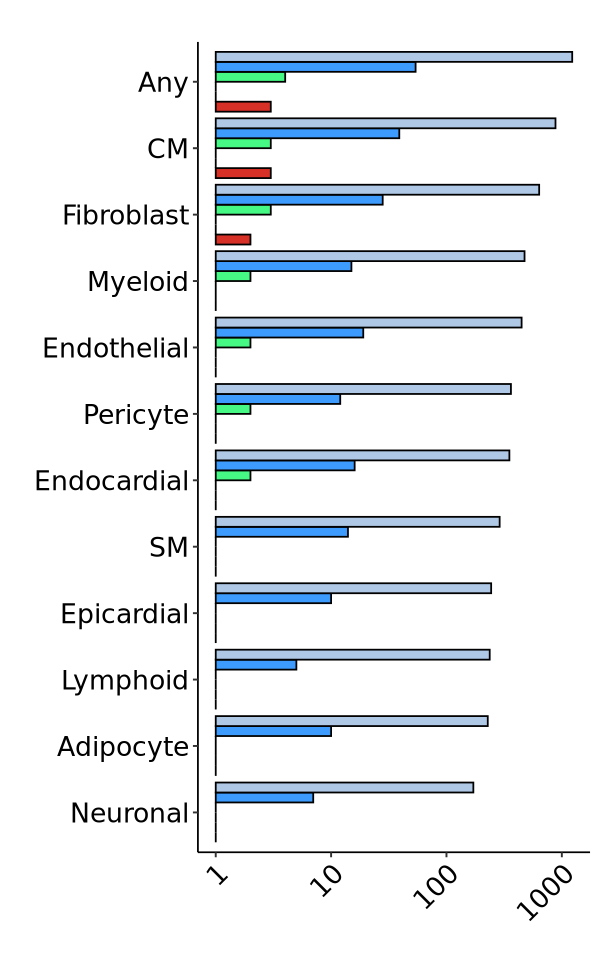

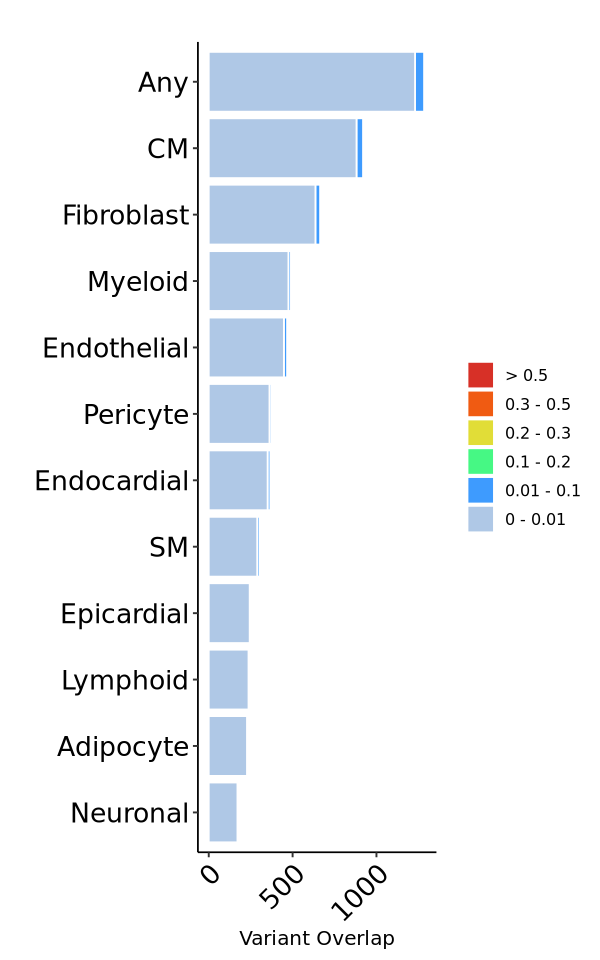

In [1032]:
plot.data = summary_data_CT

gg <- ggplot(plot.data, 
             aes(x = celltype.collapse, 
                 y = variant_overlap,  # Keep raw values in the y aesthetic
                 fill = PP_range)) +
  geom_bar(stat = "identity", color = "black", width = 0.9, position = position_dodge()) +
  scale_fill_manual(values = custom_colors) +  # Use Turbo colors
  labs(title = "", x = "", y = "") +
  scale_y_continuous(
    trans = "log10",  # Log2 transformation applied
    breaks = c(1, 10, 100, 1000)) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "none"
  ) +
  coord_flip()
gg

# Generate plot with custom colors
gg <- ggplot(plot.data, 
             aes(x = celltype.collapse, 
                 y = variant_overlap,  
                 fill = PP_range)) +
  geom_bar(stat = "identity", color = "white", width = 0.9) +
  scale_fill_manual(values = custom_colors) +  # Use Turbo colors
  labs(title = "", x = "", y = "Variant Overlap") +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "right"  
  ) +
  coord_flip()

gg

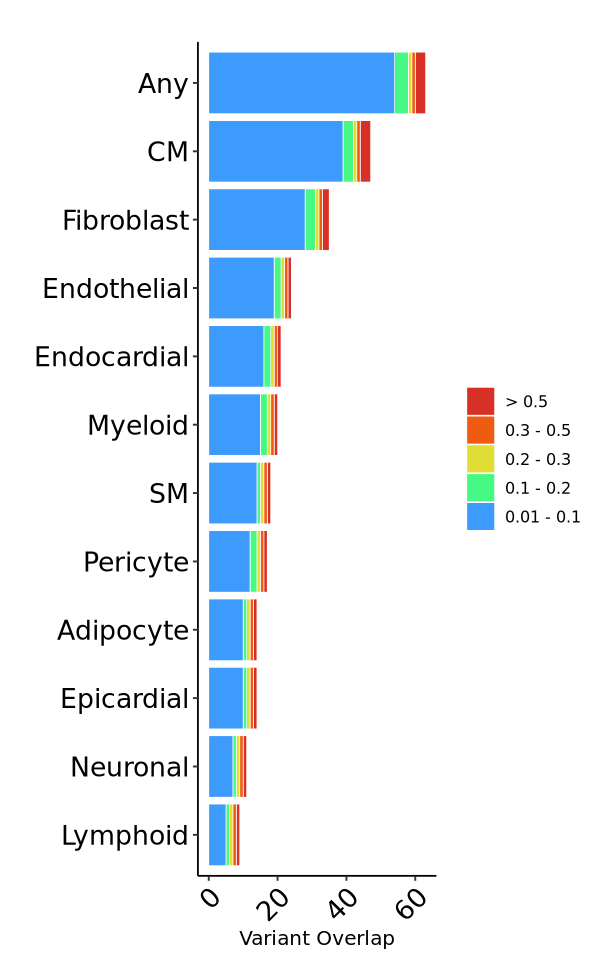

In [1035]:
# Create total overlap information
celltype_order <-  summary_data_CT %>%
  dplyr::filter(PP_range != "0 - 0.01") %>%
  dplyr::group_by(celltype.collapse) %>%
  dplyr::summarize(total_variant_overlap = sum(variant_overlap), .groups = "drop") %>%
  dplyr::arrange(desc(total_variant_overlap)) %>%  # Sort by total overlap (highest first)
  dplyr::pull(celltype.collapse)  # Extract as a character vector


plot.data = summary_data_CT %>%
            dplyr::filter(PP_range != "0 - 0.01") %>%
            dplyr::mutate(celltype.collapse = factor(celltype.collapse, 
                                                            levels = rev(celltype_order)))

options(repr.plot.width=5, repr.plot.height=8)
# Generate plot with custom colors
gg <- ggplot(plot.data, 
             aes(x = celltype.collapse, 
                 y = variant_overlap,  
                 fill = PP_range)) +
  geom_bar(stat = "identity", color = "white", size = .2, width = 0.9) +
  scale_fill_manual(values = custom_colors) +  # Use Turbo colors
  labs(title = "", x = "", y = "Variant Overlap") +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "right"  
  ) +
  coord_flip()

gg

In [1036]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "80Loci_Celltype_intersection_PPA1pct.pdf"),
                            width = 5, height = 8, 
                            plot = gg, device = "pdf")

### Use only 2 PPA breaks breaks 

In [2855]:
# Assign colors to PP_range categories
custom_colors <- c(
"> 0.3" = "#54278F", 
"0.1 - 0.3" = "#756BB1",
"0.01 - 0.1" = "#CBC9E2",
"0 - 0.01" = "#F2F0F7"
)

In [2856]:
# Summarize for each CT
summary_data_CT = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::mutate(
        PP_range = dplyr::case_when(
          PPA > 0.3 ~ "> 0.3",
          PPA > 0.1 & PPA <= 0.3 ~ "0.1 - 0.3",
          PPA > 0.01 & PPA <= 0.1 ~ "0.01 - 0.1",
          PPA <= 0.01 ~ "0 - 0.01",
          TRUE ~ "Other"
        )) %>%
  dplyr::group_by(celltype.collapse, PP_range) %>%
  dplyr::summarize(
    variant_overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop") %>%
 dplyr::mutate(PP_range = factor(PP_range, levels = c("> 0.3",
                                                      "0.1 - 0.3",
                                                      "0.01 - 0.1",
                                                      "0 - 0.01")))
# Summarize for any ct
summary_data_any = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::mutate(
        PP_range = dplyr::case_when(
          PPA > 0.3 ~ "> 0.3",
          PPA > 0.1 & PPA <= 0.3 ~ "0.1 - 0.3",
          PPA > 0.01 & PPA <= 0.1 ~ "0.01 - 0.1",
          PPA <= 0.01 ~ "0 - 0.01",
          TRUE ~ "Other"
        )) %>%
  dplyr::group_by(PP_range) %>%
  dplyr::summarize(
    variant_overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop") %>%
 dplyr::mutate(PP_range = factor(PP_range, levels = c("> 0.3",
                                                      "0.1 - 0.3",
                                                      "0.01 - 0.1",
                                                      "0 - 0.01"))) %>%
 dplyr::mutate(celltype.collapse = "Any")  %>%
 dplyr::select(celltype.collapse,
               PP_range, 
               variant_overlap,
               signal.overlap,
               peaks.on.variant
              )

# Create total overlap information
celltype_order <-  summary_data_CT %>%
  dplyr::group_by(celltype.collapse) %>%
  dplyr::summarize(total_variant_overlap = sum(variant_overlap), .groups = "drop") %>%
  dplyr::arrange(desc(total_variant_overlap)) %>%  # Sort by total overlap (highest first)
  dplyr::pull(celltype.collapse)  # Extract as a character vector
celltype_order = c("Any", celltype_order)

In [2857]:
# put together
summary_data_CT = rbind(summary_data_any, summary_data_CT)

summary_data_CT = dplyr::mutate(summary_data_CT, 
                                 celltype.collapse = factor(celltype.collapse, 
                                                            levels = rev(celltype_order)))
summary_data_CT <- summary_data_CT %>%
  mutate(variant_overlap = ifelse(variant_overlap == 0, 1, variant_overlap))

In [2861]:
summary_data_CT %>%
  dplyr::filter(PP_range != "0 - 0.01") %>%
  dplyr::group_by(celltype.collapse)

celltype.collapse PP_range   variant_overlap signal.overlap peaks.on.variant
1  Any               0.01 - 0.1 54              38             50              
2  Any               0.1 - 0.3   5               5              5              
3  Any               > 0.3       4               4              4              
4  Adipocyte         0.01 - 0.1 10               9              9              
5  Adipocyte         > 0.3       2               2              2              
6  CM                0.01 - 0.1 39              28             35              
7  CM                0.1 - 0.3   4               4              4              
8  CM                > 0.3       4               4              4              
9  Endocardial       0.01 - 0.1 16              15             15              
10 Endocardial       0.1 - 0.3   2               2              2              
11 Endocardial       > 0.3       2               2              2              
12 Endothelial       0.01 - 0.1 19              16             17              
13 Endothelial       0.1 - 0.3   2               2              2              
14 Endothelial       > 0.3       2               2              2              
15 Epicardial        0.01 - 0.1 10              10             10              
16 Epicardial        0.1 - 0.3   1               1              1              
17 Epicardial        > 0.3       1               1              1              
18 Fibroblast        0.01 - 0.1 28              23             25              
19 Fibroblast        0.1 - 0.3   3               3              3              
20 Fibroblast        > 0.3       3               3              3              
21 Lymphoid          0.01 - 0.1  5               5              5              
22 Myeloid           0.01 - 0.1 15              12             13              
23 Myeloid           0.1 - 0.3   2               2              2              
24 Myeloid           > 0.3       2               2              2              
25 Neuronal          0.01 - 0.1  7               7              7              
26 Neuronal          > 0.3       1               1              1              
27 Pericyte          0.01 - 0.1 12              11             11              
28 Pericyte          0.1 - 0.3   2               2              2              
29 Pericyte          > 0.3       1               1              1              
30 SM                0.01 - 0.1 14              13             13              
31 SM                0.1 - 0.3   1               1              1              
32 SM                > 0.3       2               2              2

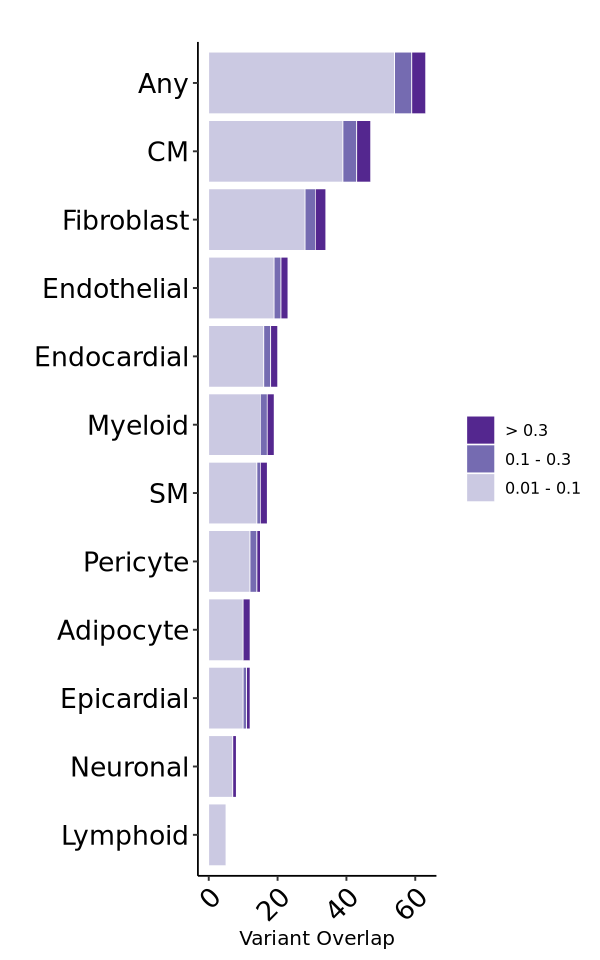

In [2862]:
#### Create total overlap information
celltype_order <-  summary_data_CT %>%
  dplyr::filter(PP_range != "0 - 0.01") %>%
  dplyr::group_by(celltype.collapse) %>%
  dplyr::summarize(total_variant_overlap = sum(variant_overlap), .groups = "drop") %>%
  dplyr::arrange(desc(total_variant_overlap)) %>%  # Sort by total overlap (highest first)
  dplyr::pull(celltype.collapse)  # Extract as a character vector


plot.data = summary_data_CT %>%
            dplyr::filter(PP_range != "0 - 0.01") %>%
            dplyr::mutate(celltype.collapse = factor(celltype.collapse, 
                                                            levels = rev(celltype_order)))

options(repr.plot.width=5, repr.plot.height=8)
# Generate plot with custom colors
gg <- ggplot(plot.data, 
             aes(x = celltype.collapse, 
                 y = variant_overlap,  
                 fill = PP_range)) +
  geom_bar(stat = "identity", color = "white", size = .2, width = 0.9) +
  scale_fill_manual(values = custom_colors) +  # Use Turbo colors
  labs(title = "", x = "", y = "Variant Overlap") +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "right"  
  ) +
  coord_flip()

gg

In [1326]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "80Loci_Celltype_intersection_PPA1pct_3breaks.pdf"),
                            width = 5, height = 8, 
                            plot = gg, device = "pdf")

## Plot like we did for the fingen traits

In [2822]:
celltypes.plot = c("aCM", "vCM")
states.plot = c("ATAC", "Open", "Active")
variant.plot = "Hermes80Loci"
# Colors
cols <- c("#036EB8", "#cd5c5c", "#c0c0c0", "#008000", "#ffc800", '#66cdaa')
names(cols) <- c("ATAC", "Repressive", "Unknown", "Open", "Weak", "Active")

In [2823]:
summary_data_CT = overlap_data.all %>%
  dplyr::filter(chromSTATE %in% states.plot & celltype %in% celltypes.plot)%>%
  dplyr::group_by(celltype, chromSTATE) %>%
  dplyr::summarize(
                    variant_overlap = length(unique(rsID)),
                    signal.overlap = length(unique(Locus)),
                    peaks.on.variant = length(unique(Peak_ID)),
                    .groups = "drop")
head(summary_data_CT)

celltype chromSTATE variant_overlap signal.overlap peaks.on.variant
1 vCM      ATAC       816             55             586             
2 vCM      Open        70             21              57             
3 vCM      Active     448             48             321             
4 aCM      ATAC       733             56             537             
5 aCM      Open        64             20              47             
6 aCM      Active     485             52             361

In [2824]:
# Summarize for any ct
summary_data_any = overlap_data.all %>%
  dplyr::filter(chromSTATE %in% states.plot & celltype %in% celltypes.plot)%>%
  dplyr::group_by(chromSTATE) %>%
  dplyr::summarize(
                    variant_overlap = length(unique(rsID)),
                    signal.overlap = length(unique(Locus)),
                    peaks.on.variant = length(unique(Peak_ID)),
                    .groups = "drop") %>%
 dplyr::mutate(celltype = "Any")  %>%
 dplyr::select(celltype,
               chromSTATE,
               variant_overlap,
               signal.overlap,
               peaks.on.variant)

head(summary_data_any)

celltype chromSTATE variant_overlap signal.overlap peaks.on.variant
1 Any      ATAC       928             58             666             
2 Any      Open       116             28              91             
3 Any      Active     548             53             402

In [2825]:
# put together
summary_data_CT = rbind(summary_data_any, summary_data_CT)

summary_data_CT = dplyr::mutate(summary_data_CT, 
                                 celltype = factor(celltype, 
                                                    levels = c("Any", celltypes.plot)))
summary_data_CT 

celltype chromSTATE variant_overlap signal.overlap peaks.on.variant
1 Any      ATAC       928             58             666             
2 Any      Open       116             28              91             
3 Any      Active     548             53             402             
4 vCM      ATAC       816             55             586             
5 vCM      Open        70             21              57             
6 vCM      Active     448             48             321             
7 aCM      ATAC       733             56             537             
8 aCM      Open        64             20              47             
9 aCM      Active     485             52             361

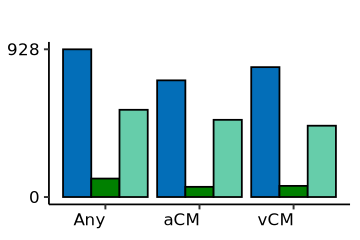

In [2826]:
options(repr.plot.width=3, repr.plot.height=2)
# Plot all celltypes
gg = ggplot(summary_data_CT, aes(x = celltype, y = variant_overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size +
  scale_y_continuous(
    breaks = c(0, max(summary_data_CT$variant_overlap)))+
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "none"
  )

gg

In [2827]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         gsub(" ", "_", variant.plot), "_variants.pdf"),
                            width = 3, height = 2, 
                            plot = gg, device = "pdf")

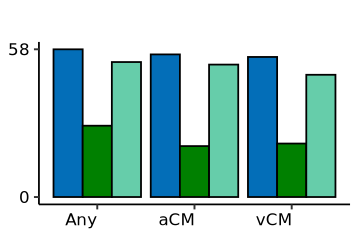

In [2828]:
options(repr.plot.width=3, repr.plot.height=2)
# Plot all celltypes
gg = ggplot(summary_data_CT, aes(x = celltype, y = signal.overlap, fill = chromSTATE)) +
  geom_bar(stat = "identity", color = "black", position = position_dodge()) +
  scale_fill_manual(values = cols) +  # Use custom colors
  labs(title = "") +
  theme_pubr() +  # Minimal theme with base size +
  scale_y_continuous(
    breaks = c(0, max(summary_data_CT$signal.overlap)))+
  theme(
    axis.title = element_blank(),  # Remove axis titles
    axis.text.x = element_text(size = 10, hjust = 1),
    axis.text.y = element_text(size = 10),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.position = "none"
  )

gg

In [2829]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         gsub(" ", "_", variant.plot), "_signals.pdf"),
                            width = 3, height = 2, 
                            plot = gg, device = "pdf")

## Heatmap approach

In [935]:
### All variants by PPA range 

In [951]:
library(ggplot2)
library(NMF)
library(reshape2)
library(doParallel)

In [946]:
df_snp <- overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::select(rsID, celltype.collapse, PPA) %>%  # Retain PPA for classification
    distinct(rsID, celltype.collapse, .keep_all = TRUE) %>%
    dplyr::mutate(
        value = dplyr::case_when(
          PPA > 0.5 ~ 6,
          PPA > 0.3 & PPA <= 0.5 ~ 5,
          PPA > 0.2 & PPA <= 0.3 ~ 4,
          PPA > 0.1 & PPA <= 0.2 ~ 3,
          PPA > 0.01 & PPA <= 0.1 ~ 2,
          PPA <= 0.01 ~ 1,
          TRUE ~ NA_real_  # Ensuring numeric type for all cases
        )
    ) %>%  # Add missing pipe
    pivot_wider(names_from = celltype.collapse, values_from = value, values_fill = list(value = 0))  # Ensure pivot_wider runs properly

In [995]:
nrow(df_snp)
length(unique(overlap_data.all$rsID))

[1] 1293

[1] 1293

In [947]:
# Convert to matrix (removing rsID column ad PPA column)
mat <- as.matrix(df_snp[, -c(1,2)])
rownames(mat) <- df_snp$rsID

In [954]:
# Test multiple k values (e.g., 2 to 15)
rank_estimate <- nmf(mat, 5:11, nrun=30, seed=1234, .options = "P30", .pbackend = "doParallel")

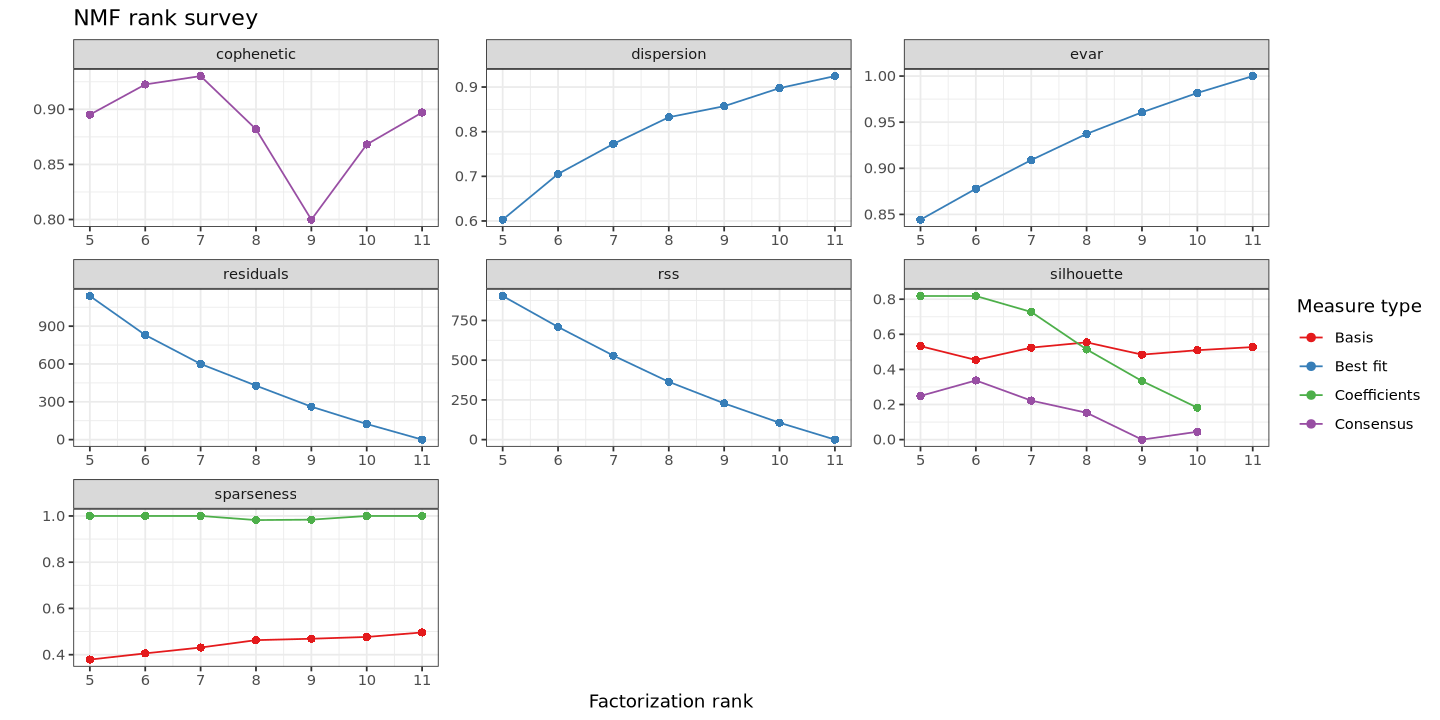

In [955]:
options(repr.plot.width=12, repr.plot.height=6)
# Plot cophenetic coefficient
plot(rank_estimate)

In [956]:
# Apply NMF to find structure (rank = 3 is adjustable)
nmf_result_B <- nmf(mat, 7, nrun=100, seed=1234, method="brunet", .options = "P30", .pbackend = "doParallel")

nmf_result_L <- nmf(mat, 7, nrun=100, seed=1234, method="lee", .options = "P30", .pbackend = "doParallel")

nmf_result_N <- nmf(mat, 7, nrun=100, seed=1234, method="nsNMF", .options = "P30", .pbackend = "doParallel")


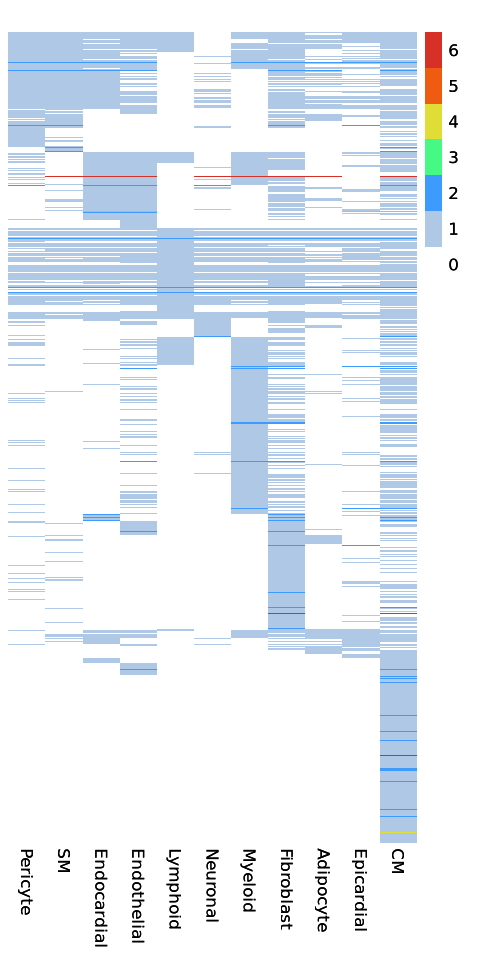

In [1041]:
# brunet
nmf_result = nmf_result_B

# Basis matrix (W): Features × Factors
W <- basis(nmf_result)
# Coefficient matrix (H): Factors × Samples
H <- coef(nmf_result)

# Sort rows and columns by the dominant factor
row_order <- order(max.col(W))  # Order features by their dominant factor
col_order <- order(max.col(t(H)))  # Order samples by their dominant factor

# Reorder the matrix
mat_reordered <- mat[row_order, col_order]

# Get plasma palette (for values 1-6)
colors <- viridis(n = 6, option = "turbo")
colors[1] <- "#AFC8E6"
colors[6] <- "#D73027"

# Define custom color scheme (White for 0, Plasma for 1-6)
custom_colors <- c("#FFFFFF", colors)  

# Define breaks (ensures exact mapping of 0-6)
breaks_vector <- seq(-0.5, 6.5, by = 1)

options(repr.plot.width=4, repr.plot.height=8)

# Generate heatmap
gg = pheatmap(
  mat_reordered, 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "none",         # No scaling
  color = custom_colors,  # Use Turbo palette with white for 0
  breaks = breaks_vector, # Ensures exact mapping to 0-6 values
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = FALSE   # Hide row names (SNP labels)
)

gg

In [1042]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "80Loci_Celltype_intersection_Hetmap_PPA.pdf"),
                            width = 4, height = 8, 
                            plot = gg, device = "pdf")

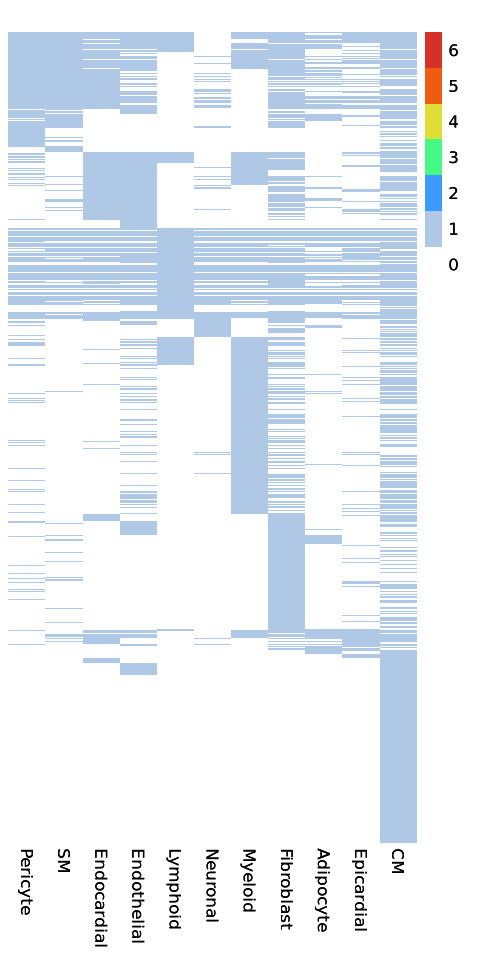

In [1329]:
# brunet
nmf_result = nmf_result_B

# Basis matrix (W): Features × Factors
W <- basis(nmf_result)
# Coefficient matrix (H): Factors × Samples
H <- coef(nmf_result)

# Sort rows and columns by the dominant factor
row_order <- order(max.col(W))  # Order features by their dominant factor
col_order <- order(max.col(t(H)))  # Order samples by their dominant factor

# Reorder the matrix
mat_reordered <- mat[row_order, col_order]

# binarize
mat_reordered <- ifelse(mat_reordered > 0, 1, 0)

# Get plasma palette (for values 1-6)
colors <- viridis(n = 6, option = "turbo")
colors[1] <- "#AFC8E6"
colors[6] <- "#D73027"

# Define custom color scheme (White for 0, Plasma for 1-6)
custom_colors <- c("#FFFFFF", colors)  

# Define breaks (ensures exact mapping of 0-6)
breaks_vector <- seq(-0.5, 6.5, by = 1)

options(repr.plot.width=4, repr.plot.height=8)

# Generate heatmap
gg = pheatmap(
  mat_reordered, 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "none",         # No scaling
  color = custom_colors,  # Use Turbo palette with white for 0
  breaks = breaks_vector, # Ensures exact mapping to 0-6 values
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = FALSE   # Hide row names (SNP labels)
)

gg

In [1044]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "80Loci_Celltype_intersection_Hetmap_PPA_Binarized.pdf"),
                            width = 4, height = 8, 
                            plot = gg, device = "pdf")

# Unique variants

In [989]:
variant_counts <- overlap_data.all %>%
  distinct(rsID, celltype.collapse) %>%
  group_by(rsID) %>%
  summarize(n_celltypes = n(), .groups = "drop")

overlap_data_joined <- overlap_data.all %>%
  left_join(variant_counts, by = "rsID")

summary_data_CT <- overlap_data_joined %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(celltype.collapse, chromSTATE) %>%
  dplyr::summarize(
    # Count exclusive variants (those only observed in one cell type)
    exclusive_variant_overlap = length(unique(rsID[n_celltypes == 1])),
    # Count shared variants (those that appear in more than one cell type)
    shared_variant_overlap    = length(unique(rsID[n_celltypes > 1])),
    signal.overlap            = length(unique(Locus)),
    peaks.on.variant          = length(unique(Peak_ID)),
    .groups = "drop"
  )

summary_data_long <- summary_data_CT %>%
  pivot_longer(
    cols = c(exclusive_variant_overlap, shared_variant_overlap),
    names_to = "variant_category",
    values_to = "variant_overlap"
  )

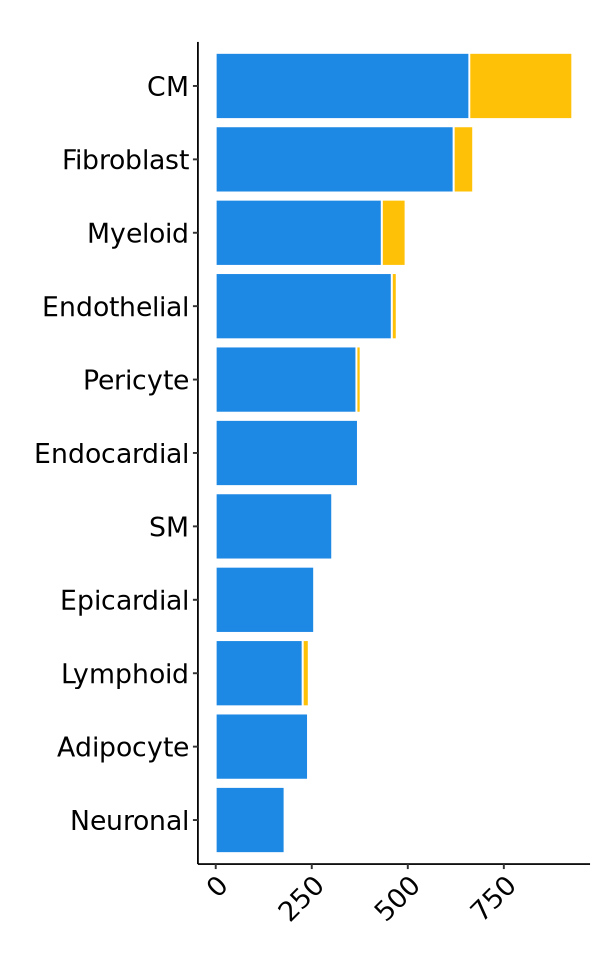

In [990]:
options(repr.plot.width=5, repr.plot.height=8)
gg <- ggplot(summary_data_long, 
             aes(x = reorder(celltype.collapse, +variant_overlap), 
                 y = variant_overlap, 
                 fill = variant_category)) +
  geom_bar(stat = "identity", color = "white", width = 0.9) +
  scale_fill_manual(values = c(
    "exclusive_variant_overlap" = "#FFC107", 
    "shared_variant_overlap" = "#1E88E5"
  )) +
  labs(title = "", x = "", y = "") +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "none"
  ) +
  coord_flip()
gg

In [996]:
variant_counts <- overlap_data.all %>%
  distinct(rsID, celltype.collapse) %>%
  group_by(rsID) %>%
  summarize(n_celltypes = n(), .groups = "drop")

overlap_data_joined <- overlap_data.all %>%
  left_join(variant_counts, by = "rsID")

summary_data_CT <- overlap_data_joined %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::filter(PPA > 0.01) %>%
  dplyr::group_by(celltype.collapse, chromSTATE) %>%
  dplyr::summarize(
    # Count exclusive variants (those only observed in one cell type)
    exclusive_variant_overlap = length(unique(rsID[n_celltypes == 1])),
    # Count shared variants (those that appear in more than one cell type)
    shared_variant_overlap    = length(unique(rsID[n_celltypes > 1])),
    signal.overlap            = length(unique(Locus)),
    peaks.on.variant          = length(unique(Peak_ID)),
    .groups = "drop"
  )

summary_data_long <- summary_data_CT %>%
  pivot_longer(
    cols = c(exclusive_variant_overlap, shared_variant_overlap),
    names_to = "variant_category",
    values_to = "variant_overlap"
  )

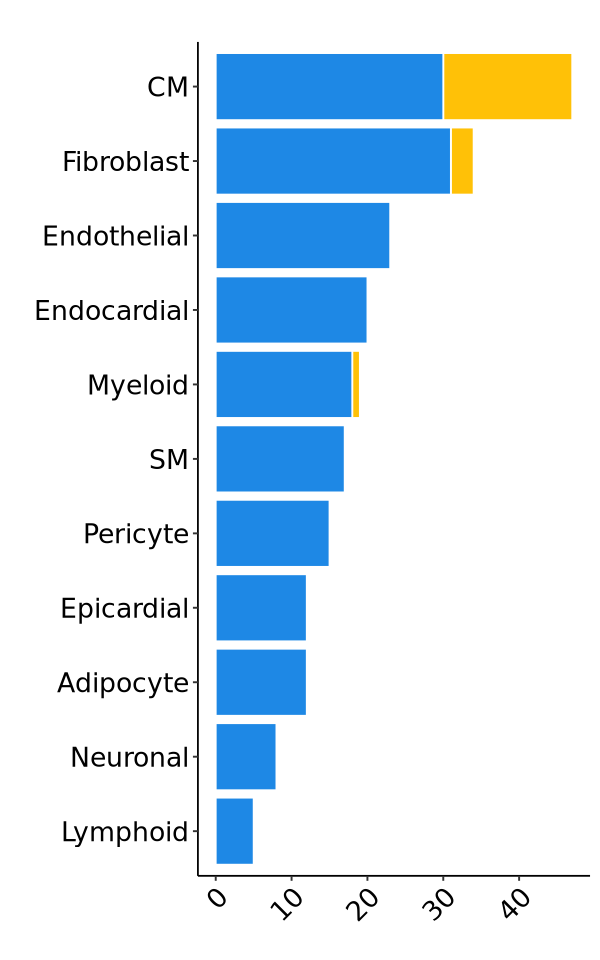

In [997]:
options(repr.plot.width=5, repr.plot.height=8)
gg <- ggplot(summary_data_long, 
             aes(x = reorder(celltype.collapse, +variant_overlap), 
                 y = variant_overlap, 
                 fill = variant_category)) +
  geom_bar(stat = "identity", color = "white", width = 0.9) +
  scale_fill_manual(values = c(
    "exclusive_variant_overlap" = "#FFC107", 
    "shared_variant_overlap" = "#1E88E5"
  )) +
  labs(title = "", x = "", y = "") +
  theme_pubr() +
  theme(
    axis.text.x = element_text(size = 16, angle = 45, hjust = 1),
    axis.text.y = element_text(size = 16),
    plot.title = element_text(size = 14, face = "bold", hjust = 0.5),
    legend.title = element_blank(),  
    legend.position = "none"
  ) +
  coord_flip()
gg

In [998]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "vCM_80Loci_Celltype_intersection_Exclusivity_PPA1.pdf"),
                            width = 5, height = 8, 
                            plot = gg, device = "pdf")

# Locus coverage

In [1391]:
head(overlap_data.all, n=2)

seqnames start   end     width strand rsID      PPA          Locus  
1 chr1     2273350 2273351 2     *      rs4648819 0.0050064528 locus_1
2 chr1     2189678 2189679 2     *      rs2503701 0.0008834679 locus_1
  Peak_ID              celltype chromSTATE Celltype_Peak_ID         
1 chr1-2273347-2273627 vCM      Active     vCM--chr1-2273347-2273627
2 chr1-2189541-2189841 vCM      Active     vCM--chr1-2189541-2189841
  celltype.collapse
1 CM               
2 CM

In [1676]:
df_signal = overlap_data.all %>%
    dplyr::filter(chromSTATE == "ATAC") %>%
    dplyr::group_by(celltype, Locus) %>%
    dplyr::summarise(total.PPA = sum(PPA, na.rm = TRUE)) %>%
    ungroup() %>%
    pivot_wider(names_from = celltype, 
                values_from = total.PPA, 
                values_fill = list(total.PPA = 0))

`summarise()` has grouped output by 'celltype'. You can override using the `.groups` argument.


In [1719]:
# Convert to matrix (removing rsID column ad PPA column)
mat <- as.matrix(df_signal[, -c(1)])
rownames(mat) <- df_signal$Locus

In [1720]:
# Yang way of doing it - super easy
max_indices <- max.col(mat)
permutation_vector <- order(max_indices)
smat <- mat[permutation_vector, ]

In [1721]:
# Identify loci based on CM conditions
both_cm_zero <- df_signal$Locus[df_signal$vCM == 0 & df_signal$aCM == 0]  # Both 0
vcm_zero <- df_signal$Locus[df_signal$vCM == 0 & df_signal$aCM != 0]  # Only vCM 0
acm_zero <- df_signal$Locus[df_signal$vCM != 0 & df_signal$aCM == 0]  # Only aCM 0

# Compute the ordering for all other rows (not CM == 0 cases)
max_indices <- max.col(mat)
permutation_vector <- order(max_indices)
sorted_rows <- rownames(mat)[permutation_vector]  # Sorted row names

# Extract non-CM zero rows
rows_to_keep <- setdiff(sorted_rows, c(both_cm_zero, vcm_zero, acm_zero))
final_order <- c(rows_to_keep, acm_zero,  vcm_zero, both_cm_zero)

# Apply new ordering
smat <- mat[final_order, ]

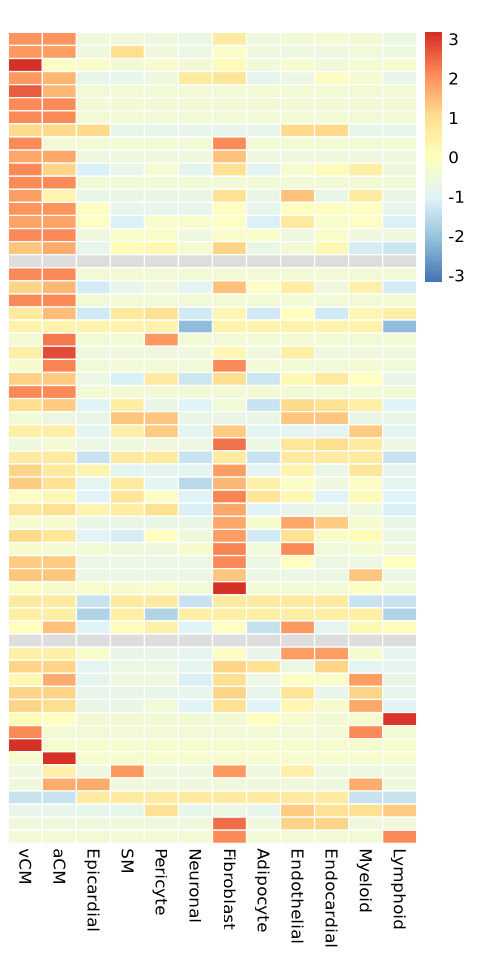

In [1723]:
pheatmap(
  smat, 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "row",         # No internal scaling to preserve 0-1 values
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = FALSE
)

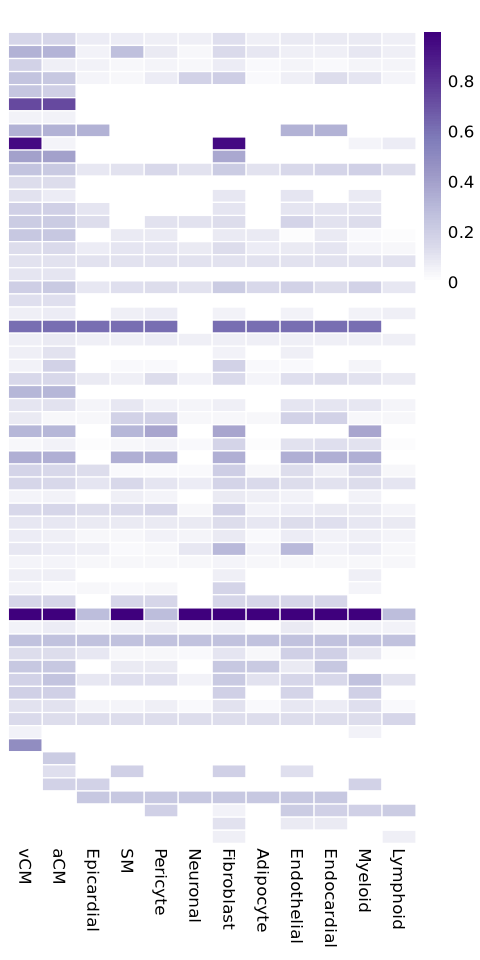

In [1724]:
# Generate heatmap
custom_turbo <-  colorRampPalette(c("white", brewer.pal(9, "Purples")[3:9]))(101)

pheatmap(
  sqrt(smat), 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "none",         # No internal scaling to preserve 0-1 values
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = FALSE,   # Hide row names (SNP labels)
  color = custom_turbo
)

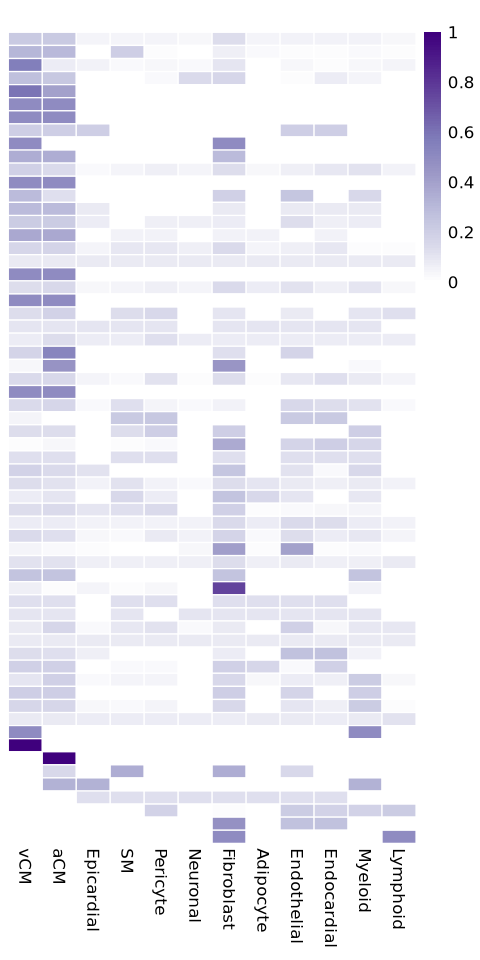

In [1726]:
# Normalize each row so it sums to 1, handling zero-sum rows implicitly
row_sum1 <- function(x) {
  x / sum(x)  # If sum is 0, R will return NaN, which we fix below
}

# Apply normalization row-wise
smat_scaled <- t(apply(smat, 1, row_sum1))

# Generate heatmap
pheatmap(
  smat_scaled, 
  cluster_rows = FALSE,
  cluster_cols = FALSE,
  scale = "none",
  border_color = "white",
  main = "",
  show_rownames = FALSE,
  color = custom_turbo
)

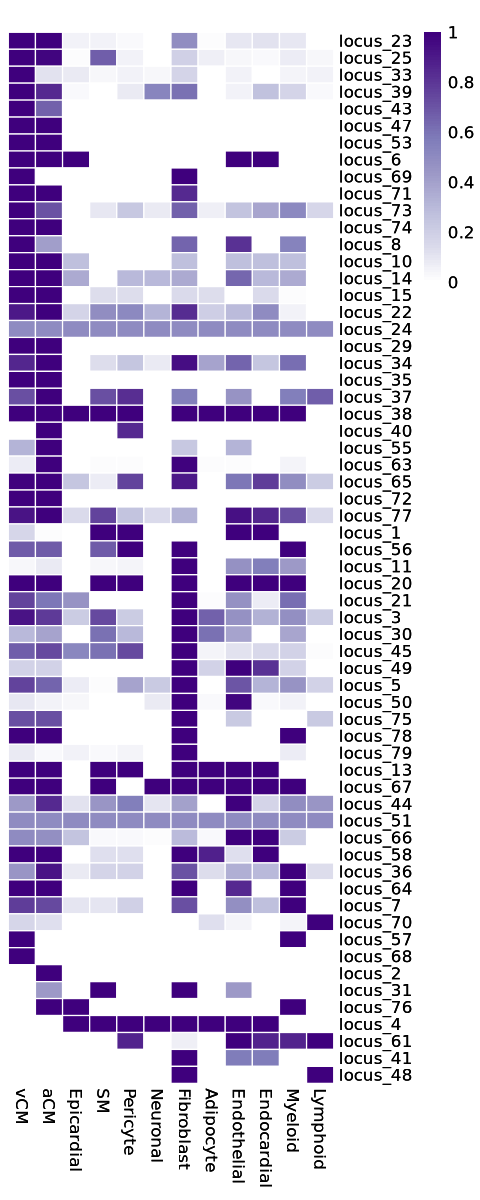

In [1851]:
# Min-Max Normalize Each Row to [0,1]
row_minmax <- function(x) {
  rescale(x, to = c(0, 1))  # Directly scale values between 0 and 1
}

# Apply normalization row-wise
smat_scaled <- t(apply(smat, 1, row_minmax))

options(repr.plot.width=4, repr.plot.height=10)
# Generate heatmap
gg = pheatmap(
  smat_scaled, 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "none",         # Already normalized manually
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = TRUE,
  color = custom_turbo
)
gg

In [2626]:
head(smat)

vCM        aCM         Epicardial  SM          Pericyte    Neuronal   
locus_23 0.02581026 0.025706951 0.005310777 0.005360960 0.004678406 0.004230896
locus_25 0.10730941 0.104495278 0.003216027 0.071604508 0.006750133 0.001167726
locus_33 0.03223814 0.004054687 0.003018076 0.001417777 0.002279256 0.001445240
locus_39 0.06383596 0.054064496 0.002069433 0.001328661 0.006130797 0.034163860
locus_43 0.05688171 0.037378878 0.000000000 0.000000000 0.000000000 0.000000000
locus_47 0.54352100 0.543521002 0.000000000 0.000000000 0.000000000 0.000000000
         Fibroblast  Adipocyte    Endothelial Endocardial  Myeloid    
locus_23 0.014822222 0.0045652854 0.006258265 0.0066566369 0.006244516
locus_25 0.021237527 0.0080051164 0.004605323 0.0035242132 0.008762075
locus_33 0.005945551 0.0004483735 0.002094811 0.0006184065 0.001764672
locus_39 0.039147153 0.0007407716 0.004345563 0.0171103765 0.011673156
locus_43 0.000000000 0.0000000000 0.000000000 0.0000000000 0.000000000
locus_47 0.000000000 0.0000000000 0.000000000 0.0000000000 0.000000000
         Lymphoid   
locus_23 0.004328936
locus_25 0.004405866
locus_33 0.002300913
locus_39 0.002069433
locus_43 0.000000000
locus_47 0.000000000

In [1852]:
# Yang way of doing it - super easy
max_indices <- max.col(smat_scaled)
permutation_vector <- order(max_indices)
smat_scaled <- smat_scaled[permutation_vector, ]

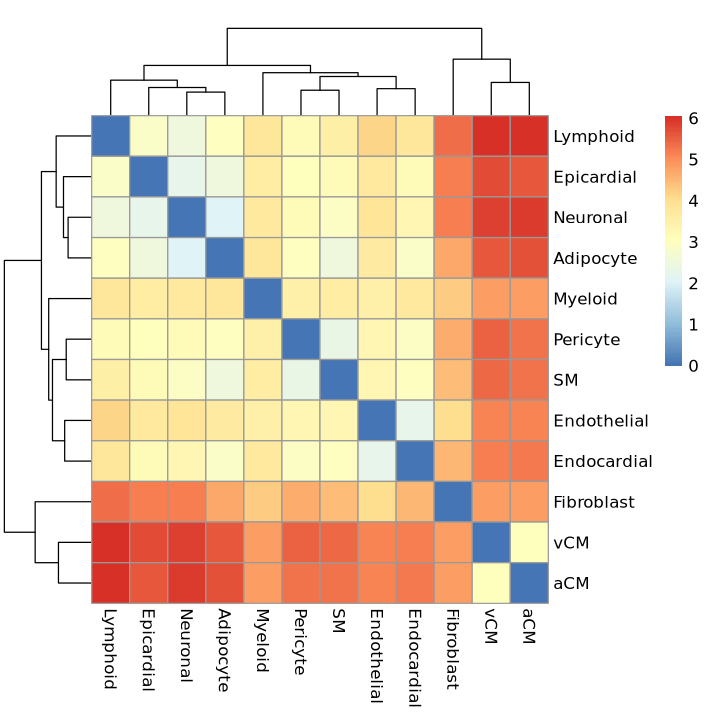

In [2053]:
options(repr.plot.width=6, repr.plot.height=6)
# Convert distance object to a matrix
dist_matrix <- as.matrix(dist(t(smat_scaled), method = "euclidean"))

# Generate heatmap with legend on the right
pheatmap(dist_matrix, 
         main = "",
         clustering_distance_rows = "euclidean",
         clustering_distance_cols = "euclidean",
         clustering_method = "complete",
         legend = TRUE)  

In [2054]:
# Define the desired column order (diagonal from aCM to Fibroblast)
column_order <- c("vCM","aCM","Fibroblast",
                  "Endothelial", "Endocardial", 
                 "Pericyte","SM",
                  "Myeloid",
                  "Neuronal","Adipocyte","Epicardial",
                  "Lymphoid")

In [2059]:
# Reorder columns to match desired diagonal sorting
smat_scaled <- smat_scaled[, column_order]

# Compute max column index based on the reordered matrix
max_indices <- max.col(smat_scaled, ties.method = "last") 
# Sort rows based on max column index
permutation_vector <- order(max_indices)
smat_scaled <- smat_scaled[permutation_vector, ]

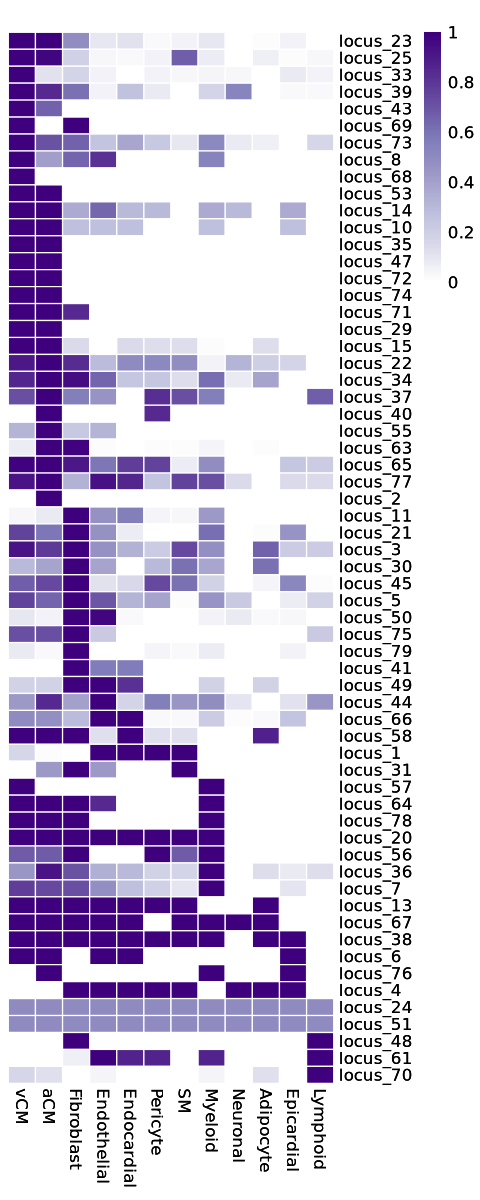

In [2060]:
options(repr.plot.width=4, repr.plot.height=10)
# Generate heatmap
gg = pheatmap(
  smat_scaled, 
  cluster_rows = FALSE,   # Keep NMF ordering
  cluster_cols = FALSE,   # Keep original cell type order
  scale = "none",         # Already normalized manually
  border_color = "white",  # Keep gridlines for visibility
  main = "",
  show_rownames = TRUE,
  color = custom_turbo
)
gg

In [2126]:
# Save locus order for later - visualization
loci_order = str_remove(rownames(smat_scaled), "locus_")

In [2061]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", 
                         "80Loci_Celltype_intersection_Hetmap_LocusPPA.pdf"),
                            width = 4, height = 10, 
                            plot = gg, device = "pdf")

# Integration with Differential ATAC

In [124]:
ATAC.DESEQ.path = "/nfs/lab/projects/mega_heart/FNIH/Integration/DESEQ_assets/4chambers_DESEQ2_ATAC.dds.res"

In [125]:
ATAC.DESEQ = read.table(ATAC.DESEQ.path,
                        sep = '\t', header = TRUE)

In [126]:
ATAC.DESEQ = ATAC.DESEQ %>%
    dplyr::filter(contrast == "HF_vs_NON_HF") %>%
    dplyr::mutate(ATAC_DESeq2 = dplyr::case_when(
                      ATAC_L2FC > 0 & ATAC_Padj < 0.1 ~ "UP",
                      ATAC_L2FC < 0 & ATAC_Padj < 0.1 ~ "DOWN",       
                      TRUE ~ "NS")) %>%
    dplyr::mutate(Celltype_Peak_ID = paste0(celltype, "--", ATAC_ID)) %>%
    dplyr::select(Celltype_Peak_ID, contrast, ATAC_DESeq2, ATAC_L2FC)

In [127]:
overlap_data.DIFF = overlap_data.all %>%
  left_join(ATAC.DESEQ, by = "Celltype_Peak_ID") %>%
  tidyr::replace_na(list(ATAC_DESeq2 = "NS")) %>%
  tidyr::replace_na(list(contrast = "HF_vs_NON_HF"))

In [128]:
overlap_data.DIFF %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::filter(PPA > 0.01) %>%
  dplyr::group_by(celltype, chromSTATE, ATAC_DESeq2) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    .groups = "drop" 
) %>%
  dplyr::filter(ATAC_DESeq2 == "UP")

celltype    chromSTATE ATAC_DESeq2 variant.overlap signal.overlap
1 vCM         ATAC       UP          4               4             
2 aCM         ATAC       UP          1               1             
3 Fibroblast  ATAC       UP          2               1             
4 Endocardial ATAC       UP          1               1             
5 Myeloid     ATAC       UP          1               1             
  peaks.on.variant
1 4               
2 1               
3 1               
4 1               
5 1

In [129]:
head(overlap_data.DIFF, n=2)

seqnames start   end     width strand rsID      PPA          Locus  
1 chr1     2273350 2273351 2     *      rs4648819 0.0050064528 locus_1
2 chr1     2189678 2189679 2     *      rs2503701 0.0008834679 locus_1
  Peak_ID              celltype chromSTATE Celltype_Peak_ID         
1 chr1-2273347-2273627 vCM      Active     vCM--chr1-2273347-2273627
2 chr1-2189541-2189841 vCM      Active     vCM--chr1-2189541-2189841
  celltype.collapse contrast     ATAC_DESeq2 ATAC_L2FC 
1 CM                HF_vs_NON_HF NS           0.4287717
2 CM                HF_vs_NON_HF NS          -0.3882666

In [ ]:
# Save table
write.table(data.all.hg38,
            file = paste("/nfs/lab/tscc/luca/MEGA_Heart/Finrich/Inputs/chromBP_input/Hermes_80LociHF_Hg38.txt", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

# integrate with - HiCloops

In [130]:
# Lets just integrate with any loop

In [131]:
HiC_loops.path = "/nfs/lab/tscc/luca/MEGA_Heart/HiC_Loops/All_25kbloops_TSS_annotated_Filtered.txt"


In [132]:
# The ABC links are actually NOT specific, I have to attach that information
HiC_loops = read.table(HiC_loops.path,
                        sep = '\t', header = TRUE) %>%
  mutate(
    celltype = str_split_fixed(loop_id, "--", 2)[,1],
    chr = enhancer_chr,                             
    start = enhancer_start,   
    end = enhancer_end,
  ) %>%
  dplyr::mutate(enhancer_mid = (enhancer_start + enhancer_end) / 2,
         promoter_mid = (promoter_start + promoter_end) / 2,
         interaction_distance = abs(promoter_mid - enhancer_mid)) %>%
  dplyr::select(celltype, loop_id, chr, start, end, HiC_target_Gene = TargetGenes, interaction_distance) 

In [133]:
HiC_loops %>%
  dplyr::group_by(celltype) %>%
  dplyr::summarize(
    TargetGenes = paste(unique(HiC_target_Gene[!is.na(HiC_target_Gene)]), collapse = ", "),
    .groups = "drop" 
)

celltype   
1 Endothelial
2 Fibroblast 
3 Lymphoid   
4 Myeloid    
5 Pericyte   
6 SM         
7 aCM        
8 vCM        
  TargetGenes                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [134]:
message("Number of HiC_Links : ", length(unique(HiC_loops$loop_id)))

Number of HiC_Links : 13627



In [135]:
head(HiC_loops, n = 2)

celltype    loop_id                                                        
1 Endothelial Endothelial--chr1-100902500-100927500--chr1-101232500-101257500
2 Endothelial Endothelial--chr1-101002500-101027500--chr1-101222500-101247500
  chr  start     end       HiC_target_Gene interaction_distance
1 chr1 100902500 100927500 S1PR1           330000              
2 chr1 101222500 101247500 DPH5            220000

In [136]:
# Convert to granges
subject_df = HiC_loops

subject_gr <- GRanges(
    seqnames = subject_df$chr,
    ranges = IRanges(start = subject_df$start, end = subject_df$end), 
    subject = DataFrame(subject_df %>% dplyr::select(-chr, -start, -end))  # Automatically attach metadata
)

query_df = overlap_data.DIFF %>%
    mutate(Peak_ID_tpm = Peak_ID) %>%  # Keep a copy of Peak_ID
    separate(Peak_ID_tpm, into = c("chr", "start", "end"), sep = "-", convert = TRUE) %>% 
    dplyr::select(-seqnames, -width, -strand)

query_gr <- GRanges(
    seqnames = query_df$chr,
    ranges = IRanges(start = query_df$start, end = query_df$end),
    query = DataFrame(query_df %>% dplyr::select(-chr, -start, -end))  # Automatically attach metadata
)

In [137]:
message("subject is: ", nrow(subject_df))
message("Query is: ", nrow(query_df))

subject is: 17525

Query is: 10310



In [138]:
# bedtools intersect
overlaps <- overlaps <- findOverlaps(query_gr, subject_gr)

# Convert overlaps to a data frame
overlaps_df <- data.frame(
  query_index = queryHits(overlaps),   # Should match `query_gr`
  subject_index = subjectHits(overlaps)  # Should match `subject_gr`
)

# Extract matched rows from both datasets
subject_matched <- as.data.frame(mcols(subject_gr)[overlaps_df$subject_index, ])
query_matched <- as.data.frame(mcols(query_gr)[overlaps_df$query_index, ])

# Merge subject and query
merged_overlaps <- cbind(subject_matched, query_matched)


In [139]:
# Let's process CMs together
merged_overlaps <- merged_overlaps %>% 
     # Collapse vCM and aCM into CM
    dplyr::mutate(subject.celltype.collapse = case_when(
                                            subject.celltype %in% c("vCM", "aCM") ~ "CM",  
                                            TRUE ~ subject.celltype),
                  query.celltype.collapse = case_when(
                                            query.celltype %in% c("vCM", "aCM") ~ "CM", 
                                            TRUE ~ query.celltype)) %>%
    dplyr::filter(subject.celltype.collapse == query.celltype.collapse)%>%
    dplyr::rename(HiC_celltype = subject.celltype, 
                  overlap_celltype = query.celltype) %>%
    dplyr::select(-subject.celltype.collapse)

colnames(merged_overlaps) <- str_replace_all(colnames(merged_overlaps), "^(subject.|query.)", "")

In [140]:
head(merged_overlaps, n=2)

HiC_celltype loop_id                                                
1 aCM          aCM--chr2-102742500-102767500--chr2-102802500-102827500
2 vCM          vCM--chr2-102742500-102767500--chr2-102802500-102827500
  HiC_target_Gene interaction_distance rsID      PPA        Locus   
1 TMEM182         60000                rs2540277 0.04474717 locus_15
2 TMEM182         60000                rs2540277 0.04474717 locus_15
  Peak_ID                  overlap_celltype chromSTATE
1 chr2-102809419-102809719 vCM              Active    
2 chr2-102809419-102809719 vCM              Active    
  Celltype_Peak_ID              celltype.collapse contrast     ATAC_DESeq2
1 vCM--chr2-102809419-102809719 CM                HF_vs_NON_HF NS         
2 vCM--chr2-102809419-102809719 CM                HF_vs_NON_HF NS         
  ATAC_L2FC 
1 -0.1528054
2 -0.1528054

In [141]:
# Merge it back with the full list so that we also have CREs with variants but no loops
overlap_data.DIFF.loops = merged_overlaps %>%
    dplyr::select(HiC_celltype, loop_id, HiC_target_Gene, Celltype_Peak_ID, chromSTATE, interaction_distance) %>%
    right_join(overlap_data.DIFF, by = c("Celltype_Peak_ID", "chromSTATE")) %>%
    dplyr::mutate(celltype.collapse = case_when(
                                            celltype %in% c("vCM", "aCM") ~ "CM",  
                                            TRUE ~ celltype))

In [142]:
message("Number of Disease Variants : ", length(unique(trait.data$rsID)))
message("Number of Variants overlapping peaks: ", length(unique(overlap_data.all$rsID)))
message("Sanity check - Post-diff analysis : ", length(unique(overlap_data.DIFF$rsID)))
message("Sanity check - Post-HiC : ", length(unique(overlap_data.DIFF.loops$rsID)))

message("Number of loops overlapping peaks with variants: ", length(unique(overlap_data.DIFF.loops$HiC_target_Gene)))

Number of Disease Variants : 25234

Number of Variants overlapping peaks: 1293

Sanity check - Post-diff analysis : 1293

Sanity check - Post-HiC : 1293

Number of loops overlapping peaks with variants: 91



In [143]:
write.table(overlap_data.DIFF.loops, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_CelltypePeaks_Differential_25kbHiC.txt", 
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [144]:
overlap_data.DIFF.loops %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::filter(PPA > 0.01) %>%
  dplyr::group_by(celltype.collapse, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    HiC_target_Gene = length(unique(HiC_target_Gene[!is.na(HiC_target_Gene)])), # Ignore NAs
    .groups = "drop" 
) 

celltype.collapse chromSTATE variant.overlap signal.overlap HiC_target_Gene
1  Adipocyte         ATAC       12               9             0              
2  CM                ATAC       47              33             9              
3  Endocardial       ATAC       20              17             0              
4  Endothelial       ATAC       23              18             0              
5  Epicardial        ATAC       12              11             0              
6  Fibroblast        ATAC       34              27             4              
7  Lymphoid          ATAC        5               5             0              
8  Myeloid           ATAC       19              14             1              
9  Neuronal          ATAC        8               7             0              
10 Pericyte          ATAC       15              13             0              
11 SM                ATAC       17              14             0

# integrate with ABC loops

In [147]:
ABClinks.path = "/nfs/lab/tscc/luca/MEGA_Heart/ABC/Allres/FNIH_heart_celltype_abc_links.txt"

results.dir = "/nfs/lab/tscc/luca/MEGA_Heart/Traits_Annotation/results/"

In [148]:
# The ABC links are actually NOT specific, I have to attach that information
ABC.links = read.table(ABClinks.path,
                        sep = '\t', header = TRUE) %>%
dplyr::mutate(enhancer_mid = (start1 + end1) / 2,
         promoter_mid = (start2 + end2) / 2,
         interaction_distance = abs(promoter_mid - enhancer_mid)) %>%
  dplyr::select(chr = chrom1, start = start1, end = end1,
                celltype = celltype, ABC_TargetGene = gene, abc_score, interaction_distance)

In [149]:
message("Number of ABC links : ", nrow(ABC.links))

Number of ABC links : 121473



In [150]:
# Convert to granges
subject_df = ABC.links

subject_gr <- GRanges(
    seqnames = subject_df$chr,
    ranges = IRanges(start = subject_df$start, end = subject_df$end), 
    subject = DataFrame(subject_df %>% dplyr::select(-chr, -start, -end))  # Automatically attach metadata
)

query_df = overlap_data.DIFF %>%
    mutate(Peak_ID_tpm = Peak_ID) %>%  # Keep a copy of Peak_ID
    separate(Peak_ID_tpm, into = c("chr", "start", "end"), sep = "-", convert = TRUE) %>% 
    dplyr::select(-seqnames, -width, -strand)

query_gr <- GRanges(
    seqnames = query_df$chr,
    ranges = IRanges(start = query_df$start, end = query_df$end),
    query = DataFrame(query_df %>% dplyr::select(-chr, -start, -end))  # Automatically attach metadata
)

In [151]:
message("subject is: ", nrow(subject_df))
message("Query is: ", nrow(query_df))

subject is: 121473

Query is: 10310



In [152]:
# bedtools intersect
overlaps <- overlaps <- findOverlaps(query_gr, subject_gr)

# Convert overlaps to a data frame
overlaps_df <- data.frame(
  query_index = queryHits(overlaps),   # Should match `query_gr`
  subject_index = subjectHits(overlaps)  # Should match `subject_gr`
)

# Extract matched rows from both datasets
subject_matched <- as.data.frame(mcols(subject_gr)[overlaps_df$subject_index, ])
query_matched <- as.data.frame(mcols(query_gr)[overlaps_df$query_index, ])

# Merge subject and query
merged_overlaps <- cbind(subject_matched, query_matched)


In [153]:
# Let's process CMs together
merged_overlaps <- merged_overlaps %>% 
     # Collapse vCM and aCM into CM
    dplyr::mutate(subject.celltype.collapse = case_when(
                                            subject.celltype %in% c("vCM", "aCM") ~ "CM",  
                                            TRUE ~ subject.celltype),
                  query.celltype.collapse = case_when(
                                            query.celltype %in% c("vCM", "aCM") ~ "CM", 
                                            TRUE ~ query.celltype)) %>%
    dplyr::filter(subject.celltype.collapse == query.celltype.collapse)%>%
    dplyr::rename(ABC_celltype = subject.celltype, 
                  overlap_celltype = query.celltype) %>%
    dplyr::select(-subject.celltype.collapse)

colnames(merged_overlaps) <- str_replace_all(colnames(merged_overlaps), "^(subject.|query.)", "")

In [154]:
head(merged_overlaps, n=2)

ABC_celltype ABC_TargetGene abc_score interaction_distance rsID       
1 aCM          EBLN2          0.027204  8392.5               rs115766732
2 aCM          EBLN2          0.027204  8392.5               rs147946313
  PPA          Locus    Peak_ID                overlap_celltype chromSTATE
1 0.0030129236 locus_22 chr3-73069902-73070202 vCM              Active    
2 0.0001744046 locus_22 chr3-73069902-73070202 vCM              Active    
  Celltype_Peak_ID            celltype.collapse contrast     ATAC_DESeq2
1 vCM--chr3-73069902-73070202 CM                HF_vs_NON_HF UP         
2 vCM--chr3-73069902-73070202 CM                HF_vs_NON_HF UP         
  ATAC_L2FC
1 0.384148 
2 0.384148

In [155]:
overlap_data.DIFF.ABC = merged_overlaps %>%
    dplyr::select(ABC_celltype, ABC_TargetGene, Celltype_Peak_ID, chromSTATE,interaction_distance) %>%
    right_join(overlap_data.DIFF, by = c("Celltype_Peak_ID", "chromSTATE")) %>%
    dplyr::mutate(celltype.collapse = case_when(
                                            celltype %in% c("vCM", "aCM") ~ "CM",  
                                            TRUE ~ celltype))

In [156]:
message("Number of Disease Variants : ", length(unique(trait.data$rsID)))
message("Number of Variants overlapping peaks: ", length(unique(overlap_data.all$rsID)))
message("Sanity check - Post-diff analysis : ", length(unique(overlap_data.DIFF$rsID)))
message("Sanity check - Post-HiC : ", length(unique(overlap_data.DIFF.ABC$rsID)))

message("Number of ABC overlapping peaks with variants: ", length(unique(overlap_data.DIFF.ABC$ABC_TargetGene)))

Number of Disease Variants : 25234

Number of Variants overlapping peaks: 1293

Sanity check - Post-diff analysis : 1293

Sanity check - Post-HiC : 1293

Number of ABC overlapping peaks with variants: 127



In [157]:
write.table(overlap_data.DIFF.ABC, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_CelltypePeaks_Differential_ABC.txt", 
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [158]:
overlap_data.DIFF.ABC %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(celltype.collapse, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    ABC_TargetGene = length(unique(ABC_TargetGene[!is.na(ABC_TargetGene)])), # Ignore NAs
    .groups = "drop" 
) 

celltype.collapse chromSTATE variant.overlap signal.overlap ABC_TargetGene
1  Adipocyte         ATAC       240             33             26            
2  CM                ATAC       928             58             33            
3  Endocardial       ATAC       371             38             40            
4  Endothelial       ATAC       471             45             30            
5  Epicardial        ATAC       256             35             21            
6  Fibroblast        ATAC       670             50             22            
7  Lymphoid          ATAC       242             32             34            
8  Myeloid           ATAC       494             44             25            
9  Neuronal          ATAC       179             29             17            
10 Pericyte          ATAC       377             40             47            
11 SM                ATAC       306             39             29

## Pulling results together

In [198]:
HiC = overlap_data.DIFF.loops %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast, ATAC_DESeq2, ATAC_L2FC,
                  target_Gene = HiC_target_Gene, interaction_distance, Celltype_Peak_ID, chromSTATE,
                  rsID, PPA, Locus) %>%
    dplyr::mutate(loop_method = "HiC")

ABC = overlap_data.DIFF.ABC %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast, ATAC_DESeq2, ATAC_L2FC,
                  target_Gene = ABC_TargetGene, interaction_distance, Celltype_Peak_ID, chromSTATE,
                  rsID, PPA, Locus) %>%
    dplyr::mutate(loop_method = "ABC")

overlap_data.DIFF.loops.ABC = rbind(HiC, ABC)

In [2941]:
dplyr::filter(overlap_data.DIFF.loops.ABC, target_Gene == "FLNC")


Peak_ID                  celltype.collapse celltype contrast     ATAC_DESeq2
1 chr7-128828225-128828525 CM                vCM      HF_vs_NON_HF DOWN       
2 chr7-128828225-128828525 CM                vCM      HF_vs_NON_HF DOWN       
3 chr7-128828225-128828525 CM                aCM      HF_vs_NON_HF NS         
4 chr7-128828225-128828525 CM                aCM      HF_vs_NON_HF NS         
5 chr7-128828225-128828525 CM                aCM      HF_vs_NON_HF NS         
6 chr7-128828225-128828525 CM                aCM      HF_vs_NON_HF NS         
7 chr7-128828225-128828525 CM                vCM      HF_vs_NON_HF DOWN       
8 chr7-128828225-128828525 CM                vCM      HF_vs_NON_HF DOWN       
  ATAC_L2FC   target_Gene interaction_distance Celltype_Peak_ID             
1 -0.25671461 FLNC        2002.5               vCM--chr7-128828225-128828525
2 -0.25671461 FLNC        2002.5               vCM--chr7-128828225-128828525
3 -0.05411659 FLNC        2002.5               aCM--chr7-128828225-128828525
4 -0.05411659 FLNC        2002.5               aCM--chr7-128828225-128828525
5 -0.05411659 FLNC        2002.5               aCM--chr7-128828225-128828525
6 -0.05411659 FLNC        2002.5               aCM--chr7-128828225-128828525
7 -0.25671461 FLNC        2002.5               vCM--chr7-128828225-128828525
8 -0.25671461 FLNC        2002.5               vCM--chr7-128828225-128828525
  chromSTATE rsID     PPA        Locus    loop_method
1 Active     rs754920 0.01490212 locus_35 ABC        
2 Active     rs754920 0.01490212 locus_35 ABC        
3 Active     rs754920 0.01490212 locus_35 ABC        
4 Active     rs754920 0.01490212 locus_35 ABC        
5 ATAC       rs754920 0.01490212 locus_35 ABC        
6 ATAC       rs754920 0.01490212 locus_35 ABC        
7 ATAC       rs754920 0.01490212 locus_35 ABC        
8 ATAC       rs754920 0.01490212 locus_35 ABC

In [2921]:
write.table(overlap_data.DIFF.loops.ABC, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_Overlaps_ABC_HiC.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

# Plot CMs

In [503]:
data.use = overlap_data.DIFF.loops.ABC %>%
    dplyr::filter(celltype.collapse %in% c("CM")) %>%
    dplyr::filter(PPA > 0.01) 

In [504]:
# Compute checks dynamically and ensure all cell types exist for each locus
data.plot <- data.use %>%
  group_by(Locus) %>%
  dplyr::summarize(
    CRE = ifelse(any(chromSTATE == "ATAC"), 1, 0),      
    Active = ifelse(any(chromSTATE == "Active"), 1, 0), 
    TargetGenes = ifelse(any(!is.na(target_Gene)), 1, 0),
    .groups = "drop"
  ) %>%
  
  # Compute total checks per Locus and count cell types where TargetGenes = 1
  group_by(Locus) %>%
  dplyr::mutate(
    Total_Checks = CRE + Active + TargetGenes,
    TargetGenes_Count = sum(CRE)  # Count cell types with TargetGenes = 1
  ) %>%
  ungroup() %>%
  
  # Convert to long format
  pivot_longer(
    cols = c(CRE, Active, TargetGenes), 
    names_to = "Check", 
    values_to = "Present"
  ) %>%
  
  # Reorder factors
  dplyr::mutate(
    Present = as.factor(Present),
    Check = factor(Check, levels = c("CRE", "Active", "TargetGenes")),
    
    # Order Locus by TargetGenes_Count (descending)
    Locus = fct_reorder(Locus, Total_Checks), 
  )

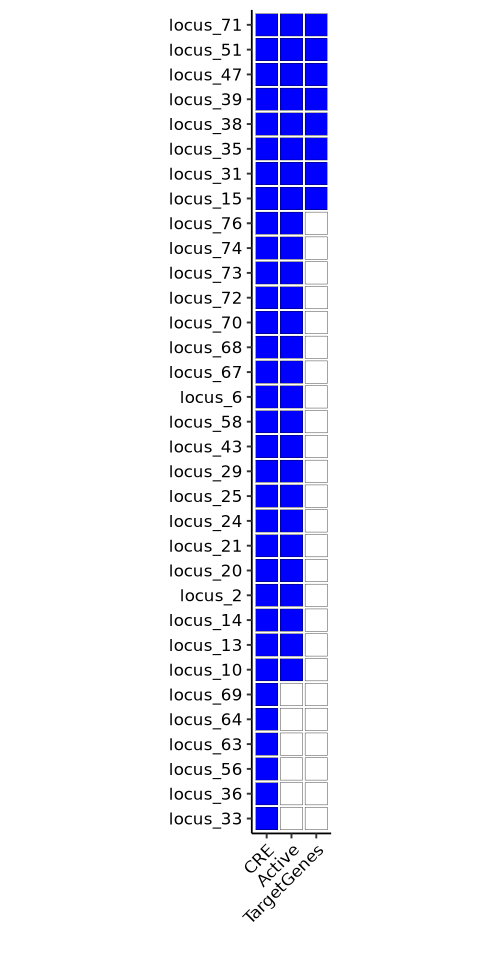

In [505]:
options(repr.plot.width = 4, repr.plot.height = 8)

# Create the plot
gg = ggplot(data.plot, aes(x = Check, y = Locus, fill = Present)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent checks
  scale_fill_manual(values = c("white", "blue")) +  # Blue for "check" and white for "no check"
  labs(
    x = "", 
    y = "", 
    fill = "Condition"
  ) +
theme_pubr()+
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "none"
  )+
  coord_fixed()
gg

In [506]:
data.use %>%
  group_by(Locus) %>%
  dplyr::summarize(
         TargetGenes = paste(unique(target_Gene[!is.na(target_Gene)]), collapse = ", ")) %>%
  dplyr::arrange(desc(Locus)) %>%
  dplyr::filter(TargetGenes != "")

Locus    TargetGenes                                         
1 locus_71 FHOD3                                               
2 locus_51 BHLHE41                                             
3 locus_47 TIAL1, BAG3                                         
4 locus_39 TRAPPC9                                             
5 locus_38 TATDN1, NDUFB9                                      
6 locus_35 FLNC, CALU, AC018638.6, FAM71F2, ATP6V1F, AC018638.7
7 locus_31 MATR3, CXXC5, STING1, PROB1                         
8 locus_15 TMEM182

# Integrate with ChromBPnet

In [5]:
# Triple check what's the reference allele: A1 column
head(data.all.hg38, n = 1)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'data.all.hg38' not found


In [1251]:
read.table("/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/vCM_NO_HF/Hermes_80LociHF_Hg38_vCM_NO_HF_snp_scores.tsv",
                                      header=T) %>%
            dplyr::filter(META_DATA == "rs13277721")

CHR  POS0      REF ALT META_DATA  log_counts_diff log_probs_diff_abs_sum
1 chr8 140621293 A   G   rs13277721 0.03828359      24.15913              
  probs_jsd_diff
1 0.01293736

In [509]:
'the REF and ALT allele are A1 and A2, ok'
'this means that the direction of the comparison will be switched, the GWAS does A1 vs A2, chromBP does A2 vs A1'

[1] "the REF and ALT allele are A1 and A2, ok"

[1] "this means that the direction of the comparison will be switched, the GWAS does A1 vs A2, chromBP does A2 vs A1"

In [6]:
# Load summary stats and create a metadata file figuring out what's the protective allele
summary.stats = fread("/nfs/lab/relgamal/HERMES2_GWAS_DCM_EUR/FORMAT-METAL_Pheno5_EUR.tsv.gz") %>%
                dplyr::mutate(Z = A1_beta/se,
                    Risk_Allele = ifelse(Z > 0, A1, A2))
head(summary.stats, n=1)

#key             rsID        chr pos_b37 A1 A2 A1_beta   A1_freq se       
1 01:000522224:A_G rs564572333 1   522224  A  G  0.1008204 0.013   0.1914101
  pval   logP      N_case N_total isq_het p_het  Z         Risk_Allele
1 0.5984 0.2230084 1508   438436  0       0.6507 0.5267248 A

In [511]:
nrow(data.all.hg38) # FineMap
nrow(summary.stats) # summary stats

test = summary.stats %>%
  dplyr::filter(rsID %in% data.all.hg38$rsID)
nrow(test)

[1] 25252

[1] 9656392

[1] 25243

In [7]:
sum.stat.pred_1 <- read.table("/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/vCM_NO_HF/Hermes_80LociHF_Hg38_vCM_NO_HF_snp_scores.tsv",
                                      header=T)%>%
                dplyr::select(rsID = META_DATA, A1 = REF, A2 = ALT,
                              log_counts_diff, log_probs_diff_abs_sum, probs_jsd_diff) %>%
                dplyr::mutate(chromBP_celltype = "vCM_NO_HF", 
                              celltype = "vCM")

sum.stat.pred_2 <- read.table("/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/aCM_NO_HF/Hermes_80LociHF_Hg38_aCM_NO_HF_snp_scores.tsv",
                                      header=T)%>%
                dplyr::select(rsID = META_DATA, A1 = REF, A2 = ALT,
                              log_counts_diff, log_probs_diff_abs_sum, probs_jsd_diff) %>%
                dplyr::mutate(chromBP_celltype = "aCM_NO_HF", 
                              celltype = "aCM")

sum.stat.pred_3 <- read.table("/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/vCM_HF/Hermes_80LociHF_Hg38_vCM_HF_snp_scores.tsv",
                                      header=T)%>%
                dplyr::select(rsID = META_DATA, A1 = REF, A2 = ALT,
                              log_counts_diff, log_probs_diff_abs_sum, probs_jsd_diff) %>%
                dplyr::mutate(chromBP_celltype = "vCM_HF", 
                              celltype = "vCM")

sum.stat.pred_4 <- read.table("/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/aCM_HF/Hermes_80LociHF_Hg38_aCM_HF_snp_scores.tsv",
                                      header=T)%>%
                dplyr::select(rsID = META_DATA, A1 = REF, A2 = ALT,
                              log_counts_diff, log_probs_diff_abs_sum, probs_jsd_diff)%>%
                dplyr::mutate(chromBP_celltype = "aCM_HF", 
                              celltype = "aCM")

sum.stat.pred = rbind(sum.stat.pred_1, sum.stat.pred_2)

nrow(sum.stat.pred)

[1] 50302

In [8]:
# Merge with risk allele information
sum.stat.pred = summary.stats %>%
  dplyr::select(rsID, Z, Risk_Allele) %>%  # Keep only needed columns
  right_join(sum.stat.pred, by = "rsID") %>%
  dplyr::mutate(ChromBP_Fav_Allele = case_when(
                log_probs_diff_abs_sum > 0 ~ A2,
                log_probs_diff_abs_sum < 0 ~ A1,
                TRUE ~ "Ambiguous"
  )) %>%
  mutate(DataFavors = case_when(
    ChromBP_Fav_Allele == Risk_Allele ~ "Risk Allele",
    TRUE ~ "Protective Allele"
  ))
nrow(sum.stat.pred)

[1] 50352

In [10]:
  write.table(
    sum.stat.pred,
    file      = "/nfs/lab/tscc/luca/MEGA_Heart/chromBPnet/HermesGWAS_ChromBPnet_CMs.txt",
    sep       = "\t",
    row.names = FALSE,
    col.names = TRUE,
    quote     = FALSE
  )

In [514]:
test = sum.stat.pred %>%
        dplyr::select(rsID, A1, A2, Z, Risk_Allele, 
                      ChromBP_probLogFC = log_probs_diff_abs_sum, ChromBP_Fav_Allele, DataFavors, 
                      celltype) %>%
        distinct(rsID, .keep_all = TRUE)

head(test)

rsID        A1 A2 Z         Risk_Allele ChromBP_probLogFC ChromBP_Fav_Allele
1 rs148246829 C  T  -2.545986 T           -11.59468         C                 
2 rs111289091 A  C   2.500691 A            18.87426         C                 
3 rs146857578 A  G   2.861830 A            17.72180         G                 
4 rs557201072 A  C   2.417507 A           -14.57670         A                 
5 rs116110278 A  G   2.276709 A            11.94298         G                 
6 rs3128320   A  G   2.994117 A            16.38780         G                 
  DataFavors        celltype
1 Protective Allele vCM     
2 Protective Allele vCM     
3 Protective Allele vCM     
4 Risk Allele       vCM     
5 Protective Allele vCM     
6 Protective Allele vCM

In [1252]:
sum.stat.pred %>%
dplyr::filter(rsID == "rs13277721")

rsID       Z      Risk_Allele A1 A2 log_counts_diff log_probs_diff_abs_sum
1 rs13277721 4.7026 A           A  G  0.03828359      24.15913              
2 rs13277721 4.7026 A           A  G  0.02985382      17.95741              
  probs_jsd_diff chromBP_celltype celltype ChromBP_Fav_Allele DataFavors       
1 0.01293736     vCM_NO_HF        vCM      G                  Protective Allele
2 0.01025496     aCM_NO_HF        aCM      G                  Protective Allele

In [2754]:
sum.stat.pred_3 %>%
dplyr::filter(rsID == "rs13277721")

rsID       A1 A2 log_counts_diff log_probs_diff_abs_sum probs_jsd_diff
1 rs13277721 A  G  0.06336641      46.54817               0.02224599    
  chromBP_celltype celltype
1 vCM_HF           vCM

In [515]:
quantile(abs(sum.stat.pred_1$log_probs_diff_abs_sum))
quantile(abs(sum.stat.pred_2$log_probs_diff_abs_sum))
quantile(abs(sum.stat.pred_3$log_probs_diff_abs_sum))
quantile(abs(sum.stat.pred_4$log_probs_diff_abs_sum))

0%        25%        50%        75%       100% 
  4.680286  12.152835  15.347206  21.143783 463.890500

0%        25%        50%        75%       100% 
  5.203034  10.855609  13.607618  18.583065 425.929930

0%        25%        50%        75%       100% 
  5.814606  11.973572  14.811692  20.157853 366.087340

0%        25%        50%        75%       100% 
  4.227233  10.362018  12.883598  17.471753 236.603300

0%        25%        50%        75%       100% 
  4.680286  12.152835  15.347206  21.143783 463.890500

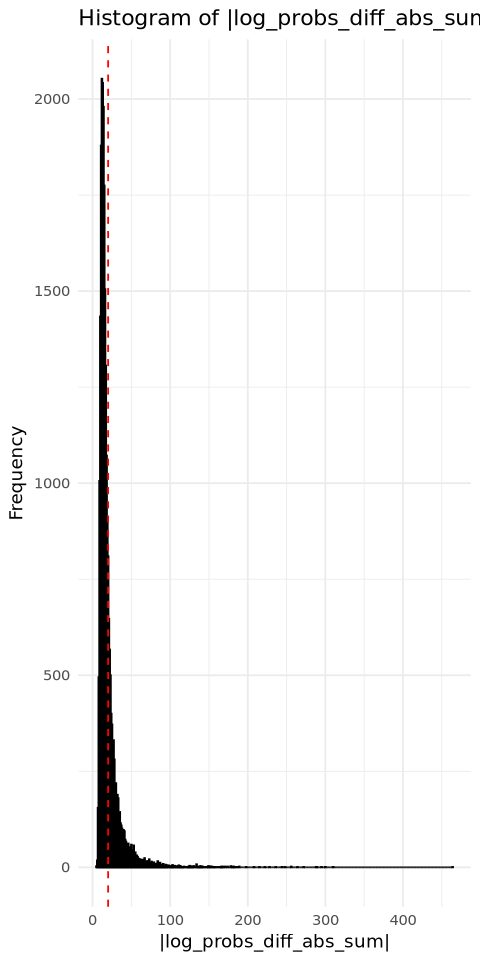

In [516]:
# Compute quantiles on absolute values
quantiles <- quantile(abs(sum.stat.pred_1$log_probs_diff_abs_sum))

# Create histogram with quantile lines
ggplot(sum.stat.pred_1, aes(x = abs(log_probs_diff_abs_sum))) +
  geom_histogram(binwidth = 1, fill = "steelblue", color = "black", alpha = 0.7) +
  
  # Add vertical lines for quantiles
  geom_vline(aes(xintercept = 20), linetype = "dashed", color = "red") +


  # Labels and theme
  labs(title = "Histogram of |log_probs_diff_abs_sum|",
       x = "|log_probs_diff_abs_sum|",
       y = "Frequency") +
  theme_minimal()
quantiles

# Integrate with De-genes

In [517]:
RNA.DESEQ.path = "/nfs/lab/projects/mega_heart/FNIH/Integration/DESEQ_assets/4chambers_DESEQ2_RNA.dds.res"

In [518]:
RNA.DESEQ = read.table(RNA.DESEQ.path,
                        sep = '\t', header = TRUE) %>%
    dplyr::filter(contrast == "HF_vs_NON_HF") %>%
    dplyr::mutate(RNA_DESeq2 = dplyr::case_when(
                      RNA_L2FC > 0 & RNA_Padj < 0.1 ~ "UP",
                      RNA_L2FC < 0 & RNA_Padj < 0.1 ~ "DOWN",       
                      TRUE ~ "NS")) %>%
    dplyr::select(celltype, target_Gene = RNA_ID, contrast, RNA_DESeq2, RNA_L2FC)

In [519]:
data.use.final = data.use %>%
  left_join(RNA.DESEQ, by = c("celltype", "target_Gene", "contrast")) %>%
  tidyr::replace_na(list(RNA_DESeq2 = "NS"))

In [1176]:
RNA.DESEQ

celltype target_Gene contrast     RNA_DESeq2 RNA_L2FC       
1      aCM      CA14        HF_vs_NON_HF DOWN       -2.5334303     
2      aCM      NR2F2       HF_vs_NON_HF DOWN       -1.0643206     
3      aCM      TBX20       HF_vs_NON_HF DOWN       -1.1382298     
4      aCM      SLC9B1      HF_vs_NON_HF UP          1.5315369     
5      aCM      HIST2H2AC   HF_vs_NON_HF DOWN       -1.7034615     
6      aCM      UBE2O       HF_vs_NON_HF DOWN       -0.7840470     
7      aCM      LMAN1L      HF_vs_NON_HF DOWN       -1.6278526     
8      aCM      MKNK2       HF_vs_NON_HF UP          1.6312692     
9      aCM      G0S2        HF_vs_NON_HF DOWN       -2.3642966     
10     aCM      GSE1        HF_vs_NON_HF DOWN       -1.0553302     
11     aCM      LINC02309   HF_vs_NON_HF UP          6.5891751     
12     aCM      PDLIM1      HF_vs_NON_HF UP          1.2185059     
13     aCM      SH3RF2      HF_vs_NON_HF DOWN       -2.2114094     
14     aCM      ARL6IP5     HF_vs_NON_HF DOWN       -0.8193214     
15     aCM      AC108067.1  HF_vs_NON_HF UP          3.0335335     
16     aCM      SPATA6L     HF_vs_NON_HF UP          1.8055053     
17     aCM      GRXCR2      HF_vs_NON_HF DOWN       -4.0548244     
18     aCM      SH3KBP1     HF_vs_NON_HF DOWN       -1.0381995     
19     aCM      ISOC1       HF_vs_NON_HF DOWN       -1.1594910     
20     aCM      AC007389.1  HF_vs_NON_HF UP          2.0826212     
21     aCM      CPLX3       HF_vs_NON_HF DOWN       -1.8925132     
22     aCM      TASP1       HF_vs_NON_HF UP          1.4355556     
23     aCM      MMP15       HF_vs_NON_HF DOWN       -1.4262904     
24     aCM      SLC41A1     HF_vs_NON_HF DOWN       -1.0004564     
25     aCM      ETV5        HF_vs_NON_HF UP          2.3352941     
26     aCM      AC007389.3  HF_vs_NON_HF UP          2.4420593     
27     aCM      IGFBP5      HF_vs_NON_HF DOWN       -1.8359448     
28     aCM      GDF6        HF_vs_NON_HF DOWN       -2.9878461     
29     aCM      SPATC1      HF_vs_NON_HF DOWN       -1.2877687     
30     aCM      MT2A        HF_vs_NON_HF UP          2.0264500     
⋮      ⋮        ⋮           ⋮            ⋮          ⋮              
194491 vCM      SLC5A5      HF_vs_NON_HF NS          0.001323151256
194492 vCM      AC099796.2  HF_vs_NON_HF NS          0.001736885082
194493 vCM      AL360270.1  HF_vs_NON_HF NS         -0.000274441970
194494 vCM      AL360270.3  HF_vs_NON_HF NS          0.001049304235
194495 vCM      AL157904.1  HF_vs_NON_HF NS         -0.000386562172
194496 vCM      CNIH4       HF_vs_NON_HF NS          0.000153561743
194497 vCM      ARHGEF33    HF_vs_NON_HF NS          0.000399496629
194498 vCM      KDM3A       HF_vs_NON_HF NS          0.000288556701
194499 vCM      AC092661.1  HF_vs_NON_HF NS         -0.000477611666
194500 vCM      ANKRD33B    HF_vs_NON_HF NS          0.000669108424
194501 vCM      HK3         HF_vs_NON_HF NS          0.001175855348
194502 vCM      AC092849.3  HF_vs_NON_HF NS         -0.000768945051
194503 vCM      CREM        HF_vs_NON_HF NS         -0.000234708804
194504 vCM      SLC35C1     HF_vs_NON_HF NS          0.000436107185
194505 vCM      AC009509.1  HF_vs_NON_HF NS         -0.000609600485
194506 vCM      GNRH2       HF_vs_NON_HF NS         -0.001232245933
194507 vCM      OBI1        HF_vs_NON_HF NS         -0.000124934479
194508 vCM      AC092718.1  HF_vs_NON_HF NS         -0.000432737011
194509 vCM      XXYLT1      HF_vs_NON_HF NS          0.000113812633
194510 vCM      AC023632.5  HF_vs_NON_HF NS         -0.000229074875
194511 vCM      AC004490.1  HF_vs_NON_HF NS          0.000423156398
194512 vCM      MTHFR       HF_vs_NON_HF NS          0.000067983601
194513 vCM      AL139286.3  HF_vs_NON_HF NS         -0.000073237500
194514 vCM      PGM2        HF_vs_NON_HF NS          0.000053127842
194515 vCM      TMEM134     HF_vs_NON_HF NS          0.000061017126
194516 vCM      AL353648.1  HF_vs_NON_HF NS          0.000110604700
194517 vCM      GARS        HF_vs_NON_HF NS          0.00001836

In [1366]:
dplyr::filter(RNA.DESEQ, target_Gene ==  "TATDN1")

celltype    target_Gene contrast     RNA_DESeq2 RNA_L2FC    
1  aCM         TATDN1      HF_vs_NON_HF UP          0.412841942
2  Adipocyte   TATDN1      HF_vs_NON_HF NS          0.750628560
3  Endocardial TATDN1      HF_vs_NON_HF NS          0.039879838
4  Endothelial TATDN1      HF_vs_NON_HF UP          0.313713992
5  Epicardial  TATDN1      HF_vs_NON_HF NS         -0.001859879
6  Fibroblast  TATDN1      HF_vs_NON_HF UP          0.362552121
7  Lymphoid    TATDN1      HF_vs_NON_HF NS         -0.143448817
8  Myeloid     TATDN1      HF_vs_NON_HF NS          0.124559879
9  Neuronal    TATDN1      HF_vs_NON_HF NS          0.360984729
10 Pericyte    TATDN1      HF_vs_NON_HF NS          0.132025158
11 SM          TATDN1      HF_vs_NON_HF NS          0.091883138
12 vCM         TATDN1      HF_vs_NON_HF UP          0.320972276

## Variants based visualizaton

In [2882]:
variants.plot = data.use.final %>%
    inner_join(sum.stat.pred, by = c("rsID", "celltype")) %>%
    dplyr::filter(chromSTATE %in% c("Active", "ATAC") &
                  abs(log_probs_diff_abs_sum) > 20 &
                  PPA > 0.01
                 ) %>% 
    dplyr::group_by(Locus) %>%
    slice_max(order_by = PPA, n = 1, with_ties = FALSE) %>% 
    dplyr::pull(unique(rsID))

In [2936]:
length(variants.plot)

[1] 24

In [2939]:
dplyr::filter(data.use.final, rsID == "rs17099139")

Peak_ID celltype.collapse celltype contrast ATAC_DESeq2 ATAC_L2FC
     target_Gene interaction_distance Celltype_Peak_ID chromSTATE rsID PPA
     Locus loop_method RNA_DESeq2 RNA_L2FC

In [2884]:
data.plot = data.use.final %>%
        inner_join(sum.stat.pred, by = c("rsID", "celltype")) %>%
        distinct() %>%
        dplyr::filter(rsID %in% variants.plot) %>%
        mutate(rsID = fct_reorder(rsID, PPA, .desc = FALSE)) %>%
        dplyr::arrange(-PPA)

message("Variants with minumum checks: ", length(variants.plot))
message("Loci covered: ", length(unique(data.plot$Locus)))

Variants with minumum checks: 24

Loci covered: 24



### IS ACTIVE or on CREs?

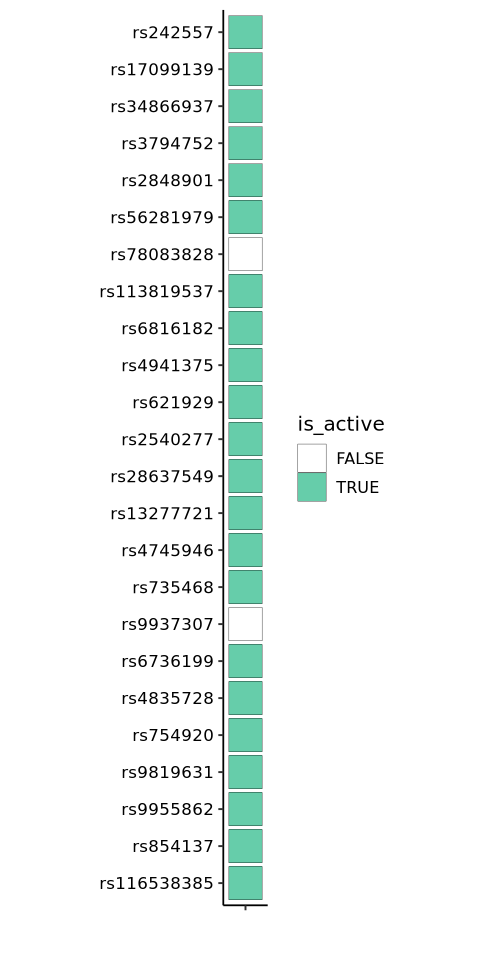

In [523]:
df_active <- data.plot %>%
  group_by(rsID) %>%
  summarize(is_active = any(chromSTATE == "Active"), .groups = "drop")

options(repr.plot.width = 4, repr.plot.height = 8)
gg_active <- ggplot(df_active, aes(x = "", y = rsID, fill = is_active)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_manual(values = c("FALSE" = "white", "TRUE" = "#66cdaa")) +
  labs(
    x = "", 
    y = ""
  ) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Show legend for the viridis scale
  ) +
  coord_fixed()
gg_active

In [524]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_intersection_Active.pdf"),
                            width = 4, height = 8, 
                            plot = gg_active, device = "pdf")

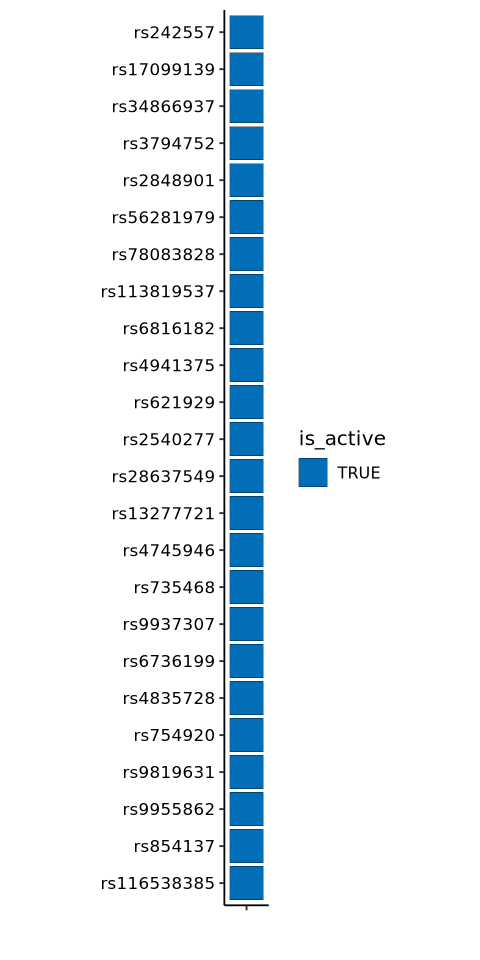

In [525]:
df_active <- data.plot %>%
  group_by(rsID) %>%
  summarize(is_active = any(chromSTATE == "ATAC"), .groups = "drop")

options(repr.plot.width = 4, repr.plot.height = 8)
gg_active <- ggplot(df_active, aes(x = "", y = rsID, fill = is_active)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_manual(values = c("FALSE" = "white", "TRUE" = "#036EB8")) +
  labs(
    x = "", 
    y = ""
  ) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Show legend for the viridis scale
  ) +
  coord_fixed()
gg_active

In [526]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_intersection_CREs.pdf"),
                            width = 4, height = 8, 
                            plot = gg_active, device = "pdf")

In [1198]:
variants.plot

[1] "rs116538385" "rs6736199"   "rs2540277"   "rs56281979"  "rs9819631"  
 [6] "rs6816182"   "rs854137"    "rs4835728"   "rs754920"    "rs34866937" 
[11] "rs13277721"  "rs4745946"   "rs17099139"  "rs113819537" "rs78083828" 
[16] "rs621929"    "rs9937307"   "rs242557"    "rs3794752"   "rs2848901"  
[21] "rs4941375"   "rs9955862"   "rs735468"    "rs28637549"

In [1202]:
dplyr::filter(data.plot, rsID %in% c("rs78083828"))
dplyr::filter(data.plot, rsID %in% c("rs9937307"))

Peak_ID                   celltype.collapse celltype contrast     ATAC_DESeq2
1 chr12-132858753-132859053 CM                vCM      HF_vs_NON_HF NS         
2 chr12-132858753-132859053 CM                aCM      HF_vs_NON_HF NS         
3 chr12-132858753-132859053 CM                aCM      HF_vs_NON_HF NS         
4 chr12-132858753-132859053 CM                vCM      HF_vs_NON_HF NS         
5 chr12-132858753-132859053 CM                vCM      HF_vs_NON_HF NS         
6 chr12-132858753-132859053 CM                aCM      HF_vs_NON_HF NS         
7 chr12-132858753-132859053 CM                aCM      HF_vs_NON_HF NS         
8 chr12-132858753-132859053 CM                vCM      HF_vs_NON_HF NS         
  ATAC_L2FC  target_Gene interaction_distance Celltype_Peak_ID              
1 -0.2273758 NA          NA                   vCM--chr12-132858753-132859053
2  0.3684701 NA          NA                   aCM--chr12-132858753-132859053
3  0.3684701 NA          NA                   aCM--chr12-132858753-132859053
4 -0.2273758 NA          NA                   vCM--chr12-132858753-132859053
5 -0.2273758 NA          NA                   vCM--chr12-132858753-132859053
6  0.3684701 NA          NA                   aCM--chr12-132858753-132859053
7  0.3684701 NA          NA                   aCM--chr12-132858753-132859053
8 -0.2273758 NA          NA                   vCM--chr12-132858753-132859053
  chromSTATE ⋯ Z         Risk_Allele A1 A2 log_counts_diff
1 Open       ⋯ -5.263486 T           C  T  -0.0817914     
2 Open       ⋯ -5.263486 T           C  T   0.1041384     
3 ATAC       ⋯ -5.263486 T           C  T   0.1041384     
4 ATAC       ⋯ -5.263486 T           C  T  -0.0817914     
5 Open       ⋯ -5.263486 T           C  T  -0.0817914     
6 Open       ⋯ -5.263486 T           C  T   0.1041384     
7 ATAC       ⋯ -5.263486 T           C  T   0.1041384     
8 ATAC       ⋯ -5.263486 T           C  T  -0.0817914     
  log_probs_diff_abs_sum probs_jsd_diff chromBP_celltype ChromBP_Fav_Allele
1 -32.96392              -0.01588883    vCM_NO_HF        C                 
2  44.59517               0.02048225    aCM_NO_HF        T                 
3  44.59517               0.02048225    aCM_NO_HF        T                 
4 -32.96392              -0.01588883    vCM_NO_HF        C                 
5 -32.96392              -0.01588883    vCM_NO_HF        C                 
6  44.59517               0.02048225    aCM_NO_HF        T                 
7  44.59517               0.02048225    aCM_NO_HF        T                 
8 -32.96392              -0.01588883    vCM_NO_HF        C                 
  DataFavors       
1 Protective Allele
2 Risk Allele      
3 Risk Allele      
4 Protective Allele
5 Protective Allele
6 Risk Allele      
7 Risk Allele      
8 Protective Allele

Peak_ID             celltype.collapse celltype contrast     ATAC_DESeq2
1 chr16-938015-938315 CM                vCM      HF_vs_NON_HF NS         
2 chr16-938015-938315 CM                aCM      HF_vs_NON_HF NS         
3 chr16-938015-938315 CM                aCM      HF_vs_NON_HF NS         
4 chr16-938015-938315 CM                vCM      HF_vs_NON_HF NS         
5 chr16-938015-938315 CM                vCM      HF_vs_NON_HF NS         
6 chr16-938015-938315 CM                aCM      HF_vs_NON_HF NS         
7 chr16-938015-938315 CM                aCM      HF_vs_NON_HF NS         
8 chr16-938015-938315 CM                vCM      HF_vs_NON_HF NS         
  ATAC_L2FC  target_Gene interaction_distance Celltype_Peak_ID        
1 -0.2159301 NA          NA                   vCM--chr16-938015-938315
2         NA NA          NA                   aCM--chr16-938015-938315
3         NA NA          NA                   aCM--chr16-938015-938315
4 -0.2159301 NA          NA                   vCM--chr16-938015-938315
5 -0.2159301 NA          NA                   vCM--chr16-938015-938315
6         NA NA          NA                   aCM--chr16-938015-938315
7         NA NA          NA                   aCM--chr16-938015-938315
8 -0.2159301 NA          NA                   vCM--chr16-938015-938315
  chromSTATE ⋯ Z        Risk_Allele A1 A2 log_counts_diff
1 Unknown    ⋯ 6.279937 C           C  T  -0.09029674    
2 Unknown    ⋯ 6.279937 C           C  T   0.02913427    
3 ATAC       ⋯ 6.279937 C           C  T   0.02913427    
4 ATAC       ⋯ 6.279937 C           C  T  -0.09029674    
5 Unknown    ⋯ 6.279937 C           C  T  -0.09029674    
6 Unknown    ⋯ 6.279937 C           C  T   0.02913427    
7 ATAC       ⋯ 6.279937 C           C  T   0.02913427    
8 ATAC       ⋯ 6.279937 C           C  T  -0.09029674    
  log_probs_diff_abs_sum probs_jsd_diff chromBP_celltype ChromBP_Fav_Allele
1 -26.00116              -0.01643217    vCM_NO_HF        C                 
2  16.86120               0.01056557    aCM_NO_HF        T                 
3  16.86120               0.01056557    aCM_NO_HF        T                 
4 -26.00116              -0.01643217    vCM_NO_HF        C                 
5 -26.00116              -0.01643217    vCM_NO_HF        C                 
6  16.86120               0.01056557    aCM_NO_HF        T                 
7  16.86120               0.01056557    aCM_NO_HF        T                 
8 -26.00116              -0.01643217    vCM_NO_HF        C                 
  DataFavors       
1 Risk Allele      
2 Protective Allele
3 Protective Allele
4 Risk Allele      
5 Risk Allele      
6 Protective Allele
7 Protective Allele
8 Risk Allele

In [1203]:
# Ok, so 07 is unknown and 28 is open

### What's the PPA?

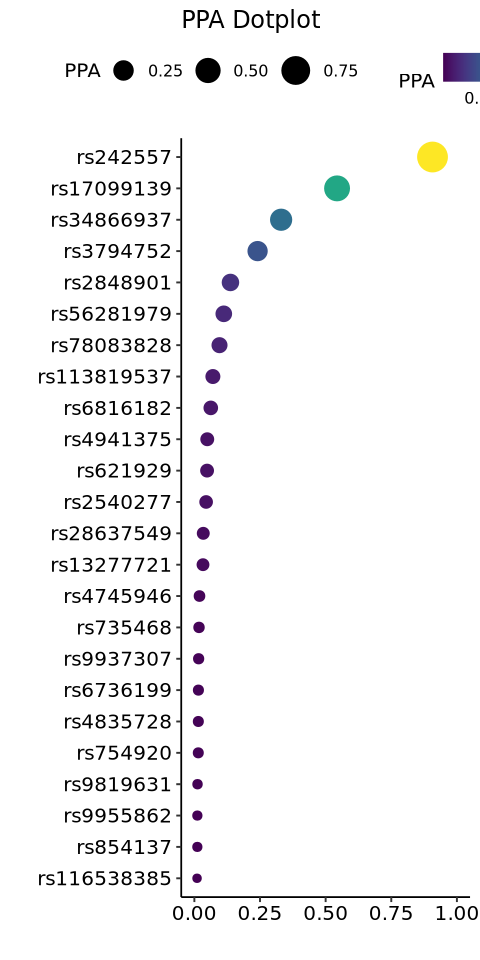

In [572]:
df_ppa <- data.plot %>% distinct(rsID, PPA)

options(repr.plot.width = 4, repr.plot.height = 8)
gg_ppa <- ggplot(df_ppa, aes(y = rsID, x = PPA)) +
  geom_point(aes(size = PPA, color = PPA)) +
  scale_color_viridis(option = "viridis") +
  scale_size_continuous(range = c(2, 8)) +  # Adjust the range as desired
  theme_pubr() +
  labs(title = "PPA Dotplot",
       x = "", 
       y = "")+
  xlim(0, 1)
gg_ppa

In [573]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_intersection_PPA.pdf"),
                            width = 4, height = 8, 
                            plot = gg_ppa, device = "pdf")

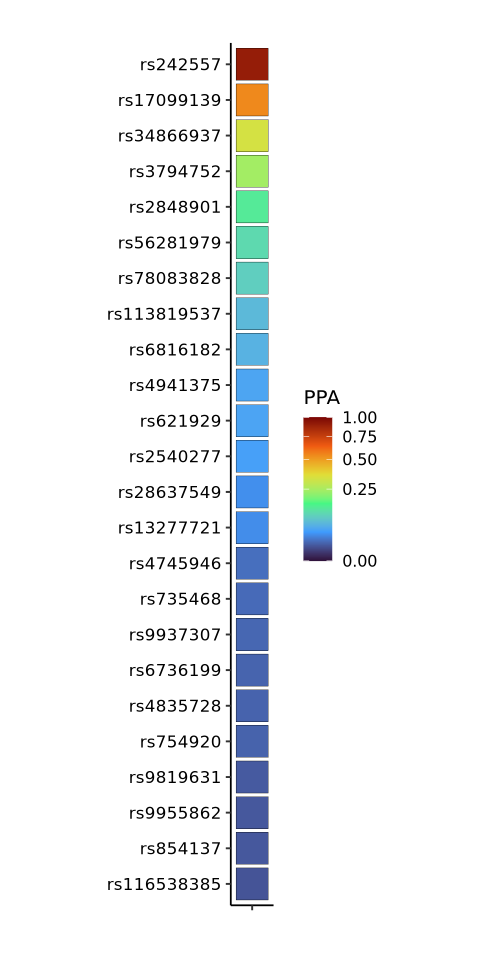

In [574]:
gg_tile <- ggplot(df_ppa, aes(y = rsID, x= "", fill = PPA)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_viridis_c(option = "turbo", limits = c(0, 1), trans = "sqrt") +
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "PPA") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

print(gg_tile)

In [576]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_intersection_PPA_Heatmap.pdf"),
                            width = 4, height = 8, 
                            plot = gg_ppa, device = "pdf")

### Is unique to celltype?

In [577]:
variant_counts <- overlap_data.DIFF.loops.ABC %>%
  distinct(rsID, celltype.collapse) %>%
  group_by(rsID) %>%
  summarize(n_celltypes = n(), .groups = "drop")

overlap_data_joined <- overlap_data.DIFF.loops.ABC %>%
  dplyr::filter(celltype.collapse == "CM") %>%
  dplyr::filter(rsID %in% variants.plot) %>%
  left_join(variant_counts, by = "rsID")%>%
  mutate(rsID = fct_reorder(rsID, PPA, .desc = FALSE)) %>%
  mutate(exclusive = case_when(
    n_celltypes == 1 ~ "exclusive",
    TRUE ~ "shared"
  ))

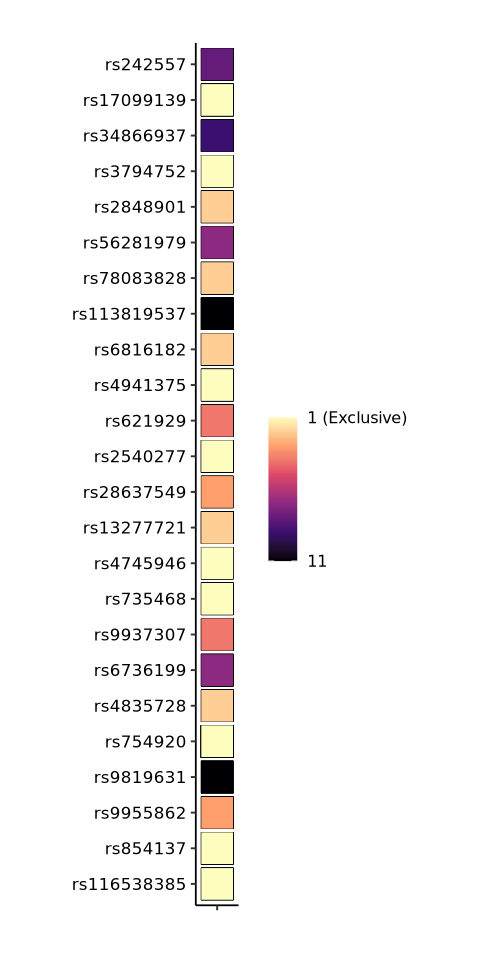

In [578]:
gg_tile <- ggplot(overlap_data_joined, aes(y = rsID, x= "", fill = n_celltypes)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_viridis_c(option = "magma", 
                     trans = "reverse",  # Ensure contrast
    breaks = c(1, 11),  # Set breaks
    labels = c("1 (Exclusive)", "11")  # Custom labels
  ) +
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

print(gg_tile)

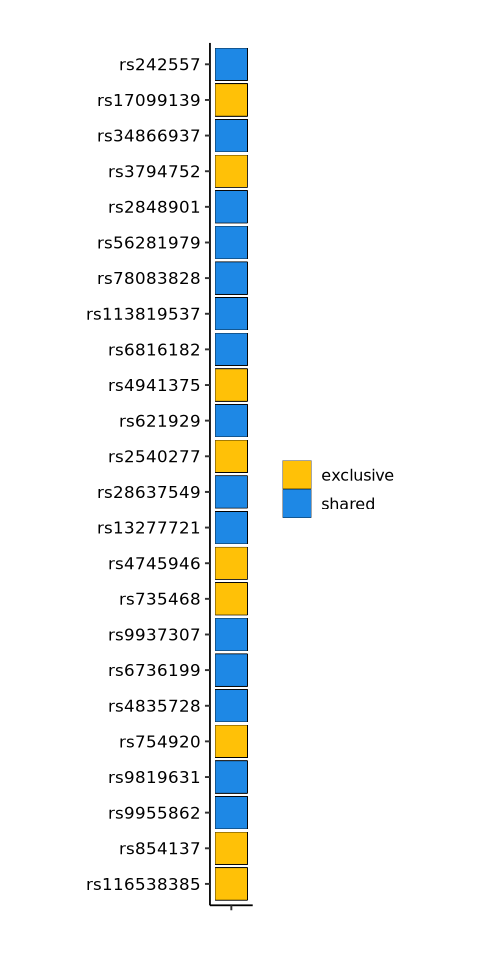

In [579]:
gg_tile <- ggplot(overlap_data_joined, aes(y = rsID, x= "", fill = exclusive)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
scale_fill_manual(values = c(
    "exclusive" = "#FFC107", 
    "shared" = "#1E88E5"  
))+
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

print(gg_tile)

In [580]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCM_80Loci_intersection_Exclusivity_Heatmap.pdf"),
                            width = 4, height = 8, 
                            plot = gg_tile, device = "pdf")

### Has functional prediction?

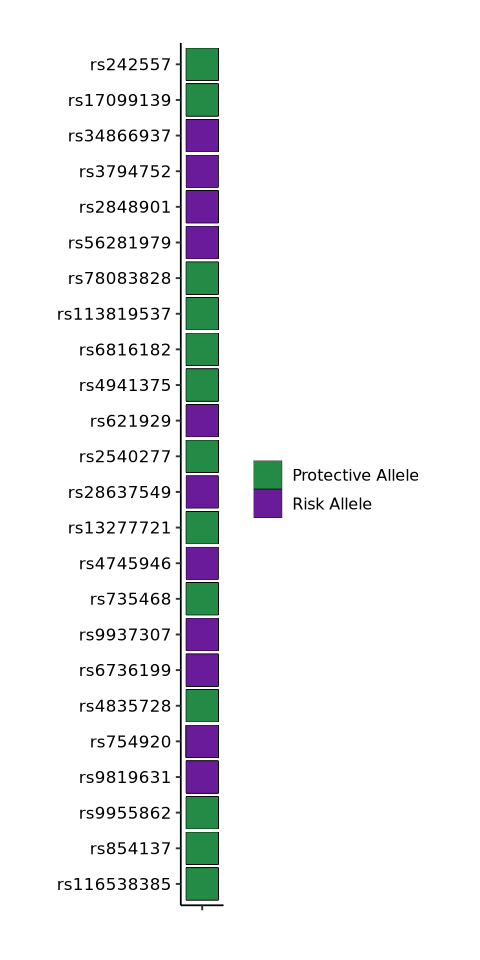

In [581]:
gg_tile <- ggplot(data.plot, aes(y = rsID, x= "", fill = DataFavors)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
scale_fill_manual(values = c(
    "Risk Allele" = "#6A1B9A", 
    "Protective Allele" = "#238B45",
    "Ambiguous" = "White"
))+
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

print(gg_tile)

In [582]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCM_80Loci_intersection_ChromBP.pdf"),
                            width = 4, height = 8, 
                            plot = gg_tile, device = "pdf")

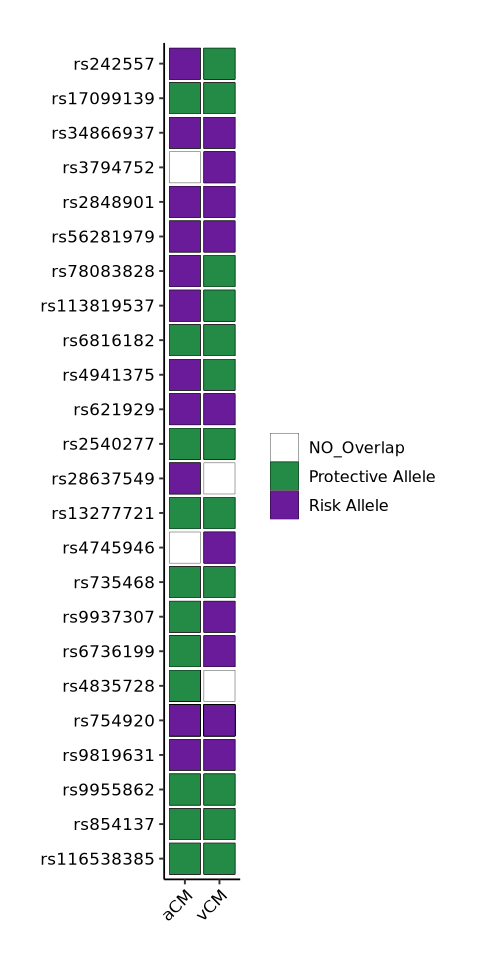

In [583]:
data.plot.chromBP = complete(data.plot, rsID, celltype,
                 fill = list(DataFavors = "NO_Overlap"))

gg_tile <- ggplot(data.plot.chromBP, aes(y = rsID, x= celltype, fill = DataFavors)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
scale_fill_manual(values = c(
    "Risk Allele" = "#6A1B9A", 
    "Protective Allele" = "#238B45",
     "NO_Overlap" = "White"
))+
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

print(gg_tile)

In [584]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCMaCM_80Loci_intersection_ChromBP.pdf"),
                            width = 4, height = 8, 
                            plot = gg_tile, device = "pdf")

### Differential?

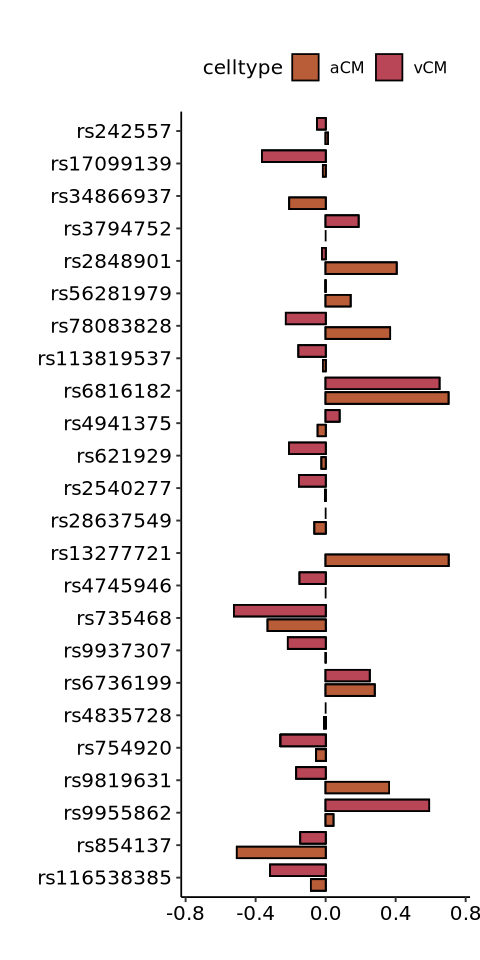

In [1230]:
# Ensure missing combinations are filled with 0
data.plot.ATAC = complete(data.plot, rsID, celltype, fill = list(ATAC_L2FC = 0))

# Create the bar plot
gg_atac <- ggplot(data.plot.ATAC, aes(y = rsID, x = ATAC_L2FC, fill = celltype)) +
  geom_bar(stat = "identity", 
           width = 0.7, 
           position = position_dodge(width = 0.9),  # Space between bars
           color = "black") +  # Black border for bars
  scale_fill_manual(values = celltype_colors) +
  theme_pubr() +
  labs(title = "", x = "", y = "") +
  xlim(-0.75, 0.75) +
  theme(panel.grid.major.y = element_blank(),  # Light Y-axis grid lines
        panel.grid.minor.y = element_blank(),  # Disable minor grid lines
        panel.grid.major.x = element_blank())  # Remove vertical grid lines

gg_atac

In [1231]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCMaCM_80Loci_intersection_ATACDiffBarplot.pdf"),
                            width = 4, height = 8, 
                            plot = gg_atac, device = "pdf")

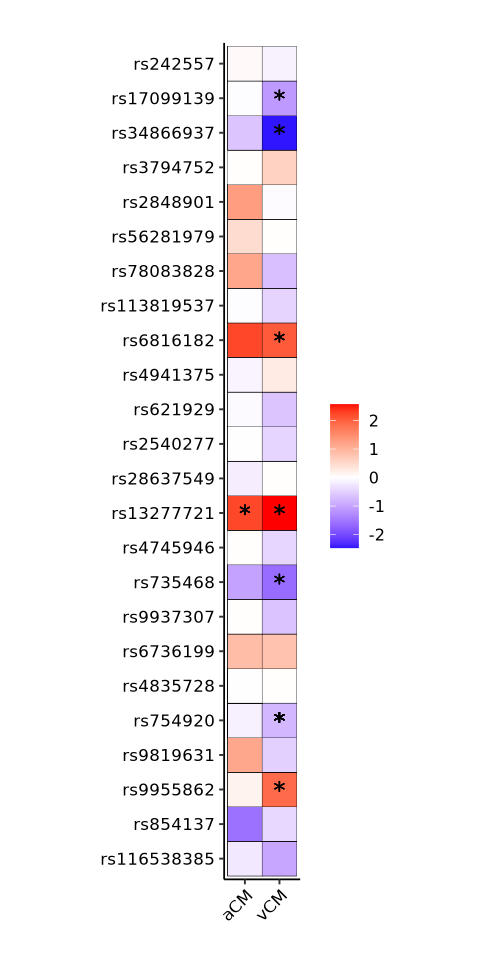

In [1232]:
# Option 1 - show log2FC
gg_atac <- ggplot(data.plot.ATAC, aes(x = celltype, y = rsID, fill = scale(ATAC_L2FC))) +
  geom_tile(color = "black") +  # Add borders to the tiles
  scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
  geom_text(aes(label = ifelse(ATAC_DESeq2 != "NS", "*", "")), size = 5) +  # Add asterisk for significant values
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

gg_atac

In [1233]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCMaCM_80Loci_intersection_ATACDiffHeatMap.pdf"),
                            width = 4, height = 8, 
                            plot = gg_atac, device = "pdf")

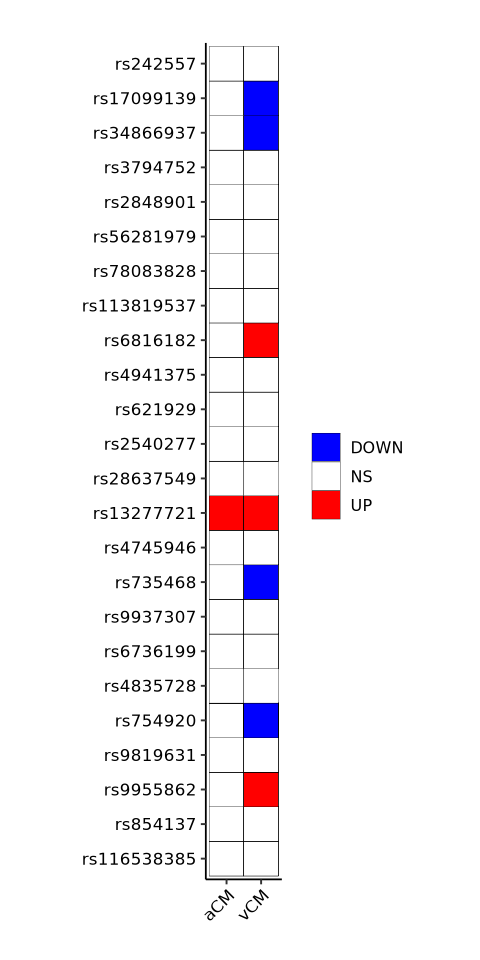

In [1234]:
data.plot.ATAC = data.plot.ATAC %>%
  mutate(ATAC_DESeq2 = ifelse(is.na(ATAC_DESeq2), "NS", ATAC_DESeq2))

# Option 2 - show up or down
gg_atac <- ggplot(data.plot.ATAC, aes(x = celltype, y = rsID, fill = ATAC_DESeq2)) +
  geom_tile(color = "black") +  # Add borders to the tiles
  scale_fill_manual(values = c(
        "NS" = "white", 
        "UP" = "red",
         "DOWN" = "Blue"
  ))+
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "") +  # Clear legend title
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep legend on the right
  ) +
  coord_fixed()

gg_atac

In [1235]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCMaCM_80Loci_intersection_ATACDiffCheckPlot.pdf"),
                            width = 4, height = 8, 
                            plot = gg_atac, device = "pdf")

### Has a link?

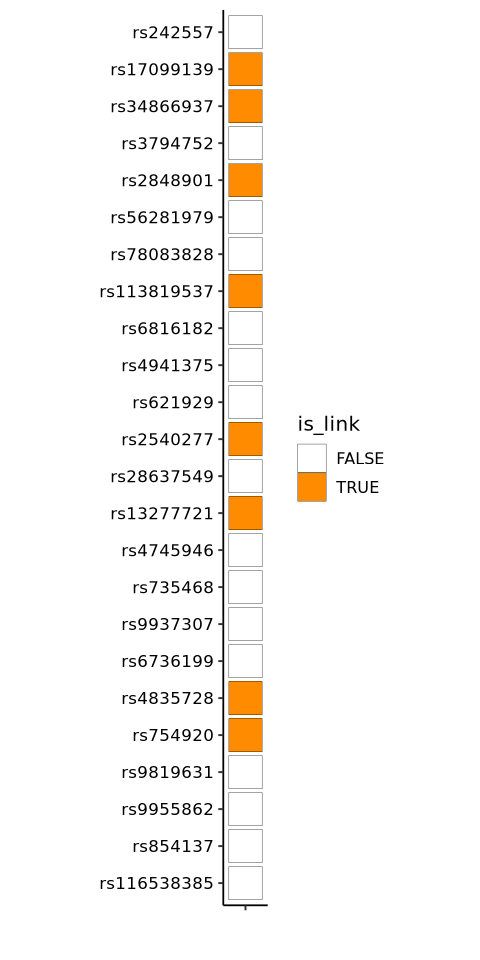

In [589]:
df_link <- data.plot %>%
  group_by(rsID) %>%
  summarize(is_link = ifelse(any(!is.na(target_Gene)), TRUE, FALSE), .groups = "drop")


gg_link <- ggplot(df_link, aes(x = "", y = rsID, fill = is_link)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_manual(values = c("FALSE" = "white", "TRUE" = "#FF8C00")) +
  labs(
    x = "", 
    y = ""
  ) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Show legend for the viridis scale
  ) +
  coord_fixed()

gg_link

In [595]:
data.plot %>%
  group_by(rsID) %>%
  dplyr::summarize(
         TargetGenes = paste(unique(target_Gene[!is.na(target_Gene)]), collapse = ", ")) %>%
  dplyr::filter(TargetGenes != "")

rsID        TargetGenes                                         
1 rs754920    FLNC, CALU, AC018638.6, FAM71F2, ATP6V1F, AC018638.7
2 rs4835728   MATR3, CXXC5, STING1, PROB1                         
3 rs13277721  TRAPPC9                                             
4 rs2540277   TMEM182                                             
5 rs113819537 BHLHE41                                             
6 rs2848901   FHOD3                                               
7 rs34866937  TATDN1, NDUFB9                                      
8 rs17099139  TIAL1, BAG3

In [590]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCM_80Loci_intersection_Link.pdf"),
                            width = 4, height = 8, 
                            plot = gg_link, device = "pdf")

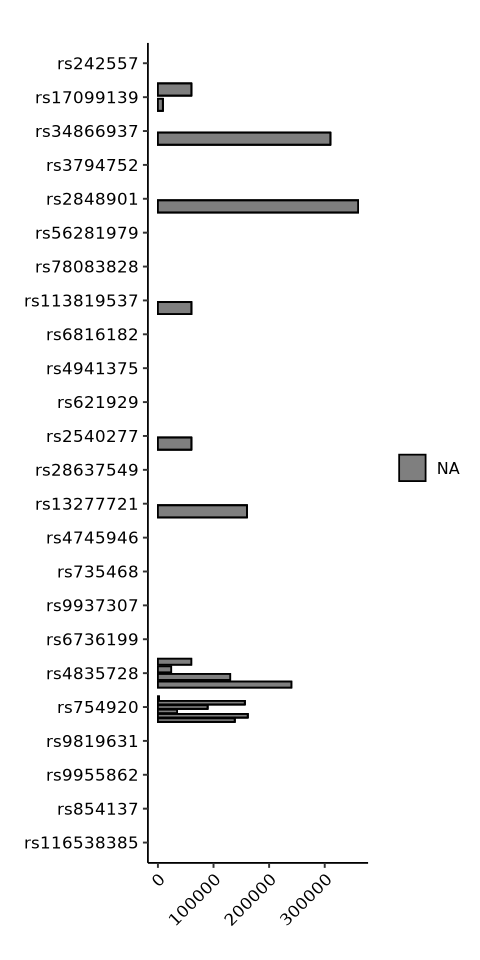

In [546]:
gg_interaction_length <- ggplot(data.plot, aes(y = rsID, x = interaction_distance, fill = target_Gene)) +
  geom_bar(stat = "identity", 
           width = 0.7, 
           position = position_dodge(width = 0.9),  # Increase dodge width to add space between bars
           color = "black") +                     # Use 'color' for the white border
  scale_fill_manual(values = celltype_colors) +
  theme_pubr() +
  labs(title = "",
       x = "", 
       y = "", 
       fill = "")+
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Show legend for the viridis scale
  )

gg_interaction_length

### FIND EXAMPLE HERE

"data.plot: Top CM variants per locus, PPA > 1%, with chromBP predictions, no filter by Active state"

In [2885]:
colnames(data.plot)

[1] "Peak_ID"                "celltype.collapse"      "celltype"              
 [4] "contrast"               "ATAC_DESeq2"            "ATAC_L2FC"             
 [7] "target_Gene"            "interaction_distance"   "Celltype_Peak_ID"      
[10] "chromSTATE"             "rsID"                   "PPA"                   
[13] "Locus"                  "loop_method"            "RNA_DESeq2"            
[16] "RNA_L2FC"               "Z"                      "Risk_Allele"           
[19] "A1"                     "A2"                     "log_counts_diff"       
[22] "log_probs_diff_abs_sum" "probs_jsd_diff"         "chromBP_celltype"      
[25] "ChromBP_Fav_Allele"     "DataFavors"

In [2886]:
# Find reasonable examples for bw tracks
data.plot %>%
    dplyr::filter(chromSTATE == "Active" & 
                  !is.na(target_Gene)
                 )%>% 
    dplyr::arrange(-PPA, -interaction_distance) %>% 
    distinct() %>% 
    dplyr::select(celltype, 
                  rsID, PPA,Locus,
                  Peak_ID, ATAC_DESeq2, ATAC_L2FC,
                  loop_method, target_Gene, RNA_DESeq2, RNA_L2FC)

celltype rsID        PPA        Locus    Peak_ID                  
1  vCM      rs17099139  0.54352100 locus_47 chr10-119659964-119660194
2  aCM      rs17099139  0.54352100 locus_47 chr10-119659964-119660194
3  vCM      rs17099139  0.54352100 locus_47 chr10-119659964-119660194
4  aCM      rs17099139  0.54352100 locus_47 chr10-119659964-119660194
5  vCM      rs34866937  0.33044791 locus_38 chr8-124847510-124847810 
6  aCM      rs34866937  0.33044791 locus_38 chr8-124847510-124847810 
7  vCM      rs2848901   0.13742259 locus_71 chr18-36652592-36652861  
8  aCM      rs2848901   0.13742259 locus_71 chr18-36652592-36652861  
9  vCM      rs113819537 0.07052151 locus_51 chr12-26195326-26195626  
10 aCM      rs113819537 0.07052151 locus_51 chr12-26195326-26195626  
11 vCM      rs2540277   0.04474717 locus_15 chr2-102809419-102809719 
12 aCM      rs2540277   0.04474717 locus_15 chr2-102809419-102809719 
13 vCM      rs13277721  0.03283520 locus_39 chr8-140621226-140621526 
14 aCM      rs13277721  0.03283520 locus_39 chr8-140621226-140621526 
15 aCM      rs4835728   0.01508379 locus_31 chr5-139418856-139419058 
16 aCM      rs4835728   0.01508379 locus_31 chr5-139418856-139419058 
17 aCM      rs4835728   0.01508379 locus_31 chr5-139418856-139419058 
18 aCM      rs4835728   0.01508379 locus_31 chr5-139418856-139419058 
19 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
20 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
21 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
22 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
23 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
24 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
25 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
26 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
27 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
28 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
29 vCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
30 aCM      rs754920    0.01490212 locus_35 chr7-128828225-128828525 
   ATAC_DESeq2 ATAC_L2FC    loop_method target_Gene    RNA_DESeq2 RNA_L2FC    
1  DOWN        -0.363586040 HiC         TIAL1          DOWN       -0.176959331
2  NS          -0.015841873 HiC         TIAL1          NS          0.016363923
3  DOWN        -0.363586040 ABC         BAG3           NS         -0.322514989
4  NS          -0.015841873 ABC         BAG3           NS         -0.134147723
5  DOWN        -0.789157703 HiC         TATDN1, NDUFB9 NS                   NA
6  NS          -0.207626889 HiC         TATDN1, NDUFB9 NS                   NA
7  NS          -0.020574580 HiC         FHOD3          NS         -0.133680192
8  NS           0.404959086 HiC         FHOD3          NS         -0.147301468
9  NS          -0.155094106 HiC         BHLHE41        NS         -0.267947679
10 NS          -0.015676157 HiC         BHLHE41        NS         -0.518304801
11 NS          -0.152805399 HiC         TMEM182        NS          0.018500200
12 NS          -0.002988855 HiC         TMEM182        NS          0.144285063
13 UP           0.807937955 HiC         TRAPPC9        NS         -0.107378715
14 UP           0.702019358 HiC         TRAPPC9        NS         -0.033823062
15 NS          -0.009374257 HiC         CXXC5          DOWN       -0.997186263
16 NS          -0.009374257 HiC         MATR3          NS          0.055977663
17 NS          -0.009374257 HiC         STING1         NS                   NA
18 NS          -0.009374257 ABC         PROB1          NS         -0.725192621
19 DOWN        -0.256714609 ABC         AC018638.7     NS         -0.144428089
20 NS          -0.054116594 ABC         AC018638.7     NS         -0.172177769
21 DOWN        -0.256714609 ABC         FAM71F2        NS          0.005085274
22 NS          -0.054116594 ABC         FAM71F2        NS         -0.201534056
23 DOWN        -

In [814]:
# Check predition stuff
summary.stats %>%
    dplyr::filter(rsID == "rs13277721") %>%
    dplyr::select(rsID, A1, A2, Z, Risk_Allele)

sum.stat.pred %>%
    dplyr::filter(rsID == "rs17099139") %>%
        dplyr::select(rsID, A1, A2, Z, Risk_Allele, 
                      ChromBP_Fav_Allele, DataFavors, 
                      celltype)

rsID       A1 A2 Z      Risk_Allele
1 rs13277721 A  G  4.7026 A

rsID       A1 A2 Z        Risk_Allele ChromBP_Fav_Allele DataFavors       
1 rs17099139 C  G  13.15135 C           G                  Protective Allele
2 rs17099139 C  G  13.15135 C           G                  Protective Allele
  celltype
1 vCM     
2 aCM

# Integrate with vCM - GRN

In [2909]:
Scenic_Plus = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/scenicplus/vCM/edges_R2G.csv") %>%
  dplyr::mutate(
    Peak_ID = sub(":", "-", Region),
    GRN_ID = gsub(pattern = "_[+-]_[+-]", replacement = "", x = Consensus_name)) %>%
  dplyr::select(Peak_ID, GRN_Gene = Gene, GRN_ID, Consensus_name)
message("Unique peaks in the GRN: ", length(unique(Scenic_Plus$Peak_ID)))
message("Unique Regulons in the GRN: ", length(unique(Scenic_Plus$GRN_ID)))

# load GRN we care about
GRN_use = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/scenicplus/vCM_GRN_regulons.csv") %>%
            dplyr::select(GRN_ID = name, cluster)
message("Unique Regulons in the GRN: ", length(unique(GRN_use$GRN_ID)))

GRN_use = GRN_use %>%
    right_join(Scenic_Plus, by = "GRN_ID")
message("Unique Regulons in the GRN: ", length(unique(GRN_use$GRN_ID)))

Unique peaks in the GRN: 4906

Unique Regulons in the GRN: 119

Unique Regulons in the GRN: 75

Unique Regulons in the GRN: 119



In [2910]:
# Save table
write.table(GRN_use,
            file = paste("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_vCMregulons.txt", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

In [2911]:
overlap_data.DIFF.GRN = overlap_data.DIFF.loops.ABC %>%
  dplyr::filter(celltype == "vCM" & chromSTATE == "ATAC") %>%
  inner_join(GRN_use, by = c("Peak_ID")) %>%
  tidyr::replace_na(list(ATAC_DESeq2 = "NS")) %>%
  distinct()
message("Unique Regulons in the GRN: ", length(unique(overlap_data.DIFF.GRN$GRN_ID)))
message("Unique variants in the GRN: ", length(unique(overlap_data.DIFF.GRN$rsID)))
overlap_data.DIFF.GRN

Unique Regulons in the GRN: 21

Unique variants in the GRN: 20



Peak_ID                   celltype.collapse celltype contrast    
1  chr8-11853894-11854194    CM                vCM      HF_vs_NON_HF
2  chr8-11853894-11854194    CM                vCM      HF_vs_NON_HF
3  chr8-11853894-11854194    CM                vCM      HF_vs_NON_HF
4  chr8-11853894-11854194    CM                vCM      HF_vs_NON_HF
5  chr10-119659964-119660194 CM                vCM      HF_vs_NON_HF
6  chr1-214107412-214107712  CM                vCM      HF_vs_NON_HF
7  chr1-214107412-214107712  CM                vCM      HF_vs_NON_HF
8  chr1-228207866-228208166  CM                vCM      HF_vs_NON_HF
9  chr2-102764143-102764443  CM                vCM      HF_vs_NON_HF
10 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
11 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
12 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
13 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
14 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
15 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
16 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
17 chr3-73144350-73144650    CM                vCM      HF_vs_NON_HF
18 chr3-134698380-134698680  CM                vCM      HF_vs_NON_HF
19 chr3-134698380-134698680  CM                vCM      HF_vs_NON_HF
20 chr3-134659768-134660068  CM                vCM      HF_vs_NON_HF
21 chr3-134651620-134651884  CM                vCM      HF_vs_NON_HF
22 chr3-134659768-134660068  CM                vCM      HF_vs_NON_HF
23 chr3-134752804-134753104  CM                vCM      HF_vs_NON_HF
24 chr3-134651620-134651884  CM                vCM      HF_vs_NON_HF
25 chr6-90369219-90369519    CM                vCM      HF_vs_NON_HF
26 chr6-90369219-90369519    CM                vCM      HF_vs_NON_HF
27 chr6-90537701-90538001    CM                vCM      HF_vs_NON_HF
28 chr6-90537701-90538001    CM                vCM      HF_vs_NON_HF
29 chr8-11724934-11725234    CM                vCM      HF_vs_NON_HF
30 chr8-11724934-11725234    CM                vCM      HF_vs_NON_HF
⋮  ⋮                         ⋮                 ⋮        ⋮           
41 chr8-11853894-11854194    CM                vCM      HF_vs_NON_HF
42 chr10-119659964-119660194 CM                vCM      HF_vs_NON_HF
43 chr1-214107412-214107712  CM                vCM      HF_vs_NON_HF
44 chr1-214107412-214107712  CM                vCM      HF_vs_NON_HF
45 chr1-228207866-228208166  CM                vCM      HF_vs_NON_HF
46 chr2-102764143-102764443  CM                vCM      HF_vs_NON_HF
47 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
48 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
49 chr3-73490705-73491005    CM                vCM      HF_vs_NON_HF
50 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
51 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
52 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
53 chr3-73586186-73586486    CM                vCM      HF_vs_NON_HF
54 chr3-73144350-73144650    CM                vCM      HF_vs_NON_HF
55 chr3-134698380-134698680  CM                vCM      HF_vs_NON_HF
56 chr3-134698380-134698680  CM                vCM      HF_vs_NON_HF
57 chr3-134651620-134651884  CM                vCM      HF_vs_NON_HF
58 chr3-134752804-134753104  CM                vCM      HF_vs_NON_HF
59 chr3-134651620-134651884  CM                vCM      HF_vs_NON_HF
60 chr6-90369219-90369519    CM                vCM      HF_vs_NON_HF
61 chr6-90369219-90369519    CM                vCM      HF_vs_NON_HF
62 chr6-90537701-90538001    CM                vCM      HF_vs_NON_HF
63 chr6-90537701-90538001    CM                vCM      HF_vs_NON_HF
64 chr8-11724934-11725234    CM                vCM      HF_vs_NON_HF
65 chr8-11724934-11725234    CM                vCM      HF_vs_NON_HF
66 chr8-11724934-11725234    CM                vCM      HF_vs_NON_HF
6

In [2912]:
overlap_data.DIFF.GRN %>%
  dplyr::filter(GRN_ID == "MEF2A") 

Peak_ID                  celltype.collapse celltype contrast     ATAC_DESeq2
1  chr1-214107412-214107712 CM                vCM      HF_vs_NON_HF DOWN       
2  chr1-228207866-228208166 CM                vCM      HF_vs_NON_HF DOWN       
3  chr3-134659768-134660068 CM                vCM      HF_vs_NON_HF DOWN       
4  chr3-134651620-134651884 CM                vCM      HF_vs_NON_HF DOWN       
5  chr3-134659768-134660068 CM                vCM      HF_vs_NON_HF DOWN       
6  chr3-134651620-134651884 CM                vCM      HF_vs_NON_HF DOWN       
7  chr3-134659768-134660068 CM                vCM      HF_vs_NON_HF DOWN       
8  chr3-134659768-134660068 CM                vCM      HF_vs_NON_HF DOWN       
9  chr1-214107412-214107712 CM                vCM      HF_vs_NON_HF DOWN       
10 chr1-228207866-228208166 CM                vCM      HF_vs_NON_HF DOWN       
11 chr3-134651620-134651884 CM                vCM      HF_vs_NON_HF DOWN       
12 chr3-134651620-134651884 CM                vCM      HF_vs_NON_HF DOWN       
   ATAC_L2FC  target_Gene interaction_distance Celltype_Peak_ID             
1  -0.3299500 NA              NA               vCM--chr1-214107412-214107712
2  -0.3694346 NA              NA               vCM--chr1-228207866-228208166
3  -0.4556452 NA              NA               vCM--chr3-134659768-134660068
4  -0.3425076 NA              NA               vCM--chr3-134651620-134651884
5  -0.4556452 NA              NA               vCM--chr3-134659768-134660068
6  -0.3425076 NA              NA               vCM--chr3-134651620-134651884
7  -0.4556452 KY          8282.5               vCM--chr3-134659768-134660068
8  -0.4556452 KY          8282.5               vCM--chr3-134659768-134660068
9  -0.3299500 NA              NA               vCM--chr1-214107412-214107712
10 -0.3694346 NA              NA               vCM--chr1-228207866-228208166
11 -0.3425076 NA              NA               vCM--chr3-134651620-134651884
12 -0.3425076 NA              NA               vCM--chr3-134651620-134651884
   chromSTATE rsID        PPA          Locus    loop_method GRN_ID cluster
1  ATAC       rs74139603  0.0098049136 locus_10 HiC         MEF2A  C2     
2  ATAC       rs138148910 0.0008646198 locus_11 HiC         MEF2A  C2     
3  ATAC       rs74969329  0.0008390267 locus_23 HiC         MEF2A  C2     
4  ATAC       rs7637801   0.0003347820 locus_23 HiC         MEF2A  C2     
5  ATAC       rs56379164  0.0001531651 locus_23 HiC         MEF2A  C2     
6  ATAC       rs115137050 0.0000948296 locus_23 HiC         MEF2A  C2     
7  ATAC       rs74969329  0.0008390267 locus_23 ABC         MEF2A  C2     
8  ATAC       rs56379164  0.0001531651 locus_23 ABC         MEF2A  C2     
9  ATAC       rs74139603  0.0098049136 locus_10 ABC         MEF2A  C2     
10 ATAC       rs138148910 0.0008646198 locus_11 ABC         MEF2A  C2     
11 ATAC       rs7637801   0.0003347820 locus_23 ABC         MEF2A  C2     
12 ATAC       rs115137050 0.0000948296 locus_23 ABC         MEF2A  C2     
   GRN_Gene Consensus_name
1  PROX1    MEF2A_+_+     
2  OBSCN    MEF2A_+_+     
3  KY       MEF2A_+_+     
4  KY       MEF2A_+_+     
5  KY       MEF2A_+_+     
6  KY       MEF2A_+_+     
7  KY       MEF2A_+_+     
8  KY       MEF2A_+_+     
9  PROX1    MEF2A_+_+     
10 OBSCN    MEF2A_+_+     
11 KY       MEF2A_+_+     
12 KY       MEF2A_+_+

In [2913]:
# Save table
write.table(overlap_data.DIFF.GRN,
            file = paste("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_vCMregulons_intersect.txt", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

In [2914]:
overlap_data.DIFF.GRN %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order)
  ) %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(celltype, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    GRN_Gene = length(unique(GRN_Gene[!is.na(GRN_Gene)])), # Ignore NAs
    GRN_Consensus_name = length(unique(GRN_ID[!is.na(GRN_ID)])), # Ignore NAs      
    .groups = "drop" 
) 

celltype chromSTATE variant.overlap signal.overlap peaks.on.variant GRN_Gene
1 vCM      ATAC       20              10             18               15      
  GRN_Consensus_name
1 21

In [2915]:
stats = overlap_data.DIFF.GRN %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order)
  ) %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(GRN_ID) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    subpops = paste(unique(cluster[!is.na(cluster)]), collapse = ", "),
    .groups = "drop") %>%
dplyr::arrange(subpops)
stats

GRN_ID variant.overlap subpops
1  BACH1  1                      
2  ESRRG  1                      
3  NFIA   3                      
4  RARB   1                      
5  TBX20  2               C1     
6  ATF3   3               C10    
7  CREB5  1               C10    
8  FOS    1               C10    
9  JUN    1               C10    
10 NR4A1  1               C10    
11 FOXO3  2               C12    
12 BACH2  2               C13    
13 GBX1   1               C2     
14 MEF2A  6               C2     
15 MEIS2  1               C5     
16 MITF   1               C5     
17 NFE2L1 1               C5     
18 FOSL1  1               C9     
19 GATA4  1               C9     
20 JUNB   1               C9     
21 MAFF   1               C9

In [2645]:
GRN.keep = stats %>%
    dplyr::filter(subpops != '') %>%
    dplyr::pull(GRN_ID)
GRN.keep

[1] "TBX20"  "ATF3"   "CREB5"  "FOS"    "JUN"    "NR4A1"  "FOXO3"  "BACH2" 
 [9] "GBX1"   "MEF2A"  "MEIS2"  "MITF"   "NFE2L1" "FOSL1"  "GATA4"  "JUNB"  
[17] "MAFF"

In [2646]:
# Save overlap 
vCM_Scenic = overlap_data.DIFF.GRN %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast, ATAC_DESeq2, ATAC_L2FC,
                  target_Gene = GRN_Gene, Celltype_Peak_ID, chromSTATE,
                  rsID, PPA, Locus) %>%
    dplyr::mutate(loop_method = "Scenic",
                  interaction_distance = NA) %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast,
                  ATAC_DESeq2, ATAC_L2FC, target_Gene, interaction_distance, 
                  Celltype_Peak_ID, chromSTATE, rsID, PPA, Locus, loop_method)

## Plot

In [2647]:
library(igraph)
library(ggraph)
library(tidyverse)

In [2648]:
# Step 1: Load your data and create the edge list
data <- overlap_data.DIFF.GRN

edges <- data %>%
  dplyr::select(rsID, GRN_ID, cluster)

# Step 2: Create an undirected graph
net <- graph_from_data_frame(d = edges,
                             directed = FALSE)

# Step 3: Add node attributes
V(net)$type <- ifelse(V(net)$name %in% data$rsID, "rsID", "netRN_ID")  
V(net)$color <- ifelse(V(net)$type == "rsID", "lightblue", "orange")  
V(net)$cluster <- data$cluster[match(V(net)$name, c(data$rsID, data$GRN_ID))]
V(net)$size <- ifelse(V(net)$type == "rsID", 6, 15) 
V(net)$label.cex <- ifelse(V(net)$type == "rsID", 0.7, 2) 
V(net)$shape <- ifelse(V(net)$type == "rsID", "circle", "circle")
V(net)$label.color <- "black"
E(net)$edge.color <- "gray80"

# Optional - simplify
net <- simplify(net, remove.multiple = T, remove.loops = T) 

# Perform Community Detection Using Edge Betweenness
ceb <- cluster_edge_betweenness(net)
clp <- cluster_label_prop(net)
louvain <- cluster_louvain(net, resolution = 1)

png 
  2

png 
  2

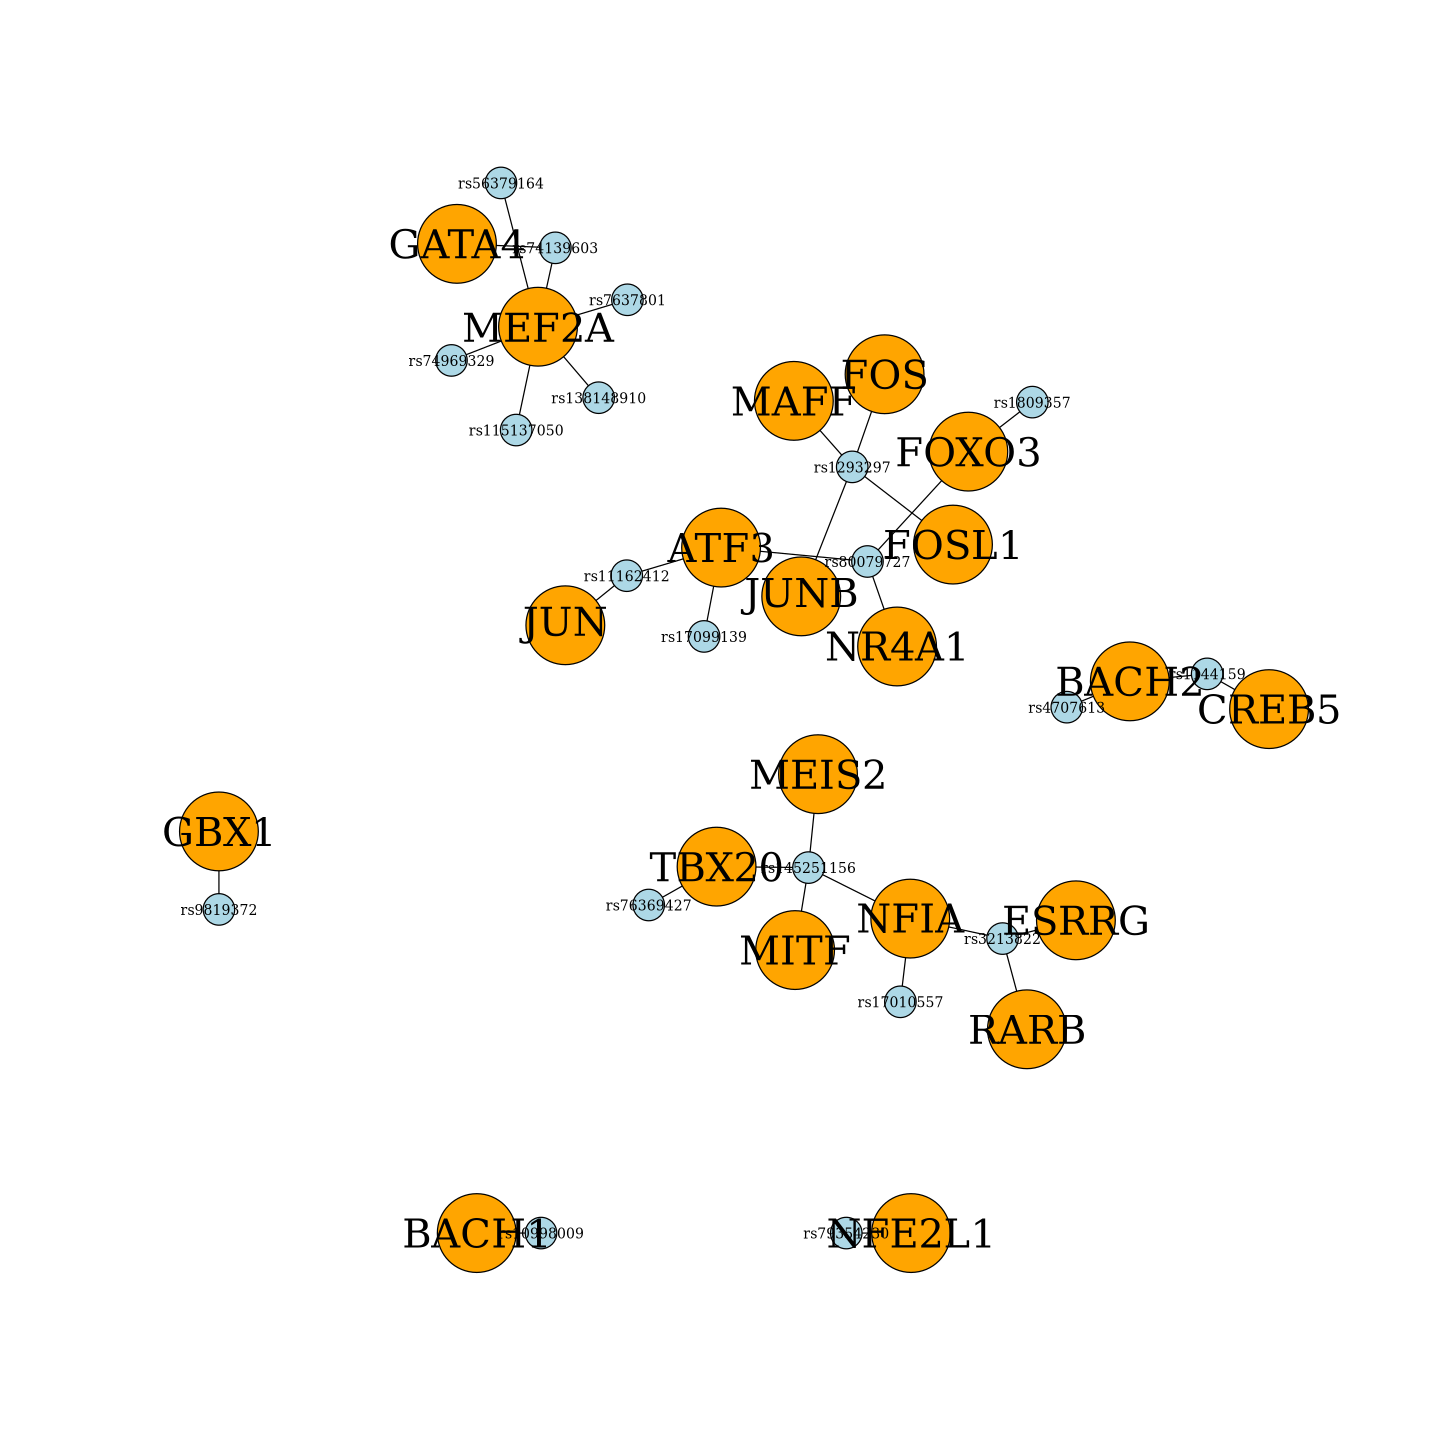

In [1147]:
options(repr.plot.width = 12, repr.plot.height = 12)

set.seed(10)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)

pdf(paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
           "vCM_80Loci_GRN.pdf"), width = 12, height = 10)
set.seed(10)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

# Set the output file format to SVG
svg(paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_GRN.svg"), 
    width = 12, height = 10)

# Generate the plot
set.seed(10)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)

# Close the SVG device
dev.off()

png 
  2

png 
  2

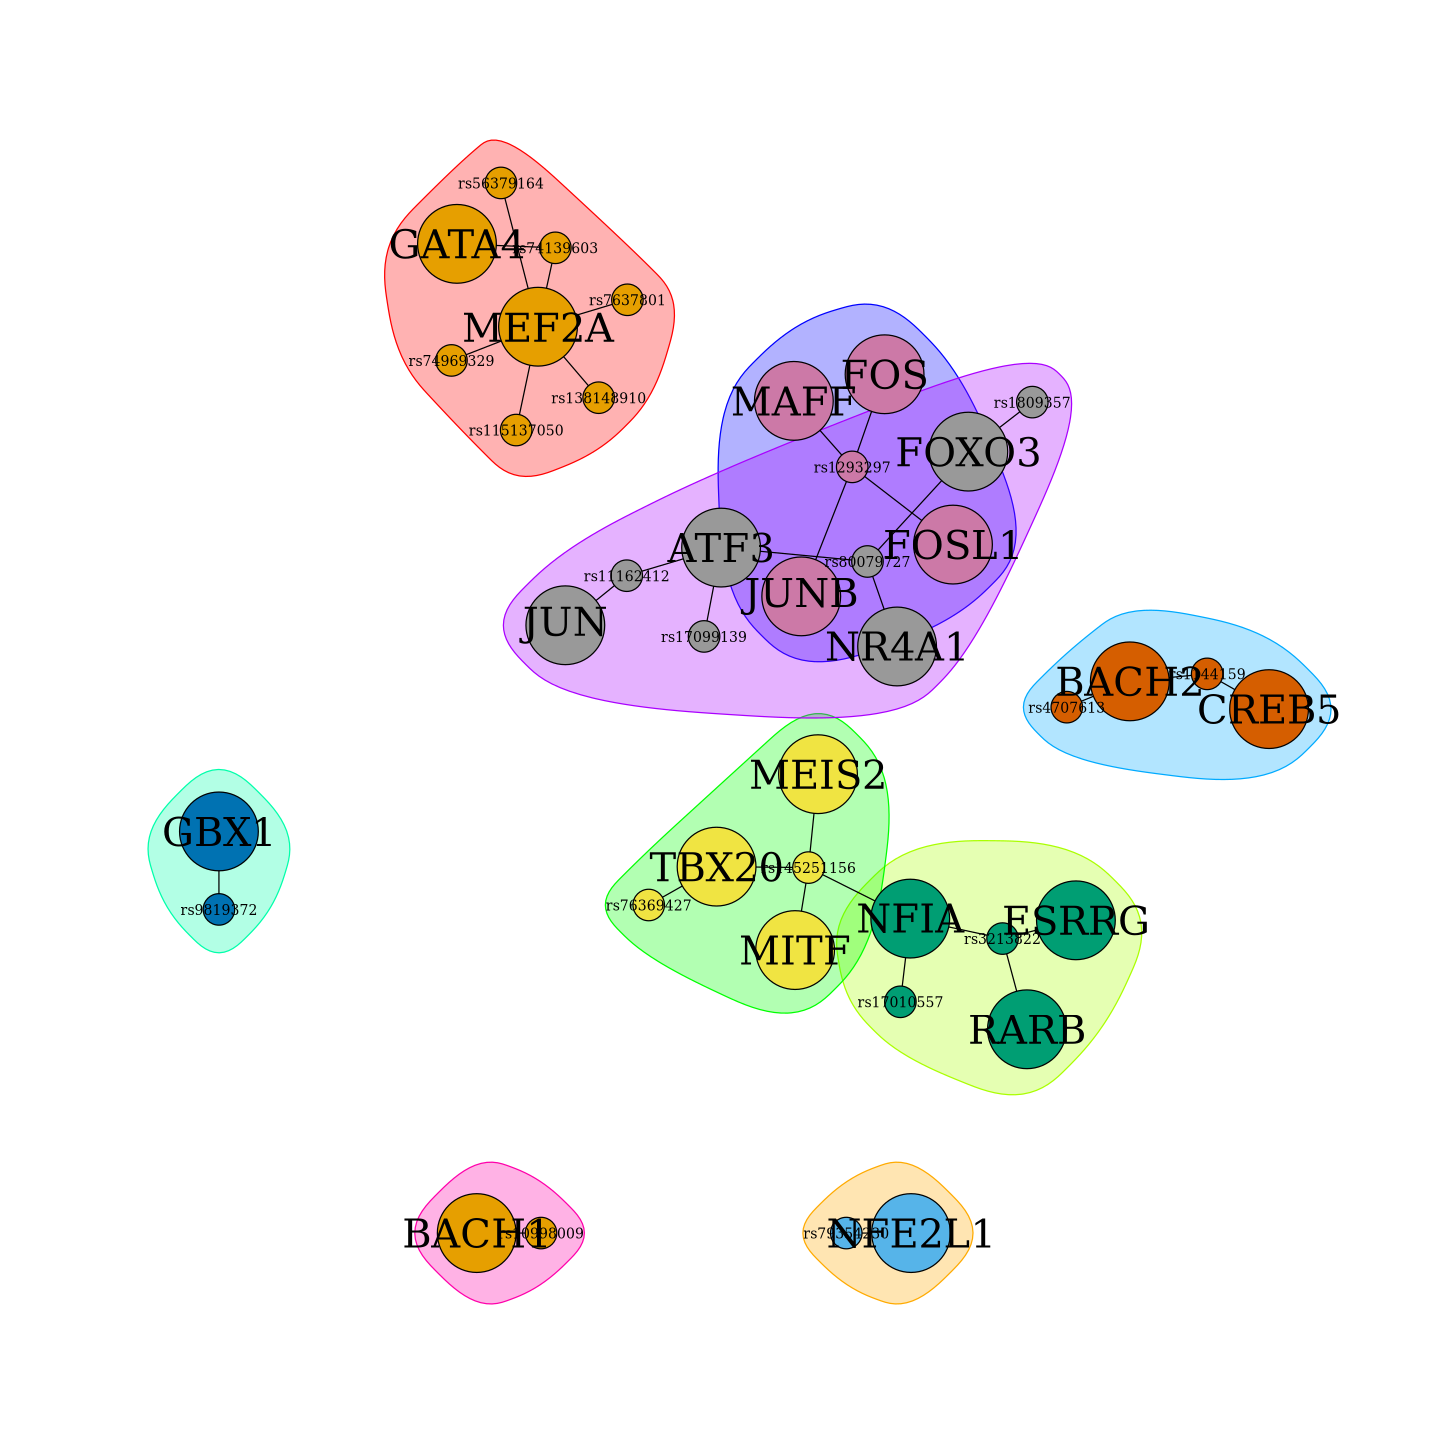

In [1148]:
options(repr.plot.width = 12, repr.plot.height = 12)
set.seed(10)

plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)

pdf(paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
           "vCM_80Loci_GRN_Clustered.pdf"), width = 12, height = 10)
set.seed(10)
plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

svg(paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "vCM_80Loci_GRN_Clustered.xml"), 
    width = 12, height = 10)

set.seed(10)
plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

## HF related GRNs

In [2889]:
# Take out genes for GSEA
GRN.HF_asso = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/scenicplus/HF_associated_TF_GRN.tsv")%>%
    dplyr::mutate(Peak_ID = sub(":", "-", Region),
                  GRN_ID = gsub(pattern = "_[+-]_[+-]", replacement = "", x = Consensus_name)) 

message("Total regulons: ", length(unique(GRN.HF_asso$GRN_ID)))

GRN.HF_asso = GRN.HF_asso %>%
    dplyr::filter(celltype == "vCM")
  message("Total regulons in VCM: ", length(unique(GRN.HF_asso$GRN_ID)))                     

Total regulons: 64

Total regulons in VCM: 34



In [2706]:
# Load GRN - HF and Controls
GRN.HF = GRN.HF_asso %>%
    dplyr::filter(celltype == "vCM" & 
                       TF == "up")
GRN.CTR = GRN.HF_asso %>%
    dplyr::mutate(Peak_ID = sub(":", "-", Region),
                  GRN_ID = gsub(pattern = "_[+-]_[+-]", replacement = "", x = Consensus_name)) %>%
    dplyr::filter(celltype == "vCM" & 
                       TF == "down")

message("Unique target genes in disease: ", length(unique(GRN.HF$Gene)))
message("Unique target genes in controls: ", length(unique(GRN.CTR$Gene)))

Unique target genes in disease: 786

Unique target genes in controls: 363



In [2870]:
# What Peaks in the GRN have variant in it that hits a target gene?
GRN.HF.overlap = overlap_data.DIFF %>%
  dplyr::filter(celltype == "vCM") %>%
  inner_join(GRN.HF, by = c("Peak_ID"))

GRN.CTR.overlap = overlap_data.DIFF %>%
  dplyr::filter(celltype == "vCM") %>%
  inner_join(GRN.CTR, by = c("Peak_ID"))

message("Unique target genes in disease: ", length(unique(GRN.HF.overlap$Gene)))
message("Unique target genes in controls: ", length(unique(GRN.CTR.overlap$Gene)))

Unique target genes in disease: 2

Unique target genes in controls: 5



In [2871]:
GRN.HF.overlap %>%
  pull(Gene) %>%
  unique()

GRN.CTR.overlap %>%
  pull(Gene) %>%
  unique()

[1] "MAP3K7" "BACH2"

[1] "PROX1"  "OBSCN"  "PDZRN3" "EPHB1"  "KY"

In [2872]:
"7 genes have a peak that's both part of a GRN and has a target gene"

[1] "7 genes have a peak that's both part of a GRN and has a target gene"

In [2873]:
# What regulons have at least one peak that has a variant in it?
GRN.HF.ID = GRN.HF.overlap %>%
  pull(GRN_ID) %>%
  unique()
GRN.HF.ID

GRN.CTR.ID = GRN.CTR.overlap %>%
  pull(GRN_ID) %>%
  unique()
GRN.CTR.ID

[1] "BACH2" "CREB5"

[1] "GATA4" "MEF2A" "MEIS2" "TBX20"

In [2874]:
# Here I quickly checked that HF regulons are only in HF and viceversa
"HF"
dplyr::filter(GRN.HF, GRN_ID == "BACH2") %>%
  pull(Gene) %>%
  unique()
"CTR"
dplyr::filter(GRN.CTR, GRN_ID == "MEF2A") %>%
  pull(Gene) %>%
  unique()

[1] "HF"

[1] "USP53"    "DDX60L"   "BCL2"     "ZDHHC14"  "NAV2"     "JAK2"    
 [7] "PPM1B"    "DST"      "KIF13A"   "PTPN9"    "PDE10A"   "FEZ2"    
[13] "RUNX2"    "RPS6KA2"  "TMEM71"   "PDLIM1"   "ATP8A1"   "WIPF3"   
[19] "ZNF385D"  "MAP2"     "CRIM1"    "RRAS2"    "NPR3"     "CALD1"   
[25] "PDE8B"    "ROR1"     "ETV1"     "EXT1"     "SUPT3H"   "PCDH9"   
[31] "TBC1D9"   "FGF1"     "XIRP2"    "TRIM44"   "PTPN11"   "MAP3K3"  
[37] "CAMK2D"   "COL21A1"  "TPM3"     "COLQ"     "FOXO1"    "CTNND2"  
[43] "FARP1"    "ARHGAP24" "HERC4"    "CBFB"     "BACH2"    "DCBLD2"  
[49] "FRY"      "FNDC3B"   "MAP3K7"   "SPOCK1"   "FOXP2"    "PPM1H"   
[55] "SLC6A6"   "WWC2"     "GREB1L"   "TENM3"    "HDAC9"    "DOCK4"   
[61] "INPP4B"   "NT5C2"    "MAGI2"    "SLC2A13"  "TXK"      "PROS1"   
[67] "UACA"     "NPPB"     "COL19A1"  "ANO6"     "TSC22D2"  "ST3GAL6" 
[73] "FAM13C"   "XPR1"     "STAT4"    "SLC39A10" "LAMA2"    "CREB5"   
[79] "FBXW11"   "ADAM19"   "MARCH3"   "PLCE1"    "CPED1"    "ANTXR2"  
[85] "PIP4K2A"  "ZNF451"

[1] "CTR"

[1] "STXBP6"   "SORBS1"   "TNNI3K"   "PARM1"    "RBFOX1"   "CEP85L"  
  [7] "MEIS2"    "NFIA"     "PCGF5"    "SLC8A1"   "LIMS2"    "LCLAT1"  
 [13] "B4GALNT3" "SIPA1L2"  "TMEM131L" "PACRG"    "MICAL3"   "RYR2"    
 [19] "DOCK3"    "CORIN"    "TXNIP"    "PRDM16"   "RBFOX2"   "SSBP3"   
 [25] "SLCO3A1"  "SGMS1"    "MEF2A"    "ADD3"     "SDK1"     "CLGN"    
 [31] "FHL2"     "GRXCR2"   "ADAMTS7"  "FAM160A1" "TRIQK"    "LGALS3BP"
 [37] "PPP1R1C"  "STAG1"    "PDE1C"    "PPP1R12B" "TMEM65"   "ADGRL2"  
 [43] "A4GALT"   "PKP2"     "MSI2"     "IDH2"     "EDA"      "LIN9"    
 [49] "ABLIM1"   "MTUS2"    "MRAS"     "DAB2IP"   "PTPRG"    "ZNF91"   
 [55] "DAAM1"    "TESC"     "ZMAT4"    "TLN2"     "THSD4"    "KCNN2"   
 [61] "CDH13"    "SEMA6D"   "NEK7"     "RCSD1"    "SGCD"     "NCAM1"   
 [67] "PRKAA2"   "EPB41"    "NAV1"     "HIF3A"    "PROX1"    "SH3RF2"  
 [73] "ART3"     "BSG"      "DAPK2"    "MLLT10"   "RASGRP3"  "CASZ1"   
 [79] "PATJ"     "PAIP2B"   "NRP1"     "RBM20"    "TRIM2"    "CCBE1"   
 [85] "PPARGC1B" "RHOQ"     "RCAN2"    "PPP2R5C"  "RUNX1T1"  "RBMS1"   
 [91] "SGIP1"    "ADCY9"    "ATXN1"    "ADCY5"    "PDZRN3"   "LARGE1"  
 [97] "DAB1"     "CACNB2"   "TENM2"    "NEBL"     "OBSCN"    "HRH2"    
[103] "AQP7"     "QKI"      "CCDC141"  "ZNF638"   "PRELID2"  "LRRFIP1" 
[109] "FAM124A"  "TPM1"     "FIGN"     "TBX20"    "GJA1"     "SPHKAP"  
[115] "MYOCD"    "SCAPER"   "ZNRF1"    "PMP22"    "AUTS2"    "CGNL1"   
[121] "ROR1"     "FGF12"    "PDE3A"    "LARP4B"   "ALPK2"    "PLEKHA7" 
[127] "MTSS1"    "MARCH11"  "ABR"      "AOPEP"    "TTN"      "SLC16A7" 
[133] "FSD2"     "RASSF3"   "RGL1"     "ADAM10"   "C15orf41" "KY"      
[139] "TMEM159"

In [2875]:
GRN.HF.overlap = GRN.HF %>%
  dplyr::filter(GRN_ID %in% GRN.HF.ID)%>%
  pull(Gene) %>%
  unique()

GRN.CTR.overlap = GRN.CTR %>%
  dplyr::filter(GRN_ID %in% GRN.CTR.ID)%>%
  pull(Gene) %>%
  unique()

message("Unique target genes in disease: ", length(unique(GRN.HF.overlap)))
message("Unique target genes in controls: ", length(unique(GRN.CTR.overlap)))

Unique target genes in disease: 197

Unique target genes in controls: 229



In [2848]:
write.table(GRN.HF.overlap, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/GRN_HFvariants_vCM_HF_targetGenes.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

write.table(GRN.CTR.overlap, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/GRN_HFvariants_vCM_CTR_targetGenes.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [2756]:
# I ran GSEA on the website - top 100 CP, min10, max500 - here top pathways
HF.pathways = c("VEGFA-VEGFR2 signaling", 
                "Regulation of actin cytoskeleton", 
                "Striated muscle contraction pathway",
                "MAPK family signaling cascades",
                "Diseases of signal transduction by growth factor receptors and second messengers", 
                "Tight junction",
                "Hypertrophy model", 
                "MAPK signaling pathway", 
                "IL18 signaling")

CTR.pathways = c("Arrhythmogenic right ventricular cardiomyopathy (ARVC)",
                 "Myometrial relaxation and contraction pathways", 
                 "Muscle contraction", 
                 "Dilated cardiomyopathy", 
                 "Cardiogenesis", 
                 "Hypertrophic cardiomyopathy (HCM)", 
                 "Cardiac conduction", 
                 "Calcium regulation in cardiac cells", 
                 "Heart development")

In [2809]:
# I ran GSEA on the website - top 100 CP, min10, max500 - here top pathways
HF.pathways = c("Striated muscle contraction pathway",
                "MAPK family signaling cascades",
                "Hypertrophy model", 
                "MAPK signaling pathway", 
                "IL18 signaling")

CTR.pathways = c("Arrhythmogenic right ventricular cardiomyopathy (ARVC)",
                 "Myometrial relaxation and contraction pathways", 
                 "Muscle contraction", 
                 "Dilated cardiomyopathy", 
                 "Cardiogenesis", 
                 "Hypertrophic cardiomyopathy (HCM)", 
                 "Cardiac conduction", 
                 "Calcium regulation in cardiac cells", 
                 "Heart development")

In [2810]:
# I ran GSEA on the website - top 100 CP, min10, max500
GSEA.CTR = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/GSEA_GRN_CTR_variants_vCM_HF.tsv")%>%
            dplyr::filter(Description %in% CTR.pathways) %>%
  rename_with(~ gsub(" ", "_", .x, fixed = TRUE)) %>%
  dplyr::mutate(log_FDR = -log10(`FDR_q-value`)) %>%
  dplyr::mutate(condition = "NON_HF")

GSEA.HF = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/GSEA_GRN_HF_variants_vCM_HF.tsv")%>%
            dplyr::filter(Description %in% HF.pathways)%>%
  rename_with(~ gsub(" ", "_", .x, fixed = TRUE)) %>%
  dplyr::mutate(log_FDR = -log10(`FDR_q-value`)) %>%
  dplyr::mutate(condition = "HF")

GSEA = rbind(GSEA.CTR, GSEA.HF)

In [ ]:
options(repr.plot.width = 11, repr.plot.height = 10)
# Create the bubble plot
gg = ggplot(GSEA, aes(x = log_FDR, 
                     y = reorder(Gene_Set_Name, log_FDR), 
                     size = `k/K`,  # Use actual overlap size for bubbles
                     fill = condition)) +  # Fill based on -log10(FDR q-value)
  geom_point(shape = 21, color = "black") +  # Black outline for better visibility
  scale_fill_manual(values = c("HF" = "#CAB2D6", "NON_HF" = "#B2DF8A")) +  # Custom fill colors
  scale_size_continuous(range = c(2, 10)) +  # Control bubble size range
  labs(x = "", 
       y = "", 
       size = "", 
       fill = "") +
  xlim(0, 7)+
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Keep the legend visible
  )
gg

# Integrate with aCM - GRN

In [2916]:
Scenic_Plus = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/scenicplus/aCM/edges_R2G.csv") %>%
  dplyr::mutate(
    Peak_ID = sub(":", "-", Region),
    GRN_ID = gsub(pattern = "_[+-]_[+-]", replacement = "", x = Consensus_name)) %>%
  dplyr::select(Peak_ID, GRN_Gene = Gene, GRN_ID, Consensus_name)
message("Unique peaks in the GRN: ", length(unique(Scenic_Plus$Peak_ID)))
message("Unique Regulons in the GRN: ", length(unique(Scenic_Plus$GRN_ID)))

# load GRN we care about
GRN_use = fread("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Cell_Subtypes/scenicplus/aCM_GRN_regulons.csv") %>%
            dplyr::select(GRN_ID = name, cluster)
message("Unique Regulons in the GRN: ", length(unique(GRN_use$GRN_ID)))

GRN_use = GRN_use %>%
    right_join(Scenic_Plus, by = "GRN_ID")
message("Unique Regulons in the GRN: ", length(unique(GRN_use$GRN_ID)))

Unique peaks in the GRN: 7353

Unique Regulons in the GRN: 134

Unique Regulons in the GRN: 69

Unique Regulons in the GRN: 134



In [2932]:
dplyr::filter(overlap_data.all, rsID == "rs77070670")

seqnames start   end     width strand rsID       PPA          Locus  
1 chr1     6589241 6589242 2     *      rs77070670 0.0001396735 locus_3
2 chr1     6589241 6589242 2     *      rs77070670 0.0001396735 locus_3
  Peak_ID              celltype chromSTATE Celltype_Peak_ID             
1 chr1-6589165-6589465 Myeloid  Active     Myeloid--chr1-6589165-6589465
2 chr1-6589165-6589465 Myeloid  ATAC       Myeloid--chr1-6589165-6589465
  celltype.collapse
1 Myeloid          
2 Myeloid

In [2918]:
overlap_data.DIFF.GRN = overlap_data.DIFF %>%
  dplyr::filter(celltype == "aCM" & chromSTATE == "ATAC") %>%
  inner_join(GRN_use, by = c("Peak_ID")) %>%
  tidyr::replace_na(list(ATAC_DESeq2 = "NS")) %>%
  distinct()
message("Unique Regulons in the GRN: ", length(unique(overlap_data.DIFF.GRN$GRN_ID)))

overlap_data.DIFF.GRN

Unique Regulons in the GRN: 37



seqnames start     end       width strand rsID        PPA           Locus   
1  chr1     214111955 214111956 2     *      rs116538385 0.01020304493 locus_10
2  chr1     214107515 214107516 2     *      rs74139603  0.00980491364 locus_10
3  chr1     214107515 214107516 2     *      rs74139603  0.00980491364 locus_10
4  chr1     228165949 228165950 2     *      rs55873785  0.00034346283 locus_11
5  chr1     228165949 228165950 2     *      rs55873785  0.00034346283 locus_11
6  chr1     228165949 228165950 2     *      rs55873785  0.00034346283 locus_11
7  chr1     228165949 228165950 2     *      rs55873785  0.00034346283 locus_11
8  chr1     228165949 228165950 2     *      rs55873785  0.00034346283 locus_11
9  chr2      11420112  11420113 2     *      rs6736199   0.01540699805 locus_13
10 chr2      11419850  11419851 2     *      rs6750499   0.01129136922 locus_13
11 chr3      73490929  73490930 2     *      rs3213822   0.00082135013 locus_22
12 chr3      73622195  73622196 2     *      rs57686766  0.00078218420 locus_22
13 chr3      73622195  73622196 2     *      rs57686766  0.00078218420 locus_22
14 chr3      73147725  73147726 2     *      rs142378494 0.00046864056 locus_22
15 chr3      73624426  73624427 2     *      rs6763344   0.00030104979 locus_22
16 chr3      73622181  73622182 2     *      rs150318491 0.00026874270 locus_22
17 chr3      73622181  73622182 2     *      rs150318491 0.00026874270 locus_22
18 chr3      73147698  73147699 2     *      rs138123744 0.00018554497 locus_22
19 chr3      73624371  73624372 2     *      rs112594802 0.00014369496 locus_22
20 chr3      73622369  73622370 2     *      rs116330059 0.00013058567 locus_22
21 chr3      73622369  73622370 2     *      rs116330059 0.00013058567 locus_22
22 chr3      73144468  73144469 2     *      rs17010557  0.00005468101 locus_22
23 chr3     134374430 134374431 2     *      rs143146952 0.00010154972 locus_23
24 chr3     158571020 158571021 2     *      rs9819631   0.01200095827 locus_24
25 chr1       6058883   6058884 2     *      rs6577479   0.00053143533 locus_3 
26 chr1       6350456   6350457 2     *      rs77244496  0.00026217516 locus_3 
27 chr1       6058632   6058633 2     *      rs11576563  0.00026170599 locus_3 
28 chr1       6205307   6205308 2     *      rs2272988   0.00011752624 locus_3 
29 chr6      90400309  90400310 2     *      rs62408252  0.00042341723 locus_33
30 chr6      90537980  90537981 2     *      rs1144159   0.00011665566 locus_33
⋮  ⋮        ⋮         ⋮         ⋮     ⋮      ⋮           ⋮             ⋮       
45 chr11    111731407 111731408 2     *      rs117680887 0.00009381241 locus_50
46 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
47 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
48 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
49 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
50 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
51 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
52 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
53 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
54 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
55 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
56 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
57 chr12     26195495  26195496 2     *      rs113819537 0.07052150637 locus_51
58 chr12     26195495  26195496 2     *      rs113819537 0.07052150637 locus_51
59 chr16     67246335  67246336 2     *      rs6499120   0.00023932581 locus_65
60 chr16     67246335  67246336 2     *      rs6499120   0.00023932581 locus_65
61 chr16     67246335  67246336 2     *      rs6499120   0.00023932581 locus_65
62 chr16     67246335  67246336 2     *      rs6499120   0.00023932581 locus_65
63 

In [2919]:
# Save table
write.table(overlap_data.DIFF.GRN,
            file = paste("/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_aCMregulons_intersect.txt", sep = ""),
            col.names = F, row.names = F, sep = "\t", quote = F)

In [2901]:
overlap_data.DIFF.GRN %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order)
  ) %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(celltype, chromSTATE) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    signal.overlap = length(unique(Locus)),
    peaks.on.variant = length(unique(Peak_ID)),
    GRN_Gene = length(unique(GRN_Gene[!is.na(GRN_Gene)])), # Ignore NAs
    GRN_Consensus_name = length(unique(GRN_ID[!is.na(GRN_ID)])), # Ignore NAs      
    .groups = "drop" 
) 

celltype chromSTATE variant.overlap signal.overlap peaks.on.variant GRN_Gene
1 aCM      ATAC       42              21             33               27      
2 aCM      Open        1               1              1                1      
3 aCM      Active     41              20             32               26      
  GRN_Consensus_name
1 37                
2  1                
3 37

In [2902]:
test = dplyr::filter(overlap_data.DIFF.GRN, GRN_ID == "FOSL2")

In [2904]:
test

seqnames start     end       width strand rsID        PPA           Locus   
1  chr8      11742723  11742724 2     *      rs11785912  0.00005851218 locus_36
2  chr11    111731465 111731466 2     *      rs117071248 0.00009529833 locus_50
3  chr11    111731407 111731408 2     *      rs117680887 0.00009381241 locus_50
4  chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
5  chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
6  chr8      11742723  11742724 2     *      rs11785912  0.00005851218 locus_36
7  chr11    111731465 111731466 2     *      rs117071248 0.00009529833 locus_50
8  chr11    111731407 111731408 2     *      rs117680887 0.00009381241 locus_50
9  chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
10 chr11    111694850 111694851 2     *      rs190445961 0.00008698019 locus_50
   Peak_ID                   celltype chromSTATE Celltype_Peak_ID              
1  chr8-11742521-11742791    aCM      Active     aCM--chr8-11742521-11742791   
2  chr11-111731295-111731595 aCM      Active     aCM--chr11-111731295-111731595
3  chr11-111731295-111731595 aCM      Active     aCM--chr11-111731295-111731595
4  chr11-111694776-111695076 aCM      Active     aCM--chr11-111694776-111695076
5  chr11-111694776-111695076 aCM      Active     aCM--chr11-111694776-111695076
6  chr8-11742521-11742791    aCM      ATAC       aCM--chr8-11742521-11742791   
7  chr11-111731295-111731595 aCM      ATAC       aCM--chr11-111731295-111731595
8  chr11-111731295-111731595 aCM      ATAC       aCM--chr11-111731295-111731595
9  chr11-111694776-111695076 aCM      ATAC       aCM--chr11-111694776-111695076
10 chr11-111694776-111695076 aCM      ATAC       aCM--chr11-111694776-111695076
   celltype.collapse contrast     ATAC_DESeq2 ATAC_L2FC  GRN_ID cluster
1  CM                HF_vs_NON_HF NS          0.03891034 FOSL2  C3     
2  CM                HF_vs_NON_HF NS          0.19209682 FOSL2  C3     
3  CM                HF_vs_NON_HF NS          0.19209682 FOSL2  C3     
4  CM                HF_vs_NON_HF NS          0.68815035 FOSL2  C3     
5  CM                HF_vs_NON_HF NS          0.68815035 FOSL2  C3     
6  CM                HF_vs_NON_HF NS          0.03891034 FOSL2  C3     
7  CM                HF_vs_NON_HF NS          0.19209682 FOSL2  C3     
8  CM                HF_vs_NON_HF NS          0.19209682 FOSL2  C3     
9  CM                HF_vs_NON_HF NS          0.68815035 FOSL2  C3     
10 CM                HF_vs_NON_HF NS          0.68815035 FOSL2  C3     
   GRN_Gene Consensus_name
1  CTSB     FOSL2_+_+     
2  ALG9     FOSL2_+_+     
3  ALG9     FOSL2_+_+     
4  PPP2R1B  FOSL2_+_+     
5  ALG9     FOSL2_+_+     
6  CTSB     FOSL2_+_+     
7  ALG9     FOSL2_+_+     
8  ALG9     FOSL2_+_+     
9  PPP2R1B  FOSL2_+_+     
10 ALG9     FOSL2_+_+

In [2903]:
unique(test$rsID)

[1] "rs11785912"  "rs117071248" "rs117680887" "rs190445961"

In [1153]:
stats = overlap_data.DIFF.GRN %>%
  dplyr::mutate(
    celltype = factor(celltype, levels = celltype.order),
    chromSTATE = case_when(
      chromSTATE == "ATAC" ~ "ATAC",     
      chromSTATE == "E1" ~ "Repressive",
      chromSTATE == "E2" ~ "Unknown",
      chromSTATE == "E3" ~ "Open",
      chromSTATE == "E4" ~ "Weak",
      chromSTATE == "E5" ~ "Active",
      TRUE ~ as.character(chromSTATE)
    ),
    chromSTATE = factor(chromSTATE, levels = ES.order)
  ) %>%
  dplyr::filter(chromSTATE %in% states.plot) %>%
  dplyr::group_by(GRN_ID) %>%
  dplyr::summarize(
    variant.overlap = length(unique(rsID)),
    subpops = paste(unique(cluster[!is.na(cluster)]), collapse = ", "),
    .groups = "drop") %>%
dplyr::arrange(subpops)
stats

GRN_ID  variant.overlap subpops
1  BACH1   3                      
2  ELF1    2                      
3  NFIA    5                      
4  NRF1    1                      
5  SMAD3   1                      
6  STAT3   1                      
7  TCF12   5                      
8  ZBTB20  5                      
9  ZBTB43  1                      
10 ZNF148  3                      
11 GATA4   1               C1     
12 PBX3    1               C1     
13 PHF21A  3               C1     
14 SOX5    1               C1     
15 MEF2A   3               C2     
16 NFYC    1               C2     
17 ATF3    1               C3     
18 CREB3L2 1               C3     
19 CREM    1               C3     
20 FOS     1               C3     
21 FOSL2   4               C3     
22 KLF6    1               C3     
23 RARB    2               C3     
24 SRF     1               C3     
25 ZNF644  2               C3     
26 NR3C1   1               C4     
27 RFX3    1               C4     
28 ZNF704  1               C4     
29 CREB5   2               C5     
30 BACH2   2               C6     
31 KLF9    2               C6     
32 ETV5    1               C7     
33 FOXO3   2               C7     
34 GATA6   1               C7     
35 MITF    1               C7     
36 PBX1    1               C7     
37 ZNF44   2               C7

In [1154]:
GRN.keep = stats %>%
    dplyr::filter(subpops != '') %>%
    dplyr::pull(GRN_ID)
GRN.keep

[1] "GATA4"   "PBX3"    "PHF21A"  "SOX5"    "MEF2A"   "NFYC"    "ATF3"   
 [8] "CREB3L2" "CREM"    "FOS"     "FOSL2"   "KLF6"    "RARB"    "SRF"    
[15] "ZNF644"  "NR3C1"   "RFX3"    "ZNF704"  "CREB5"   "BACH2"   "KLF9"   
[22] "ETV5"    "FOXO3"   "GATA6"   "MITF"    "PBX1"    "ZNF44"

In [1155]:
# Save overlap 
aCM_Scenic = overlap_data.DIFF.GRN %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast, ATAC_DESeq2, ATAC_L2FC,
                  target_Gene = GRN_Gene, Celltype_Peak_ID, chromSTATE,
                  rsID, PPA, Locus) %>%
    dplyr::mutate(loop_method = "Scenic",
                  interaction_distance = NA) %>%
    dplyr::select(Peak_ID, celltype.collapse, celltype, contrast,
                  ATAC_DESeq2, ATAC_L2FC, target_Gene, interaction_distance, 
                  Celltype_Peak_ID, chromSTATE, rsID, PPA, Locus, loop_method)

## Plot

In [1156]:
library(igraph)
library(ggraph)
library(tidyverse)

In [1157]:
# Step 1: Load your data and create the edge list
data <- overlap_data.DIFF.GRN

edges <- data %>%
  dplyr::select(rsID, GRN_ID, cluster)

# Step 2: Create an undirected graph
net <- graph_from_data_frame(d = edges,
                             directed = FALSE)

# Step 3: Add node attributes
V(net)$type <- ifelse(V(net)$name %in% data$rsID, "rsID", "netRN_ID")  
V(net)$color <- ifelse(V(net)$type == "rsID", "lightblue", "orange")  
V(net)$cluster <- data$cluster[match(V(net)$name, c(data$rsID, data$GRN_ID))]
V(net)$size <- ifelse(V(net)$type == "rsID", 6, 15) 
V(net)$label.cex <- ifelse(V(net)$type == "rsID", 0.7, 2) 
V(net)$shape <- ifelse(V(net)$type == "rsID", "circle", "circle")
V(net)$label.color <- "black"
E(net)$edge.color <- "gray80"

# Optional - simplify
#net <- simplify(net, remove.multiple = T, remove.loops = T) 

# Perform Community Detection Using Edge Betweenness
ceb <- cluster_edge_betweenness(net)
clp <- cluster_label_prop(net)
louvain <- cluster_louvain(net, resolution = 1)

png 
  2

png 
  2

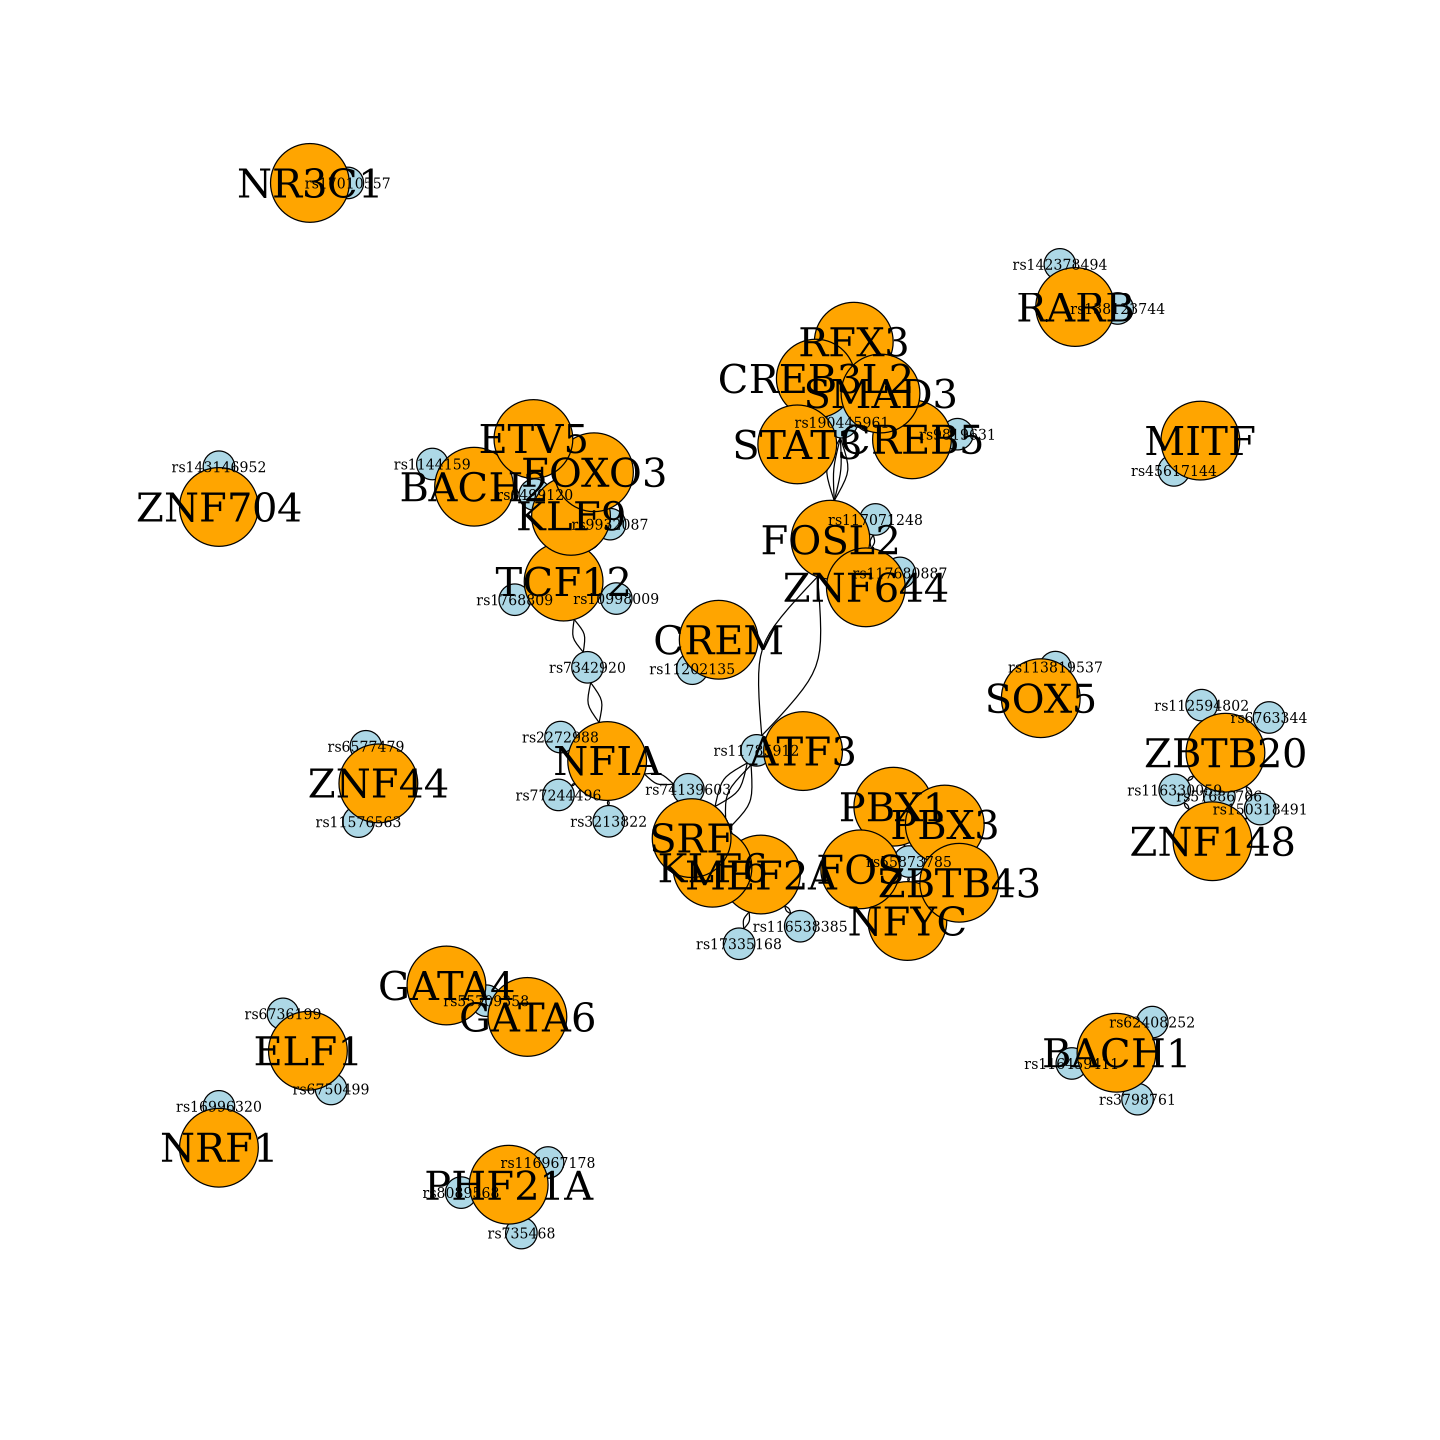

In [1158]:
options(repr.plot.width = 12, repr.plot.height = 12)

set.seed(15)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)

pdf(paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
           "aCM_80Loci_GRN.pdf"), width = 12, height = 10)
set.seed(15)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

svg(paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "aCM_80Loci_GRN.svg"), 
    width = 12, height = 10)

set.seed(15)
plot(net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

png 
  2

png 
  2

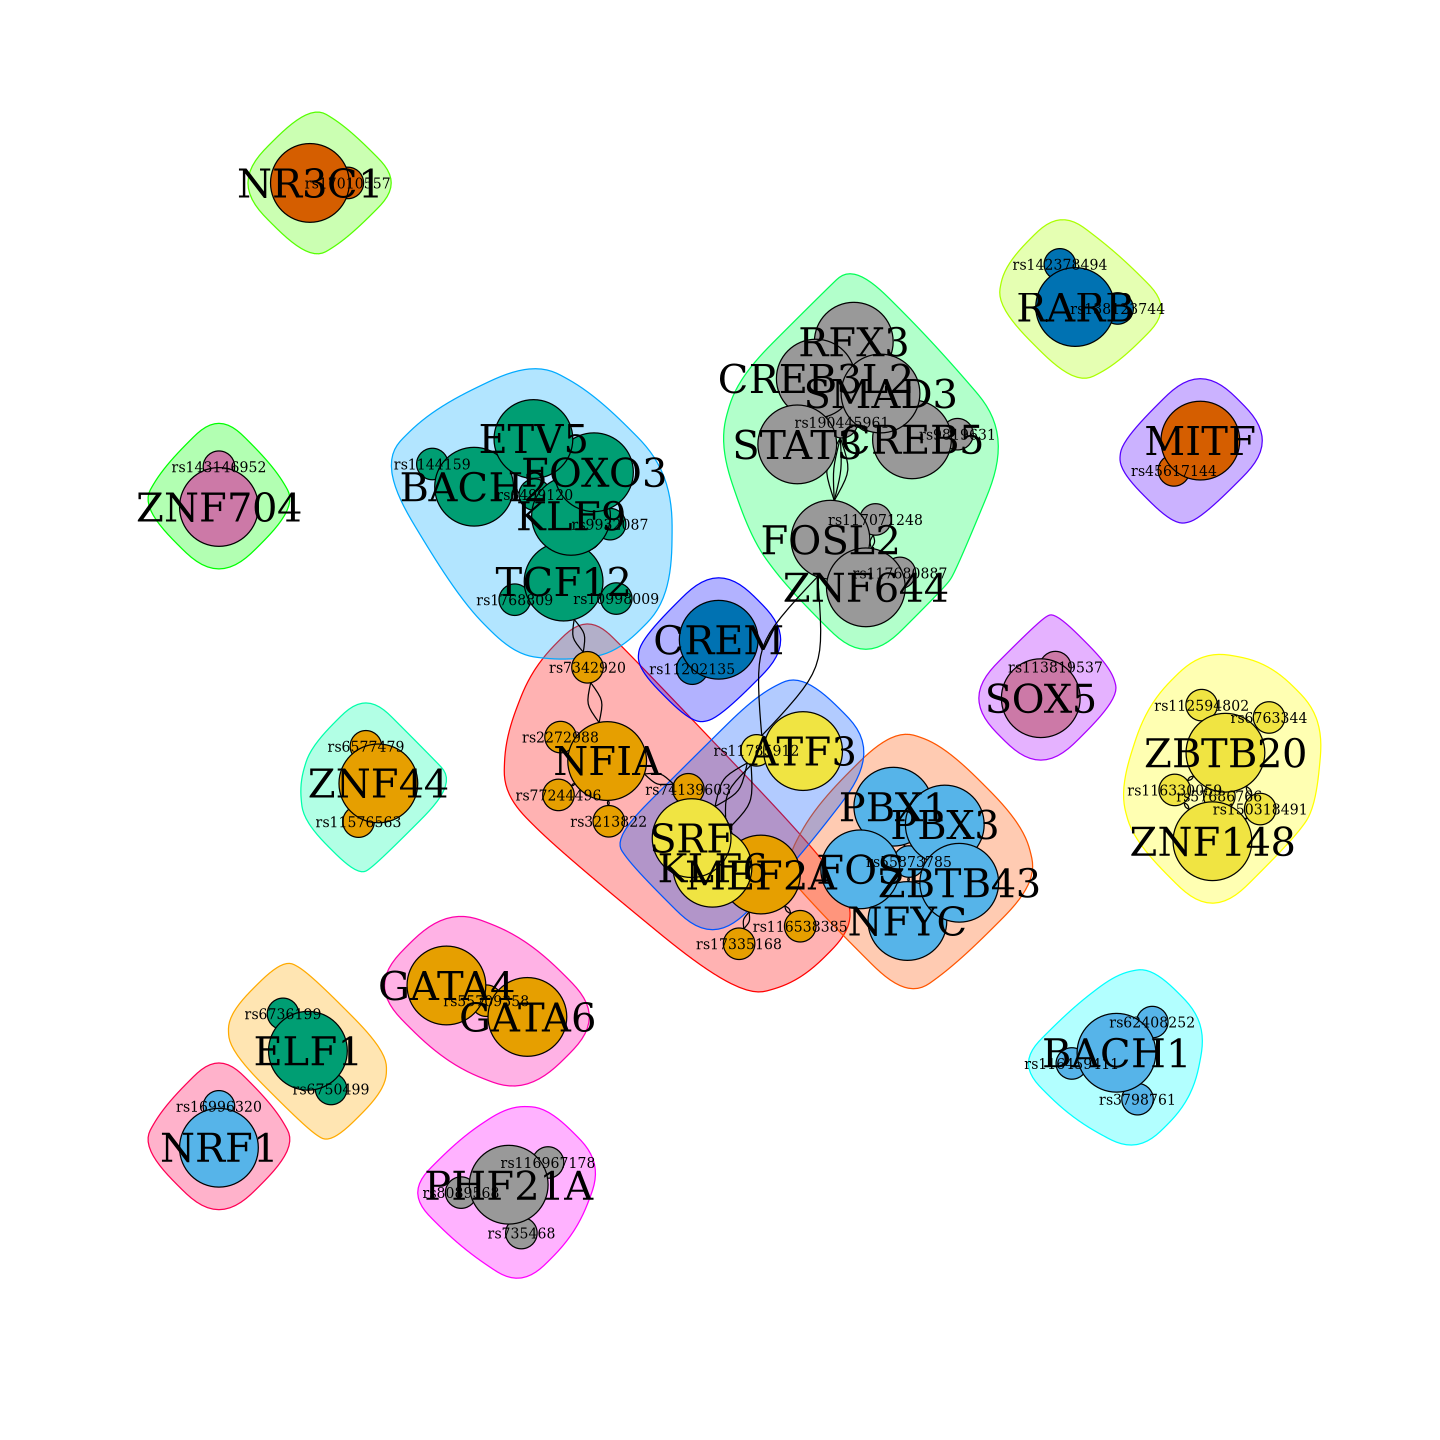

In [1159]:
options(repr.plot.width = 12, repr.plot.height = 12)
set.seed(15)

plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)

pdf(paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
           "aCM_80Loci_GRN_Clustered.pdf"), width = 12, height = 10)
set.seed(15)
plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

svg(paste0("/nfs/lab/projects/mega_heart/Plots_figures/", "aCM_80Loci_GRN_Clustered.svg"), 
    width = 12, height = 10)

set.seed(15)
plot(ceb, 
     net, 
        layout = layout_with_dh, 
        vertex.label = V(net)$name,
        vertex.color = ifelse(V(net)$type == "rsID", "lightblue", "orange"),
        edge.color = "black",
        vertex.label.cex = V(net)$label.cex, 
        vertex.label.dist = 0, vertex.label.degree = 0)
dev.off()

# Put Scenic, ABC, HiC together

In [1166]:
overlap_data.DIFF.loops.ABC.scenic = rbind(HiC, ABC, vCM_Scenic, aCM_Scenic)

In [1167]:
colnames(HiC)
colnames(ABC)
colnames(vCM_Scenic)
colnames(aCM_Scenic)

[1] "Peak_ID"              "celltype.collapse"    "celltype"            
 [4] "contrast"             "ATAC_DESeq2"          "ATAC_L2FC"           
 [7] "target_Gene"          "interaction_distance" "Celltype_Peak_ID"    
[10] "chromSTATE"           "rsID"                 "PPA"                 
[13] "Locus"                "loop_method"

[1] "Peak_ID"              "celltype.collapse"    "celltype"            
 [4] "contrast"             "ATAC_DESeq2"          "ATAC_L2FC"           
 [7] "target_Gene"          "interaction_distance" "Celltype_Peak_ID"    
[10] "chromSTATE"           "rsID"                 "PPA"                 
[13] "Locus"                "loop_method"

[1] "Peak_ID"              "celltype.collapse"    "celltype"            
 [4] "contrast"             "ATAC_DESeq2"          "ATAC_L2FC"           
 [7] "target_Gene"          "interaction_distance" "Celltype_Peak_ID"    
[10] "chromSTATE"           "rsID"                 "PPA"                 
[13] "Locus"                "loop_method"

[1] "Peak_ID"              "celltype.collapse"    "celltype"            
 [4] "contrast"             "ATAC_DESeq2"          "ATAC_L2FC"           
 [7] "target_Gene"          "interaction_distance" "Celltype_Peak_ID"    
[10] "chromSTATE"           "rsID"                 "PPA"                 
[13] "Locus"                "loop_method"

In [1168]:
message("Variants: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$rsID)))
message("Signals: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$Locus)))
message("Peaks: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$Celltype_Peak_ID)))

Variants: 1293

Signals: 62

Peaks: 3692



In [1169]:
# Subset for CM only
data.use = overlap_data.DIFF.loops.ABC.scenic %>%
    dplyr::filter(celltype.collapse %in% c("CM")) 
message("Post - CM subset")
message("Variants: ",length(unique(data.use$rsID)))
message("Signals: ",length(unique(data.use$Locus)))
message("Peaks: ",length(unique(data.use$Celltype_Peak_ID)))
message("target Genes: ",length(unique(data.use$target_Gene)))

Post - CM subset

Variants: 928

Signals: 58

Peaks: 1123

target Genes: 96



In [1170]:
unique(data.use$target_Gene)

[1] "TMEM182"                 "GXYLT2"                 
 [3] "PDZRN3"                  "ANAPC13, CEP63"         
 [5] "AMOTL2"                  "ICMT, HES3"             
 [7] "KLHL21"                  "GATA4"                  
 [9] "DEFB136"                 "NEIL2"                  
[11] "TATDN1, NDUFB9"          "TRAPPC9"                
[13] "TIAL1"                   "MYBPC3"                 
[15] "SLC39A13, PSMC3"         "ARFGAP2, PACSIN3"       
[17] "TSPAN1, P3R3URF"         "PIK3R3"                 
[19] "HSPB2, C11orf52, DIXDC1" "ALG9, FDXACB1, CFAP68"  
[21] "SIK2"                    "PPP2R1B"                
[23] "IL18, TEX12, BCO2"       "BHLHE41"                
[25] "COL4A1, COL4A2"          "CES3"                   
[27] "CBFB"                    "TMEM208, FHOD1"         
[29] "CIAO2B, CES2"            "HSF4, NOL3, MATCAP1"    
[31] "CDH16, RRAD"             "RANBP10, TSNAXIP1"      
[33] "FUBP1"                   "FHOD3"                  
[35] "GGT7, ACSS2"             "MATR3"                  
[37] "CXXC5"                   "STING1"                 
[39] "TLN1, CREB3"             "OPN4"                   
[41] "BMPR1A"                  NA                       
[43] "EBLN2"                   "KY"                     
[45] "TNFRSF25"                "FLNC"                   
[47] "CALU"                    "AC018638.6"             
[49] "FAM71F2"                 "ATP6V1F"                
[51] "AC018638.7"              "CTSB"                   
[53] "AL731569.1"              "LDB3"                   
[55] "BAG3"                    "AC018410.1"             
[57] "DLAT"                    "HSPB2"                  
[59] "CRYAB"                   "LCAT"                   
[61] "HSF4"                    "FBXL8"                  
[63] "NOL3"                    "AC103591.3"             
[65] "AC118549.1"              "AC139100.2"             
[67] "ADNP2"                   "MYH7B"                  
[69] "TAPT1"                   "TAPT1-AS1"              
[71] "PROB1"                   "PROX1"                  
[73] "OBSCN"                   "PPP4R2"                 
[75] "EPHB1"                   "MAP3K7"                 
[77] "DNAJB4"                  "NEXN"                   
[79] "MYPN"                    "BACH2"                  
[81] "ROCK2"                   "RYK"                    
[83] "MLF1"                    "NPHP4"                  
[85] "RNF207"                  "PPIL4"                  
[87] "MAST2"                   "ALG9"                   
[89] "RASSF8"                  "ITPR2"                  
[91] "CEP112"                  "PRKCA"                  
[93] "ATP9B"                   "KDM4B"                  
[95] "ZNF253"                  "HERC4"

In [1171]:
# Subset by PPA
data.use = data.use %>%
    dplyr::filter(PPA > 0.01)

message("Post - PPA subset")
message("Variants: ",length(unique(data.use$rsID)))
message("Signals: ",length(unique(data.use$Locus)))
message("Peaks: ",length(unique(data.use$Celltype_Peak_ID)))
message("target Genes: ",length(unique(data.use$target_Gene)))

Post - PPA subset

Variants: 47

Signals: 33

Peaks: 75

target Genes: 24



In [1172]:
# Subset for rsids we selected beforehand
data.use = data.use %>%
        dplyr::filter(rsID %in% variants.plot) %>%
        mutate(rsID = fct_reorder(rsID, PPA, .desc = FALSE)) %>%
        dplyr::arrange(-PPA)

message("Post - PPA subset")
message("Variants: ",length(unique(data.use$rsID)))
message("Signals: ",length(unique(data.use$Locus)))
message("Peaks: ",length(unique(data.use$Celltype_Peak_ID)))
message("target Genes: ",length(unique(data.use$target_Gene)))

Post - PPA subset

Variants: 24

Signals: 24

Peaks: 44

target Genes: 24



In [1173]:
length(unique(data.use$rsID))

[1] 24

In [1249]:
# Extract original rsID order
original_order <- unique(data.use$rsID)

# Group, summarize, and filter
df_filtered <- data.use %>%
  group_by(rsID, loop_method) %>%
  dplyr::summarize(
    TargetGenes = paste(unique(target_Gene[!is.na(target_Gene)]), collapse = ", "),
    .groups = "drop"
  ) %>%
  dplyr::filter(TargetGenes != "") %>%
  # Ensure rsID follows the original order
  mutate(rsID = factor(rsID, levels = original_order)) %>%
  arrange(rsID)  # This ensures the rows are sorted in the correct order

df_filtered

rsID        loop_method TargetGenes                                         
1  rs17099139  ABC         BAG3                                                
2  rs17099139  HiC         TIAL1                                               
3  rs17099139  Scenic      BAG3                                                
4  rs34866937  HiC         TATDN1, NDUFB9                                      
5  rs2848901   HiC         FHOD3                                               
6  rs113819537 HiC         BHLHE41                                             
7  rs113819537 Scenic      RASSF8, ITPR2                                       
8  rs2540277   HiC         TMEM182                                             
9  rs13277721  HiC         TRAPPC9                                             
10 rs735468    Scenic      KDM4B                                               
11 rs6736199   Scenic      ROCK2                                               
12 rs4835728   ABC         PROB1                                               
13 rs4835728   HiC         MATR3, CXXC5, STING1                                
14 rs754920    ABC         FLNC, CALU, AC018638.6, FAM71F2, ATP6V1F, AC018638.7
15 rs9819631   Scenic      MLF1                                                
16 rs116538385 Scenic      PROX1

scenic = FFA500
ABC = FF8C00
HiC = D35400

In [1206]:
write.table(data.use, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_CMs_Differential_25kbHiC_Scenic.txt", 
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

### Has a link?

In [1374]:
dplyr::filter(data.use, target_Gene == "KDM4B")

Peak_ID               celltype.collapse celltype contrast     ATAC_DESeq2
1 chr19-5054592-5054892 CM                aCM      HF_vs_NON_HF NS         
2 chr19-5054592-5054892 CM                aCM      HF_vs_NON_HF NS         
  ATAC_L2FC  target_Gene interaction_distance Celltype_Peak_ID          
1 -0.3312638 KDM4B       NA                   aCM--chr19-5054592-5054892
2 -0.3312638 KDM4B       NA                   aCM--chr19-5054592-5054892
  chromSTATE rsID     PPA        Locus    loop_method
1 Active     rs735468 0.01769478 locus_74 Scenic     
2 ATAC       rs735468 0.01769478 locus_74 Scenic

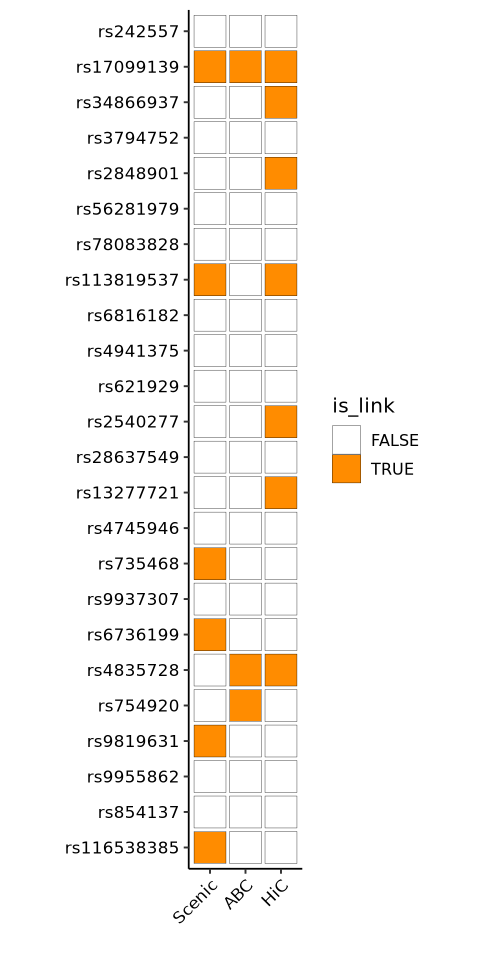

In [1246]:
df_link <- data.use %>%
  group_by(rsID, loop_method) %>%
  summarize(is_link = ifelse(any(!is.na(target_Gene)), TRUE, FALSE), .groups = "drop") %>%
  dplyr::mutate(loop_method = factor(loop_method, levels = c("Scenic", "ABC", "HiC")))

df_link = complete(df_link, rsID, loop_method,
                 fill = list(is_link = FALSE))

gg_link <- ggplot(df_link, aes(x = loop_method, y = rsID, fill = is_link)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  scale_fill_manual(values = c("FALSE" = "white", "TRUE" = "#FF8C00")) +
  labs(
    x = "", 
    y = ""
  ) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "right"  # Show legend for the viridis scale
  ) +
  coord_fixed()

gg_link

In [1247]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "vCM_80Loci_intersection_Link_allmethods.pdf"),
                            width = 4, height = 8, 
                            plot = gg_link, device = "pdf")

In [1356]:
variants.write = dplyr::filter(data.all.hg38, rsID %in% variants.plot)

In [1357]:
write.table(variants.write, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/VariantsPlot.cQTL.txt", 
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [1358]:
variants.write

rsID        pp         cs_nvar A1 A2 Locus    chr.hg38 end.hg38  start.hg38
1  rs116538385 0.01020304   34    C  G  locus_10 chr1     214111956 214111955 
2  rs6736199   0.01540700   27    C  T  locus_13 chr2      11420113  11420112 
3  rs2540277   0.04474717  834    C  T  locus_15 chr2     102809718 102809717 
4  rs56281979  0.11205983    7    C  T  locus_20 chr3      14232793  14232792 
5  rs9819631   0.01200096   17    C  G  locus_24 chr3     158571021 158571020 
6  rs6816182   0.06250974 2705    C  T  locus_25 chr4      16034373  16034372 
7  rs854137    0.01131893   58    A  C  locus_29 chr5      57662495  57662494 
8  rs4835728   0.01508379   36    C  T  locus_31 chr5     139419052 139419051 
9  rs754920    0.01490212   34    A  G  locus_35 chr7     128828358 128828357 
10 rs34866937  0.33044791   14    A  G  locus_38 chr8     124847608 124847607 
11 rs13277721  0.03283520  220    A  G  locus_39 chr8     140621294 140621293 
12 rs4745946   0.01950283   72    G  T  locus_43 chr10     68160771  68160770 
13 rs17099139  0.54352100    2    C  G  locus_47 chr10    119659975 119659974 
14 rs113819537 0.07052151    5    C  G  locus_51 chr12     26195496  26195495 
15 rs78083828  0.09574776    7    C  T  locus_56 chr12    132858948 132858947 
16 rs621929    0.04839864    8    A  G  locus_58 chr13    110286560 110286559 
17 rs9937307   0.01626175   68    C  T  locus_64 chr16       938197    938196 
18 rs242557    0.90708492    2    A  G  locus_67 chr17     45942346  45942345 
19 rs3794752   0.24081092    6    C  T  locus_68 chr17     55305468  55305467 
20 rs2848901   0.13742259   49    C  T  locus_71 chr18     36652647  36652646 
21 rs4941375   0.04907534   20    A  C  locus_72 chr18     58276903  58276902 
22 rs9955862   0.01139285 2965    C  T  locus_73 chr18     79257662  79257661 
23 rs735468    0.01769478   20    C  T  locus_74 chr19      5054729   5054728 
24 rs28637549  0.03387628   19    C  T  locus_76 chr19     45800370  45800369

In [1373]:
dplyr::filter(RNA.DESEQ, target_Gene %in%  data.use$target_Gene &
              celltype %in% c("aCM", "vCM") &
              RNA_DESeq2 != "NS"
             ) 

celltype target_Gene contrast     RNA_DESeq2 RNA_L2FC  
1 aCM      PROX1       HF_vs_NON_HF DOWN       -0.7982504
2 aCM      CXXC5       HF_vs_NON_HF DOWN       -0.9971863
3 vCM      CXXC5       HF_vs_NON_HF DOWN       -1.3843874
4 vCM      PROX1       HF_vs_NON_HF DOWN       -1.0181636
5 vCM      KDM4B       HF_vs_NON_HF DOWN       -0.3769283
6 vCM      PROB1       HF_vs_NON_HF DOWN       -0.8422385
7 vCM      TIAL1       HF_vs_NON_HF DOWN       -0.1769593
8 vCM      ROCK2       HF_vs_NON_HF UP          0.3863330

# Locus based visualization

## Their links

In [2462]:
# Load GWAS paper stats
GWAS_paper = read.table("/nfs/lab/projects/mega_heart/Assets/80Loci_gene_Prioritizaton.txt", 
           sep = "\t", header = TRUE) %>%
           mutate(across(where(is.logical), ~ replace(., is.na(.), FALSE)))

message("Signals: ",length(unique(GWAS_paper$Locus)))

Signals: 80



In [2494]:
# Get prioritized genes
LociAnno_GWAS_paper = GWAS_paper %>%
    group_by(Locus) %>%
    slice_max(order_by = Total_score, n = 1) %>%
    dplyr::filter(n() == 1) %>%
    ungroup()

message("Signals: ",length(unique(LociAnno_GWAS_paper$Locus)))

Link_ID.use = as.character(paste0(LociAnno_GWAS_paper$Locus, "--", LociAnno_GWAS_paper$Gene))

Signals: 62



In [2495]:
# Find unique elements in Our_loci and Hermes_loci that are NOT in loci_order
new_loci <- setdiff(c(Our_loci, Hermes_loci), loci_order)

# Concatenate loci_order first (preserving order) and add the new unique loci
loci_order.all <- c(loci_order, new_loci)

In [2496]:
# Generate the desired dataframe with discovery method
LociAnno_GWAS_paper <- GWAS_paper %>%
  mutate(
    discovery_method = case_when(
      Nearest == TRUE ~ "Nearest",
      PoPS == TRUE ~ "PoPS",
      V2G == TRUE ~ "V2G",
      TRUE ~ "Other" 
    )
  ) %>%
  dplyr::mutate(Link_ID = paste0(Locus, "--",Gene)) %>% 
  dplyr::filter(Locus %in% loci_order) %>% 
  mutate(Prioritize = Link_ID %in% Link_ID.use,
         Locus = factor(Locus)) %>% 
  dplyr::select(TargetGenes = Gene, Locus, discovery_method, Prioritize) %>%
  mutate(paper = "Hermes2024")

message("Signals: ",length(unique(LociAnno_GWAS_paper$Locus)))

Signals: 62



In [2497]:
head(LociAnno_GWAS_paper, 1)

TargetGenes Locus discovery_method Prioritize paper     
1 C1orf86     1     V2G              FALSE      Hermes2024

## Gather our links

In [3137]:
## ADD tss location to the target genes of scenic+ stuff
tss_data <- read.table("/nfs/lab/Luca/Assets/references/hg38_refseq_TSS.bed", 
                       header = FALSE, stringsAsFactors = FALSE)
colnames(tss_data) <- c("chrom", "start", "end", "strand", "gene_name")

tss_gr <- GRanges(
  seqnames = tss_data$chrom,
  ranges = IRanges(start = tss_data$start, end = tss_data$end),
  strand = tss_data$strand,
  gene_name = tss_data$gene_name
)

# Calculate the TSS coordinate: for '+' use start; for '-' use end.
tss_gr$TSS <- ifelse(as.character(strand(tss_gr)) == "+", start(tss_gr), end(tss_gr))
# Define canonical chromosomes
canonical_chroms <- paste0("chr", c(1:22, "X", "Y"))

# Keep only canonical chromosomes in the tss_gr GRanges object, removing non-canonical ones
tss_gr <- keepSeqlevels(tss_gr, canonical_chroms, pruning.mode = "coarse")


# Convert the GRanges object to a data frame for joining
tss_df <- as.data.frame(tss_gr)[, c("seqnames", "TSS", "gene_name")]
colnames(tss_df)[1] <- "chrom"  # rename 'seqnames' to 'chrom' to match your data if needed

vCM_Scenic_InteractionDistance = vCM_Scenic %>%
  separate(Peak_ID, into = c("chr", "peak_start", "peak_end"), sep = "-", remove = FALSE) %>%
  mutate(
    peak_start = as.numeric(peak_start),
    peak_end = as.numeric(peak_end),
    peak_center = (peak_start + peak_end) / 2
  )%>%
  left_join(tss_df, by = c("target_Gene" = "gene_name")) %>%
  mutate(interaction_distance = abs(peak_center - TSS)) %>%
  dplyr::select(any_of(colnames(vCM_Scenic)))

In [3138]:
## ADD tss location to the target genes of scenic+ stuff
tss_data <- read.table("/nfs/lab/Luca/Assets/references/hg38_refseq_TSS.bed", 
                       header = FALSE, stringsAsFactors = FALSE)
colnames(tss_data) <- c("chrom", "start", "end", "strand", "gene_name")

tss_gr <- GRanges(
  seqnames = tss_data$chrom,
  ranges = IRanges(start = tss_data$start, end = tss_data$end),
  strand = tss_data$strand,
  gene_name = tss_data$gene_name
)

# Calculate the TSS coordinate: for '+' use start; for '-' use end.
tss_gr$TSS <- ifelse(as.character(strand(tss_gr)) == "+", start(tss_gr), end(tss_gr))
# Define canonical chromosomes
canonical_chroms <- paste0("chr", c(1:22, "X", "Y"))

# Keep only canonical chromosomes in the tss_gr GRanges object, removing non-canonical ones
tss_gr <- keepSeqlevels(tss_gr, canonical_chroms, pruning.mode = "coarse")


# Convert the GRanges object to a data frame for joining
tss_df <- as.data.frame(tss_gr)[, c("seqnames", "TSS", "gene_name")]
colnames(tss_df)[1] <- "chrom"  # rename 'seqnames' to 'chrom' to match your data if needed

aCM_Scenic_InteractionDistance = aCM_Scenic %>%
  separate(Peak_ID, into = c("chr", "peak_start", "peak_end"), sep = "-", remove = FALSE) %>%
  mutate(
    peak_start = as.numeric(peak_start),
    peak_end = as.numeric(peak_end),
    peak_center = (peak_start + peak_end) / 2
  )%>%
  left_join(tss_df, by = c("target_Gene" = "gene_name")) %>%
  mutate(interaction_distance = abs(peak_center - TSS)) %>%
  dplyr::select(any_of(colnames(aCM_Scenic)))

In [3140]:
overlap_data.DIFF.loops.ABC.scenic = rbind(HiC, ABC, vCM_Scenic_InteractionDistance, aCM_Scenic_InteractionDistance)
message("Variants: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$rsID)))
message("Signals: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$Locus)))
message("Peaks: ",length(unique(overlap_data.DIFF.loops.ABC.scenic$Celltype_Peak_ID)))

Variants: 1293

Signals: 62

Peaks: 3692



In [3141]:
# Subset for CM only
data.use = overlap_data.DIFF.loops.ABC.scenic %>%
    dplyr::filter(celltype.collapse %in% c("CM")) 
message("Post - CM subset")
message("Variants: ",length(unique(data.use$rsID)))
message("Signals: ",length(unique(data.use$Locus)))
message("Peaks: ",length(unique(data.use$Celltype_Peak_ID)))
message("target Genes: ",length(unique(data.use$target_Gene)))

Post - CM subset

Variants: 928

Signals: 58

Peaks: 1123

target Genes: 96



In [3142]:
write.table(data.use, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_CMs_allTargetGenes.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [3147]:
# Group, summarize, and filter
df_filtered <- data.use %>%
  group_by(Locus, loop_method) %>%
  dplyr::summarize(
    TargetGenes = paste(unique(target_Gene[!is.na(target_Gene)]), collapse = ", "),
    .groups = "drop"
  ) %>%
  dplyr::filter(TargetGenes != "") %>%
  mutate(Locus = str_remove(Locus, "locus_")) %>%
  mutate(Locus = factor(Locus, levels = loci_order)) %>%
  dplyr::select(TargetGenes, Locus, discovery_method = loop_method) %>%
  mutate(paper = "OurPaper") %>%
  mutate(Prioritize = "TRUE")

message("Post - Loop subset")
message("Signals: ",length(unique(df_filtered$Locus)))

Post - Loop subset

Signals: 33



In [3148]:
df_filtered

TargetGenes                                                                                  
1  PROX1                                                                                        
2  OBSCN                                                                                        
3  ROCK2                                                                                        
4  TMEM182                                                                                      
5  TMEM182                                                                                      
6  EBLN2, PDZRN3                                                                                
7  GXYLT2, PDZRN3                                                                               
8  PDZRN3, PPP4R2                                                                               
9  KY                                                                                           
10 ANAPC13, CEP63, AMOTL2                                                                       
11 KY, EPHB1, RYK                                                                               
12 MLF1                                                                                         
13 TAPT1, TAPT1-AS1                                                                             
14 KLHL21, TNFRSF25                                                                             
15 ICMT, HES3, KLHL21                                                                           
16 NPHP4, RNF207                                                                                
17 PROB1                                                                                        
18 MATR3, CXXC5, STING1                                                                         
19 MAP3K7, BACH2                                                                                
20 PPIL4                                                                                        
21 FLNC, CALU, AC018638.6, FAM71F2, ATP6V1F, AC018638.7                                         
22 CTSB, GATA4                                                                                  
23 GATA4, DEFB136, NEIL2                                                                        
24 CTSB, GATA4                                                                                  
25 TATDN1, NDUFB9                                                                               
26 TRAPPC9                                                                                      
27 TLN1, CREB3                                                                                  
28 MYPN, HERC4                                                                                  
29 AL731569.1, LDB3                                                                             
30 OPN4, BMPR1A                                                                                 
31 BMPR1A                                                                                       
32 BAG3                                                                                         
33 TIAL1                                                                                        
34 BAG3                                                                                         
35 AC018410.1                                                                                   
36 MYBPC3, SLC39A13, PSMC3, ARFGAP2, PACSIN3                                                    
37 MYBPC3                                                                                       
38 TSPAN1, P3R3URF, PIK3R3                                                                      
39 MAST2                                                                                        
40 DLAT, HSPB2, CRYAB                                                                           
41 HSPB2, C11orf52, DIXDC1

In [3149]:
GWASpaper_ourPaper = rbind(df_filtered, LociAnno_GWAS_paper)


GWASpaper_ourPaper = mutate(GWASpaper_ourPaper, 
                             Locus = factor(Locus, levels = rev(loci_order)),
                             discovery_method = factor(discovery_method,
                                                       levels = c("Nearest", "PoPS", "V2G", "Other",
                                                                  
                                                                  "Scenic", "ABC", "HiC")))


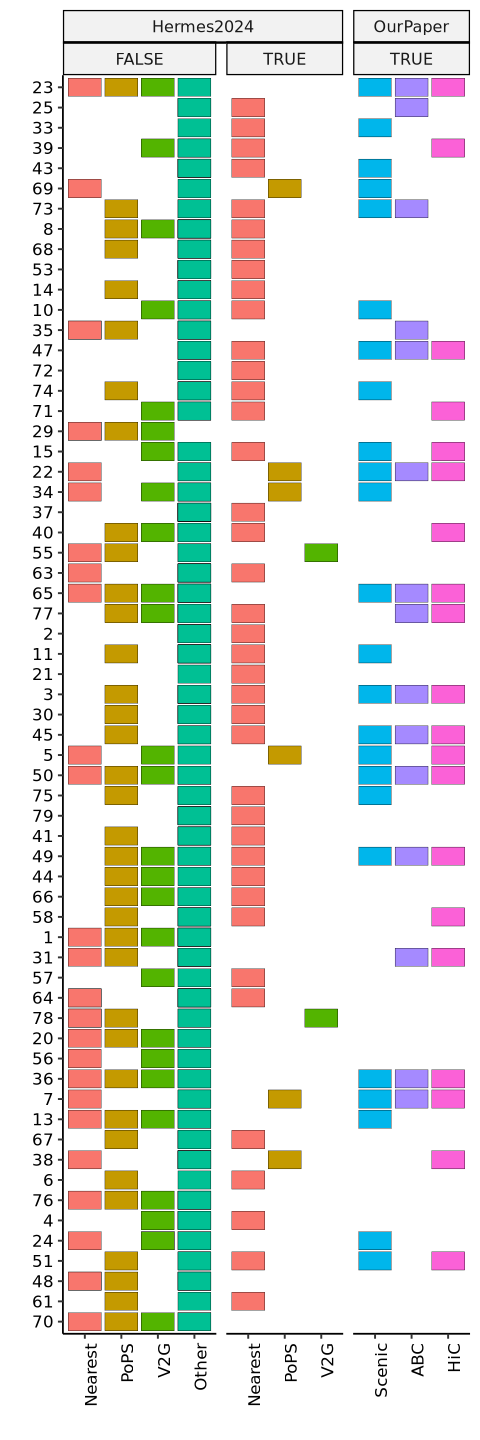

In [3150]:
options(repr.plot.width = 4, repr.plot.height = 12)
gg = ggplot(GWASpaper_ourPaper, aes(x = discovery_method, y = Locus, fill = discovery_method)) +
  geom_tile(color = "black", width = 0.9, height = 0.9) +  # Use tiles to represent values
  labs(
    x = "", 
    y = ""
  ) +
  theme_pubr() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1,size = 10),
    axis.text.y = element_text(size = 10),
    axis.title = element_text(size = 12),
    legend.position = "none"  # Show legend for the viridis scale
  ) +
  facet_nested(cols = vars(paper, Prioritize), scales = "free", space = "free")
gg

In [2570]:
ggsave(filename = paste0("/nfs/lab/projects/mega_heart/Plots_figures/",
                         "80Loci_HermesVsUs.pdf"),
                            width = 4, height = 12, 
                            plot = gg, device = "pdf")

In [3159]:
# Modify tables
unique_locus_table_MOD = unique_locus_table  %>% 
                mutate(Locus = str_remove(Locus, "locus_"))

LociAnno_GWAS_paper_MOD = dplyr::filter(LociAnno_GWAS_paper, Prioritize == "TRUE")
LociAnno_GWAS_paper_MOD

TargetGenes Locus discovery_method Prioritize paper     
1  PRDM16      2     Nearest          TRUE       Hermes2024
2  RNF207      3     Nearest          TRUE       Hermes2024
3  HSPB7       4     Nearest          TRUE       Hermes2024
4  MAST2       5     PoPS             TRUE       Hermes2024
5  NFIA        6     Nearest          TRUE       Hermes2024
6  NEXN        7     PoPS             TRUE       Hermes2024
7  GON4L       8     Nearest          TRUE       Hermes2024
8  PROX1       10    Nearest          TRUE       Hermes2024
9  OBSCN       11    Nearest          TRUE       Hermes2024
10 STRN        14    Nearest          TRUE       Hermes2024
11 TMEM182     15    Nearest          TRUE       Hermes2024
12 MITF        21    Nearest          TRUE       Hermes2024
13 PDZRN3      22    PoPS             TRUE       Hermes2024
14 PROM1       25    Nearest          TRUE       Hermes2024
15 HSPA4       30    Nearest          TRUE       Hermes2024
16 MAP3K7      33    Nearest          TRUE       Hermes2024
17 LATS1       34    PoPS             TRUE       Hermes2024
18 FBXO32      37    Nearest          TRUE       Hermes2024
19 MTSS1       38    PoPS             TRUE       Hermes2024
20 AGO2        39    Nearest          TRUE       Hermes2024
21 NPR2        40    Nearest          TRUE       Hermes2024
22 RNF38       41    Nearest          TRUE       Hermes2024
23 MYPN        43    Nearest          TRUE       Hermes2024
24 SYNPO2L     44    Nearest          TRUE       Hermes2024
25 BMPR1A      45    Nearest          TRUE       Hermes2024
26 BAG3        47    Nearest          TRUE       Hermes2024
27 MYBPC3      49    Nearest          TRUE       Hermes2024
28 SSPN        51    Nearest          TRUE       Hermes2024
29 MYL6        53    Nearest          TRUE       Hermes2024
30 CCDC92      55    V2G              TRUE       Hermes2024
31 DLEU1       57    Nearest          TRUE       Hermes2024
32 COL4A1      58    Nearest          TRUE       Hermes2024
33 FOXN3       61    Nearest          TRUE       Hermes2024
34 ALPK3       63    Nearest          TRUE       Hermes2024
35 LMF1        64    Nearest          TRUE       Hermes2024
36 TRPV1       66    Nearest          TRUE       Hermes2024
37 MAPT        67    Nearest          TRUE       Hermes2024
38 HLF         68    Nearest          TRUE       Hermes2024
39 PRKCA       69    PoPS             TRUE       Hermes2024
40 FHOD3       71    Nearest          TRUE       Hermes2024
41 NEDD4L      72    Nearest          TRUE       Hermes2024
42 NFATC1      73    Nearest          TRUE       Hermes2024
43 KDM4B       74    Nearest          TRUE       Hermes2024
44 ZNF253      75    Nearest          TRUE       Hermes2024
45 TRPC4AP     77    Nearest          TRUE       Hermes2024
46 BACH1       78    V2G              TRUE       Hermes2024
47 ERG         79    Nearest          TRUE       Hermes2024

In [3244]:
# First annotate gene-links that are concordant
df_filtered = df_filtered %>%
    full_join(LociAnno_GWAS_paper_MOD, "Locus") %>%
    inner_join(unique_locus_table_MOD, "Locus") %>%
    dplyr::select(Locus, chr_cytoband, TargetGenes.x, TargetGenes.y, discovery_method.x, Prioritize.y, paper.x, paper.y)

In [3245]:
write.table(df_filtered, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_FNIH_Vs_Hermes.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)

In [3246]:
dplyr::filter(df_filtered, Locus == 15)

Locus chr_cytoband TargetGenes.x TargetGenes.y discovery_method.x
1 15    2q12.1       TMEM182       TMEM182       HiC               
2 15    2q12.1       TMEM182       TMEM182       Scenic            
  Prioritize.y paper.x  paper.y   
1 TRUE         OurPaper Hermes2024
2 TRUE         OurPaper Hermes2024

In [3198]:
length(unique(LociAnno_GWAS_paper_MOD$Locus))
LociAnno_GWAS_paper_MOD_2 = dplyr::select(LociAnno_GWAS_paper_MOD, 
              Locus,
              target_Gene_Hermes2024 = TargetGenes)

head(LociAnno_GWAS_paper_MOD_2)

[1] 47

Locus target_Gene_Hermes2024
1 2     PRDM16                
2 3     RNF207                
3 4     HSPB7                 
4 5     MAST2                 
5 6     NFIA                  
6 7     NEXN

In [3212]:
## ADD tss location to the target genes at the variant level
tss_data <- read.table("/nfs/lab/Luca/Assets/references/hg38_refseq_TSS.bed", 
                       header = FALSE, stringsAsFactors = FALSE)
colnames(tss_data) <- c("chrom", "start", "end", "strand", "gene_name")

tss_gr <- GRanges(
  seqnames = tss_data$chrom,
  ranges = IRanges(start = tss_data$start, end = tss_data$end),
  strand = tss_data$strand,
  gene_name = tss_data$gene_name
)

# Calculate the TSS coordinate: for '+' use start; for '-' use end.
tss_gr$TSS <- ifelse(as.character(strand(tss_gr)) == "+", start(tss_gr), end(tss_gr))
# Define canonical chromosomes
canonical_chroms <- paste0("chr", c(1:22, "X", "Y"))

# Keep only canonical chromosomes in the tss_gr GRanges object, removing non-canonical ones
tss_gr <- keepSeqlevels(tss_gr, canonical_chroms, pruning.mode = "coarse")

# Convert the GRanges object to a data frame for joining
tss_df <- as.data.frame(tss_gr)[, c("seqnames", "TSS", "gene_name")]
colnames(tss_df)[1] <- "chrom"  # rename 'seqnames' to 'chrom' to match your data if needed

In [3222]:
locus_info = data.all.hg38  %>%
                 mutate(Locus = str_remove(Locus, "locus_")) %>%
                 mutate(chr_cytoband = paste0(gsub("^chr", "", chr.hg38), cytoband)) %>%
                 dplyr::select(Locus, chr_cytoband, rsID, variant_Location = end.hg38)

In [3252]:
data.use = data.use %>%
  mutate(Locus = str_remove(Locus, "locus_")) %>%
  dplyr::select(rsID, Locus,
         target_Gene_thisPaper = target_Gene, 
         discovery_method_thisPaper = loop_method) %>%
  separate_rows(target_Gene_thisPaper, sep = ",\\s*") %>%
  distinct() %>%
  full_join(LociAnno_GWAS_paper_MOD_2, by = "Locus") %>%
  inner_join(locus_info, by = c("rsID", "Locus")) %>%
  relocate(chr_cytoband, .after = Locus) %>% 
  relocate(variant_Location, .after = rsID) %>% 
  mutate(target_Gene_Hermes2024 = coalesce(target_Gene_Hermes2024, "NOT_PRIORITIZED")) %>%
  mutate(same_targetGene = if_else(target_Gene_thisPaper == target_Gene_Hermes2024, "YES", "NO")) %>%
  left_join(tss_df %>% 
            dplyr::select(gene_name, target_Gene_thisPaper_TSS = TSS),
    by = c("target_Gene_thisPaper" = "gene_name")) %>%
  mutate(interaction_distance_OurPaper = abs(variant_Location - target_Gene_thisPaper_TSS))

In [3253]:
data.use

rsID        variant_Location Locus chr_cytoband target_Gene_thisPaper
1    rs2540277   102809718        15    2q12.1       TMEM182              
2    rs115766732  73069929        22    3p13         GXYLT2               
3    rs147946313  73069911        22    3p13         GXYLT2               
4    rs72877568   73069936        22    3p13         GXYLT2               
5    rs150944917  73805797        22    3p13         PDZRN3               
6    rs34865064   73069345        22    3p13         GXYLT2               
7    rs59637384  134313522        23    3q22.2       ANAPC13              
8    rs59637384  134313522        23    3q22.2       CEP63                
9    rs369741362 134313412        23    3q22.2       ANAPC13              
10   rs369741362 134313412        23    3q22.2       CEP63                
11   rs192695444 134313440        23    3q22.2       ANAPC13              
12   rs192695444 134313440        23    3q22.2       CEP63                
13   rs59637384  134313522        23    3q22.2       AMOTL2               
14   rs369741362 134313412        23    3q22.2       AMOTL2               
15   rs192695444 134313440        23    3q22.2       AMOTL2               
16   rs9849839   134314884        23    3q22.2       ANAPC13              
17   rs9849839   134314884        23    3q22.2       CEP63                
18   rs9849839   134314884        23    3q22.2       AMOTL2               
19   rs193214453 134476980        23    3q22.2       AMOTL2               
20   rs186150489 134325992        23    3q22.2       AMOTL2               
21   rs35558600  134325987        23    3q22.2       AMOTL2               
22   rs140509999 134364154        23    3q22.2       ANAPC13              
23   rs140509999 134364154        23    3q22.2       CEP63                
24   rs143146952 134374431        23    3q22.2       ANAPC13              
25   rs143146952 134374431        23    3q22.2       CEP63                
26   rs116383127 134211851        23    3q22.2       AMOTL2               
27   rs6577479     6058884        3     1p36.31      ICMT                 
28   rs6577479     6058884        3     1p36.31      HES3                 
29   rs11576563    6058633        3     1p36.31      ICMT                 
30   rs11576563    6058633        3     1p36.31      HES3                 
⋮    ⋮           ⋮                ⋮     ⋮            ⋮                    
1955 rs9819631   158571021        24    3q25.32      MLF1                 
1956 rs6577479     6058884        3     1p36.31      NPHP4                
1957 rs77244496    6350457        3     1p36.31      RNF207               
1958 rs11576563    6058633        3     1p36.31      NPHP4                
1959 rs2272988     6205308        3     1p36.31      RNF207               
1960 rs62408252   90400310        33    6q15         MAP3K7               
1961 rs116459411  90400088        33    6q15         MAP3K7               
1962 rs3798761   149683643        34    6q25.1       PPIL4                
1963 rs11785912   11742724        36    8p23.1       CTSB                 
1964 rs17335168   86726617        45    10q23.2      BMPR1A               
1965 rs11202135   86711109        45    10q23.2      BMPR1A               
1966 rs45617144   47437918        49    11p11.2      MYBPC3               
1967 rs1768809    46037164        5     1p34.1       MAST2                
1968 rs117071248 111731466        50    11q23.1      ALG9                 
1969 rs117680887 111731408        50    11q23.1      ALG9                 
1970 rs190445961 111694851        50    11q23.1      SIK2                 
1971 rs190445961 111694851        50    11q23.1      PPP2R1B              
1972 rs190445961 111694851        50    11q23.1      ALG9                 
1973 rs113819537  26195496        51    12p12.1      RASSF8               
1974 rs113819537  26195496        51    12p12.1      ITPR2                
1975 rs6499120    67246336        65    16q22.1      CBFB                 
1976 rs9932087    67198457    

In [3254]:
write.table(data.use, 
            "/nfs/lab/projects/mega_heart/FNIH/multiome/Analysis/3_downstream/Major_celltypes/GeneticTraits_Intersect/80LociHF_FNIH_Vs_Hermes_VariantLevel_Distance.txt",
            col.names = TRUE, row.names = F, sep = "\t", quote = F)